In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

  return key in self.data

  return key in self.data

  return key in self.data



Loading ../data/NAFLD_test/0006/anat.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc


  return key in self.data

  return key in self.data



<IPython.core.display.Javascript object>


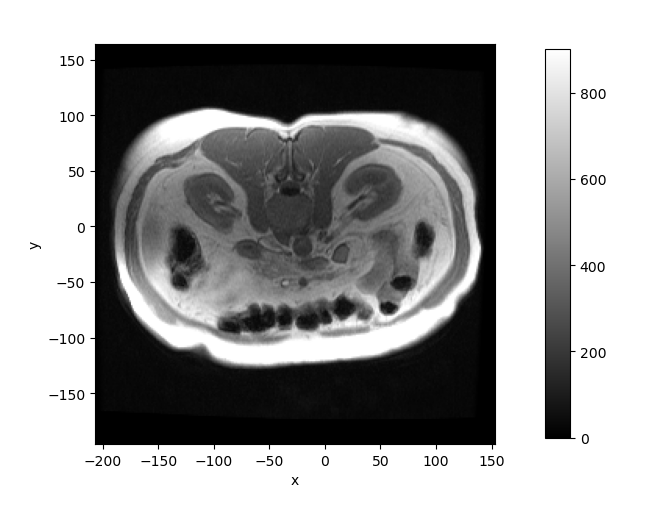

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


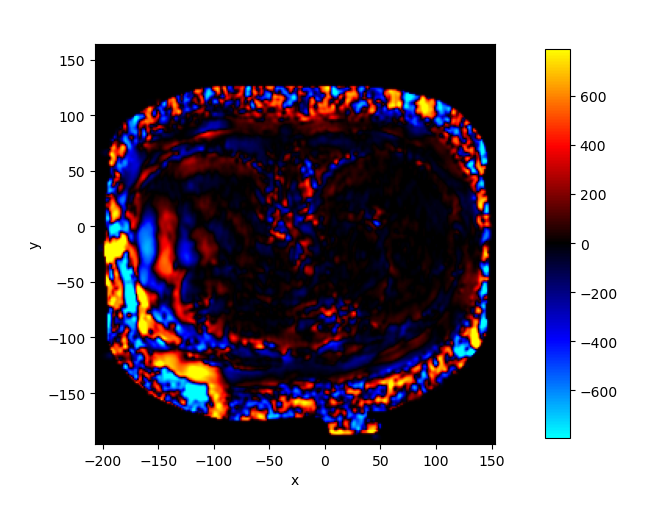

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


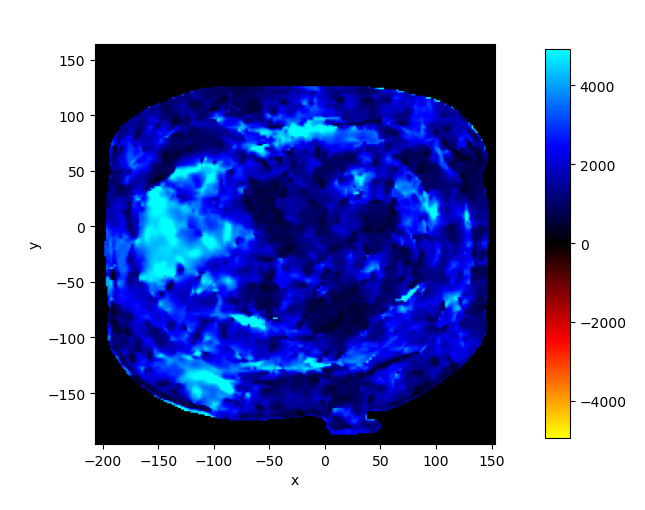

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


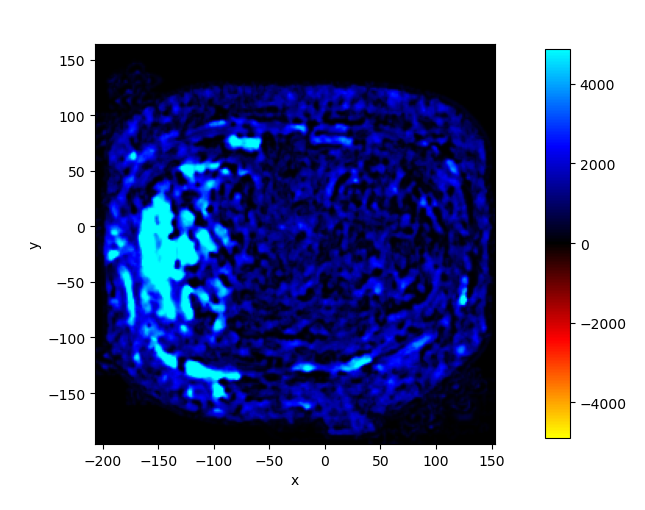

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [37]:
%autoreload
dataset = mre_pinn.data.MREDataset.from_xarrays('../data/NAFLD_test')
dataset.eval_baseline()
dataset[0].view()

In [38]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', rho=1e3, omega=60, detach=True)
pde

In [39]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_pinn_layers=3,
    n_pinn_hidden=128,
    u_omega=16,
    u_scale=1e2,
    u_loc=0,
    mu_omega=16,
    mu_scale=1e3,
    mu_loc=0,
    skip_connect=True,
    dense=True,
    parallel=False
)
pino

HyperCNN(
  (u_cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1,

In [52]:
%autoreload

model = mre_pinn.training.PINOModel(
    dataset, pino, pde,
    loss_weights=[1e-2, 1e-3, 1e-18],
    batch_size=1,
    n_points=16384,
    pde_warmup_iters=5000,
    pde_step_factor=2,
    pde_step_iters=10000
)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)

Precomputing tensors
Compiling model...
'compile' took 0.000237 s



In [53]:
%%time
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(10)

# iterations: 10
Data time/iter:  0.0022s (21.01%)
Model time/iter: 0.0029s (27.93%)
Loss time/iter:  0.0053s (51.05%)
Total time/iter: 0.0103s
Total time: 0.1032s
1k iters time: 0.17m
10k iters time: 1.72m
100k iters time: 0.29h
CPU times: user 248 ms, sys: 135 ms, total: 383 ms
Wall time: 103 ms


Training model...

0         [9.32e+02, 9.22e+02, 0.00e+00]    [9.36e+02, 9.98e+02, 0.00e+00]    []  


<IPython.core.display.Javascript object>


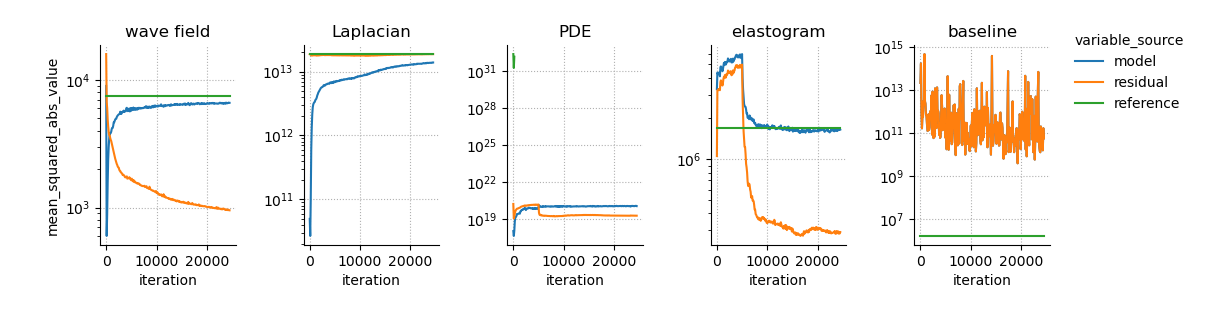

<IPython.core.display.Javascript object>


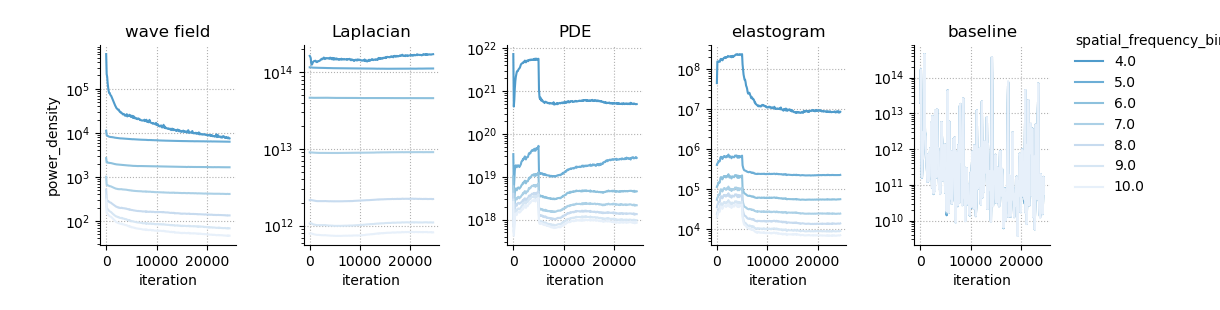

<IPython.core.display.Javascript object>


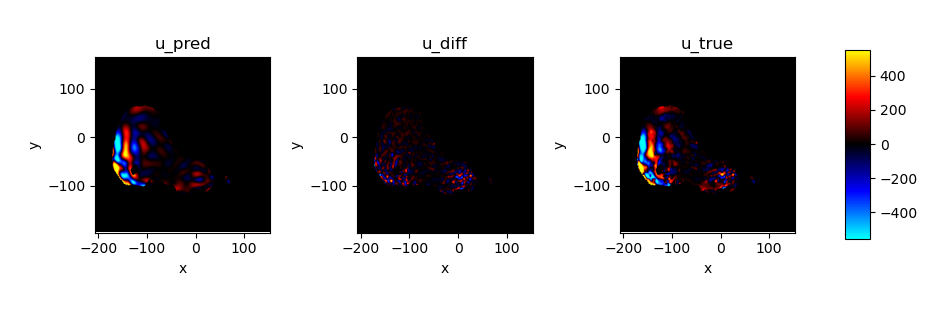

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


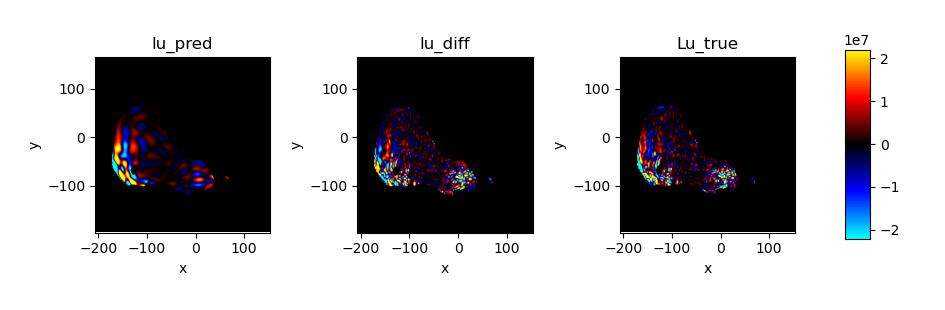

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


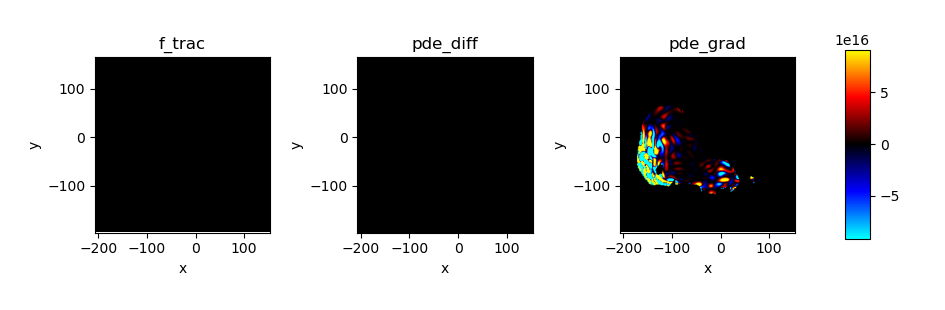

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


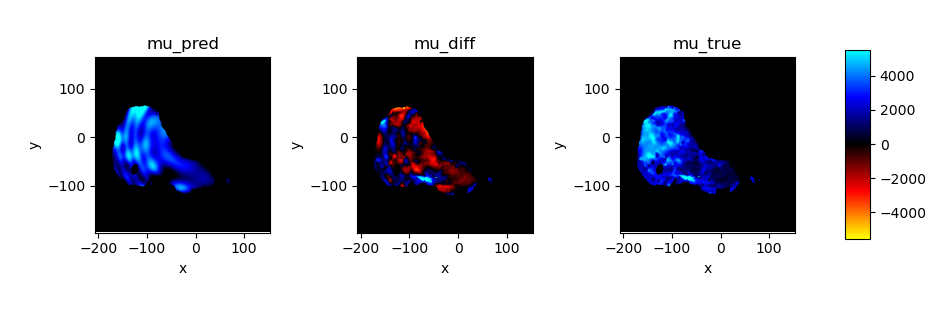

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


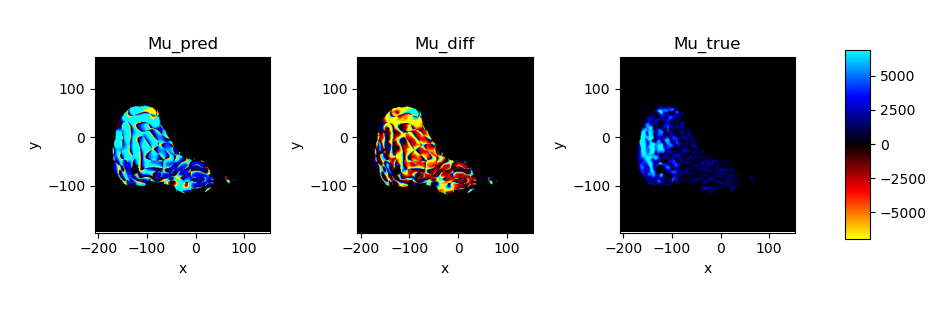

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 15.0582 (94.04%)
10        [6.04e+02, 1.31e-01, 0.00e+00]    [6.05e+02, 2.99e+00, 0.00e+00]    []  
20        [5.37e+02, 2.56e+02, 0.00e+00]    [5.48e+02, 2.11e+02, 0.00e+00]    []  
30        [4.79e+02, 4.21e+01, 0.00e+00]    [4.72e+02, 3.43e+01, 0.00e+00]    []  
40        [4.19e+02, 1.11e+00, 0.00e+00]    [4.28e+02, 7.94e-04, 0.00e+00]    []  
50        [4.15e+02, 1.02e+01, 0.00e+00]    [4.13e+02, 1.76e+01, 0.00e+00]    []  
60        [3.91e+02, 9.12e+00, 0.00e+00]    [4.07e+02, 6.23e+00, 0.00e+00]    []  
70        [3.99e+02, 1.47e-01, 0.00e+00]    [4.02e+02, 4.48e+00, 0.00e+00]    []  
80        [3.89e+02, 2.01e+00, 0.00e+00]    [3.99e+02, 4.22e-01, 0.00e+00]    []  
90        [3.95e+02, 2.37e-02, 0.00e+00]    [3.95e+02, 4.04e-01, 0.00e+00]    []  
100       [3.93e+02, 9.39e-01, 0.00e+00]    [3.92e+02, 6.98e-01, 0.00e+00]    []  
Time spent testing: 12.9241 (81.80%)
110       [3.83e+02, 6.88e-01, 0.00e+00]    [3.89e+02, 8.50e-05, 0.00e+00]    []  
120       [3.

  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.1324 (81.36%)
310       [2.81e+02, 1.76e+00, 0.00e+00]    [2.79e+02, 8.59e-01, 0.00e+00]    []  
320       [2.76e+02, 6.47e+00, 0.00e+00]    [2.75e+02, 5.27e+00, 0.00e+00]    []  
330       [2.73e+02, 6.47e-01, 0.00e+00]    [2.71e+02, 1.51e+00, 0.00e+00]    []  
340       [2.67e+02, 8.94e-01, 0.00e+00]    [2.67e+02, 2.92e-01, 0.00e+00]    []  
350       [2.62e+02, 5.27e+00, 0.00e+00]    [2.63e+02, 3.94e+00, 0.00e+00]    []  
360       [2.56e+02, 2.65e-01, 0.00e+00]    [2.59e+02, 2.54e-02, 0.00e+00]    []  
370       [2.55e+02, 8.75e-02, 0.00e+00]    [2.56e+02, 5.24e-01, 0.00e+00]    []  
380       [2.56e+02, 3.57e+00, 0.00e+00]    [2.52e+02, 1.46e+00, 0.00e+00]    []  
390       [2.41e+02, 2.64e+00, 0.00e+00]    [2.50e+02, 4.20e+00, 0.00e+00]    []  
400       [2.48e+02, 3.91e+00, 0.00e+00]    [2.48e+02, 1.11e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5606 (81.76%)
410       [2.55e+02, 1.20e+01, 0.00e+00]    [2.52e+02, 1.74e+01, 0.00e+00]    []  
420       [2.56e+02, 1.38e+01, 0.00e+00]    [2.50e+02, 2.90e+01, 0.00e+00]    []  
430       [2.50e+02, 1.28e-01, 0.00e+00]    [2.50e+02, 1.75e-01, 0.00e+00]    []  
440       [2.29e+02, 2.91e+00, 0.00e+00]    [2.37e+02, 2.50e-01, 0.00e+00]    []  
450       [2.30e+02, 2.97e-02, 0.00e+00]    [2.35e+02, 3.13e-03, 0.00e+00]    []  
460       [2.37e+02, 5.48e-01, 0.00e+00]    [2.32e+02, 3.78e+00, 0.00e+00]    []  
470       [2.33e+02, 2.98e-02, 0.00e+00]    [2.30e+02, 5.84e-01, 0.00e+00]    []  
480       [2.32e+02, 1.43e+00, 0.00e+00]    [2.28e+02, 3.49e+00, 0.00e+00]    []  
490       [2.37e+02, 1.24e+00, 0.00e+00]    [2.27e+02, 1.02e+00, 0.00e+00]    []  
500       [2.29e+02, 2.01e-01, 0.00e+00]    [2.25e+02, 1.95e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.2539 (81.23%)
510       [2.18e+02, 7.42e-02, 0.00e+00]    [2.22e+02, 1.18e+00, 0.00e+00]    []  
520       [2.29e+02, 2.07e-04, 0.00e+00]    [2.22e+02, 8.19e-01, 0.00e+00]    []  
530       [2.19e+02, 1.99e-01, 0.00e+00]    [2.20e+02, 3.29e+00, 0.00e+00]    []  
540       [2.25e+02, 1.52e+00, 0.00e+00]    [2.21e+02, 2.65e-01, 0.00e+00]    []  
550       [2.22e+02, 3.68e-01, 0.00e+00]    [2.18e+02, 4.61e+00, 0.00e+00]    []  
560       [2.18e+02, 9.67e-01, 0.00e+00]    [2.19e+02, 1.53e+00, 0.00e+00]    []  
570       [2.15e+02, 3.35e+00, 0.00e+00]    [2.14e+02, 1.29e+00, 0.00e+00]    []  
580       [2.17e+02, 1.64e+00, 0.00e+00]    [2.14e+02, 6.03e-01, 0.00e+00]    []  
590       [2.21e+02, 2.08e+00, 0.00e+00]    [2.13e+02, 3.84e+00, 0.00e+00]    []  
600       [2.19e+02, 2.35e+00, 0.00e+00]    [2.12e+02, 5.04e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.4272 (81.68%)
610       [2.11e+02, 8.06e-02, 0.00e+00]    [2.13e+02, 2.94e-02, 0.00e+00]    []  
620       [2.14e+02, 2.34e+00, 0.00e+00]    [2.12e+02, 9.53e-01, 0.00e+00]    []  
630       [2.04e+02, 7.03e-01, 0.00e+00]    [2.10e+02, 6.01e-01, 0.00e+00]    []  
640       [2.15e+02, 4.09e-01, 0.00e+00]    [2.09e+02, 1.36e-04, 0.00e+00]    []  
650       [2.15e+02, 7.81e-01, 0.00e+00]    [2.09e+02, 4.76e-01, 0.00e+00]    []  
660       [2.12e+02, 8.27e-01, 0.00e+00]    [2.10e+02, 1.62e-01, 0.00e+00]    []  
670       [2.09e+02, 3.73e-01, 0.00e+00]    [2.09e+02, 5.53e-03, 0.00e+00]    []  
680       [2.09e+02, 4.58e+00, 0.00e+00]    [2.09e+02, 1.34e+01, 0.00e+00]    []  
690       [2.22e+02, 8.20e+00, 0.00e+00]    [2.11e+02, 1.69e+00, 0.00e+00]    []  
700       [2.18e+02, 1.18e+01, 0.00e+00]    [2.12e+02, 2.28e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4599 (80.81%)
710       [2.12e+02, 2.07e+00, 0.00e+00]    [2.09e+02, 5.89e+00, 0.00e+00]    []  
720       [2.06e+02, 4.79e+00, 0.00e+00]    [2.06e+02, 3.07e+00, 0.00e+00]    []  
730       [2.04e+02, 2.77e-02, 0.00e+00]    [2.06e+02, 2.04e+00, 0.00e+00]    []  
740       [2.08e+02, 2.57e-01, 0.00e+00]    [2.07e+02, 1.23e+00, 0.00e+00]    []  
750       [2.06e+02, 1.11e-02, 0.00e+00]    [2.04e+02, 2.49e+00, 0.00e+00]    []  
760       [2.00e+02, 4.83e+00, 0.00e+00]    [2.05e+02, 2.85e+00, 0.00e+00]    []  
770       [2.01e+02, 1.92e+00, 0.00e+00]    [2.04e+02, 1.30e+00, 0.00e+00]    []  
780       [2.06e+02, 1.18e-01, 0.00e+00]    [2.02e+02, 9.26e-01, 0.00e+00]    []  
790       [2.01e+02, 1.51e+00, 0.00e+00]    [2.01e+02, 3.33e+00, 0.00e+00]    []  
800       [2.03e+02, 1.40e+00, 0.00e+00]    [2.02e+02, 1.45e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9392 (80.73%)
810       [2.03e+02, 7.05e-01, 0.00e+00]    [2.07e+02, 9.77e-01, 0.00e+00]    []  
820       [2.03e+02, 4.21e-02, 0.00e+00]    [2.02e+02, 1.32e-01, 0.00e+00]    []  
830       [2.06e+02, 2.09e+00, 0.00e+00]    [2.01e+02, 5.80e-01, 0.00e+00]    []  
840       [2.05e+02, 2.72e+00, 0.00e+00]    [2.00e+02, 3.32e-03, 0.00e+00]    []  
850       [2.04e+02, 1.51e-02, 0.00e+00]    [2.01e+02, 8.86e-01, 0.00e+00]    []  
860       [2.02e+02, 3.09e-01, 0.00e+00]    [1.98e+02, 4.12e-01, 0.00e+00]    []  
870       [1.96e+02, 1.46e-04, 0.00e+00]    [1.98e+02, 1.03e+00, 0.00e+00]    []  
880       [1.95e+02, 7.22e-01, 0.00e+00]    [1.97e+02, 8.59e-03, 0.00e+00]    []  
890       [1.95e+02, 3.69e-01, 0.00e+00]    [1.97e+02, 1.47e+00, 0.00e+00]    []  
900       [2.00e+02, 1.78e-01, 0.00e+00]    [1.96e+02, 7.82e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.3990 (80.97%)
910       [2.07e+02, 9.31e-04, 0.00e+00]    [1.99e+02, 3.96e+00, 0.00e+00]    []  
920       [1.96e+02, 9.68e-01, 0.00e+00]    [1.95e+02, 2.20e-01, 0.00e+00]    []  
930       [1.98e+02, 4.98e+00, 0.00e+00]    [1.96e+02, 1.16e+01, 0.00e+00]    []  
940       [2.04e+02, 2.82e-03, 0.00e+00]    [1.97e+02, 1.10e+00, 0.00e+00]    []  
950       [1.96e+02, 4.16e+00, 0.00e+00]    [1.97e+02, 1.11e+00, 0.00e+00]    []  
960       [1.93e+02, 1.65e+00, 0.00e+00]    [1.95e+02, 5.80e+00, 0.00e+00]    []  
970       [1.93e+02, 2.96e+00, 0.00e+00]    [1.93e+02, 4.40e+00, 0.00e+00]    []  
980       [1.98e+02, 1.90e+00, 0.00e+00]    [1.95e+02, 8.28e-02, 0.00e+00]    []  
990       [1.96e+02, 2.25e+00, 0.00e+00]    [1.94e+02, 2.92e+00, 0.00e+00]    []  
1000      [1.92e+02, 4.36e+00, 0.00e+00]    [1.93e+02, 3.73e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.8809 (81.20%)
1010      [1.83e+02, 8.65e-01, 0.00e+00]    [1.90e+02, 3.42e-01, 0.00e+00]    []  
1020      [1.86e+02, 2.51e+00, 0.00e+00]    [1.90e+02, 6.87e+00, 0.00e+00]    []  
1030      [1.94e+02, 1.76e-01, 0.00e+00]    [1.90e+02, 2.23e+00, 0.00e+00]    []  
1040      [1.91e+02, 3.46e+00, 0.00e+00]    [1.93e+02, 4.69e+00, 0.00e+00]    []  
1050      [1.93e+02, 1.83e-01, 0.00e+00]    [1.88e+02, 3.32e+00, 0.00e+00]    []  
1060      [1.93e+02, 1.80e-02, 0.00e+00]    [1.90e+02, 5.96e-01, 0.00e+00]    []  
1070      [1.93e+02, 6.22e-01, 0.00e+00]    [1.88e+02, 6.63e-01, 0.00e+00]    []  
1080      [1.88e+02, 1.59e-01, 0.00e+00]    [1.88e+02, 1.46e+00, 0.00e+00]    []  
1090      [1.89e+02, 3.81e-02, 0.00e+00]    [1.86e+02, 2.21e+00, 0.00e+00]    []  
1100      [1.84e+02, 6.62e-01, 0.00e+00]    [1.85e+02, 7.65e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.3779 (81.42%)
1110      [1.88e+02, 1.81e-01, 0.00e+00]    [1.87e+02, 1.47e+00, 0.00e+00]    []  
1120      [1.89e+02, 9.28e-01, 0.00e+00]    [1.84e+02, 3.36e+00, 0.00e+00]    []  
1130      [1.79e+02, 1.45e+01, 0.00e+00]    [1.86e+02, 1.94e+01, 0.00e+00]    []  
1140      [1.85e+02, 2.51e+00, 0.00e+00]    [1.83e+02, 1.22e+00, 0.00e+00]    []  
1150      [1.85e+02, 4.86e-01, 0.00e+00]    [1.83e+02, 5.52e-01, 0.00e+00]    []  
1160      [1.79e+02, 1.20e-01, 0.00e+00]    [1.85e+02, 3.18e-01, 0.00e+00]    []  
1170      [1.80e+02, 1.13e+00, 0.00e+00]    [1.81e+02, 4.64e+00, 0.00e+00]    []  
1180      [1.81e+02, 2.15e+00, 0.00e+00]    [1.83e+02, 1.85e+00, 0.00e+00]    []  
1190      [1.90e+02, 2.75e+00, 0.00e+00]    [1.79e+02, 5.35e-01, 0.00e+00]    []  
1200      [1.85e+02, 2.32e-03, 0.00e+00]    [1.79e+02, 1.87e-07, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8977 (81.06%)
1210      [1.74e+02, 1.26e+00, 0.00e+00]    [1.79e+02, 6.46e+00, 0.00e+00]    []  
1220      [1.81e+02, 9.33e-01, 0.00e+00]    [1.78e+02, 4.58e-02, 0.00e+00]    []  
1230      [1.70e+02, 1.88e-01, 0.00e+00]    [1.76e+02, 3.32e+00, 0.00e+00]    []  
1240      [1.78e+02, 1.48e+00, 0.00e+00]    [1.76e+02, 4.97e-03, 0.00e+00]    []  
1250      [1.75e+02, 3.45e+00, 0.00e+00]    [1.77e+02, 2.61e+00, 0.00e+00]    []  
1260      [1.78e+02, 2.19e-01, 0.00e+00]    [1.75e+02, 1.53e-01, 0.00e+00]    []  
1270      [1.74e+02, 2.99e+00, 0.00e+00]    [1.74e+02, 1.09e+01, 0.00e+00]    []  
1280      [1.71e+02, 7.79e+00, 0.00e+00]    [1.72e+02, 7.67e+00, 0.00e+00]    []  
1290      [1.71e+02, 1.97e-01, 0.00e+00]    [1.73e+02, 1.43e+00, 0.00e+00]    []  
1300      [1.69e+02, 5.83e-01, 0.00e+00]    [1.72e+02, 6.73e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.8723 (81.26%)
1310      [1.68e+02, 9.27e-03, 0.00e+00]    [1.71e+02, 2.92e-01, 0.00e+00]    []  
1320      [1.68e+02, 2.65e-04, 0.00e+00]    [1.71e+02, 6.20e-02, 0.00e+00]    []  
1330      [1.71e+02, 1.10e+00, 0.00e+00]    [1.70e+02, 4.79e+00, 0.00e+00]    []  
1340      [1.68e+02, 2.94e-01, 0.00e+00]    [1.68e+02, 5.41e-01, 0.00e+00]    []  
1350      [1.71e+02, 4.73e-02, 0.00e+00]    [1.68e+02, 1.39e+00, 0.00e+00]    []  
1360      [1.66e+02, 1.31e-02, 0.00e+00]    [1.68e+02, 7.73e+00, 0.00e+00]    []  
1370      [1.74e+02, 4.20e+00, 0.00e+00]    [1.69e+02, 5.04e+00, 0.00e+00]    []  
1380      [1.66e+02, 3.39e+00, 0.00e+00]    [1.66e+02, 1.31e-02, 0.00e+00]    []  
1390      [1.64e+02, 9.47e-01, 0.00e+00]    [1.66e+02, 1.91e+00, 0.00e+00]    []  
1400      [1.67e+02, 5.14e+00, 0.00e+00]    [1.65e+02, 1.36e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6495 (81.42%)
1410      [1.62e+02, 6.06e-02, 0.00e+00]    [1.63e+02, 1.97e-01, 0.00e+00]    []  
1420      [1.66e+02, 4.69e+00, 0.00e+00]    [1.64e+02, 3.56e-02, 0.00e+00]    []  
1430      [1.62e+02, 3.95e+00, 0.00e+00]    [1.64e+02, 5.40e+00, 0.00e+00]    []  
1440      [1.64e+02, 1.89e+00, 0.00e+00]    [1.62e+02, 2.73e+00, 0.00e+00]    []  
1450      [1.55e+02, 7.66e-01, 0.00e+00]    [1.60e+02, 4.70e-01, 0.00e+00]    []  
1460      [1.63e+02, 2.87e+00, 0.00e+00]    [1.62e+02, 2.12e-02, 0.00e+00]    []  
1470      [1.66e+02, 1.09e+01, 0.00e+00]    [1.65e+02, 1.75e+01, 0.00e+00]    []  
1480      [1.62e+02, 6.82e-01, 0.00e+00]    [1.63e+02, 1.14e+00, 0.00e+00]    []  
1490      [1.56e+02, 8.16e-01, 0.00e+00]    [1.60e+02, 1.02e-01, 0.00e+00]    []  
1500      [1.55e+02, 1.82e+00, 0.00e+00]    [1.60e+02, 4.47e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0460 (81.14%)
1510      [1.59e+02, 1.16e+00, 0.00e+00]    [1.58e+02, 3.85e+00, 0.00e+00]    []  
1520      [1.59e+02, 7.71e+00, 0.00e+00]    [1.60e+02, 2.10e+00, 0.00e+00]    []  
1530      [1.58e+02, 1.54e-01, 0.00e+00]    [1.59e+02, 6.28e+00, 0.00e+00]    []  
1540      [1.61e+02, 7.66e+00, 0.00e+00]    [1.61e+02, 9.86e+00, 0.00e+00]    []  
1550      [1.62e+02, 4.03e-01, 0.00e+00]    [1.58e+02, 9.68e-01, 0.00e+00]    []  
1560      [1.67e+02, 2.95e-01, 0.00e+00]    [1.61e+02, 1.30e+01, 0.00e+00]    []  
1570      [1.56e+02, 1.95e-01, 0.00e+00]    [1.57e+02, 8.73e-01, 0.00e+00]    []  
1580      [1.58e+02, 1.11e-02, 0.00e+00]    [1.52e+02, 9.76e+00, 0.00e+00]    []  
1590      [1.54e+02, 5.66e-02, 0.00e+00]    [1.52e+02, 3.35e+00, 0.00e+00]    []  
1600      [1.52e+02, 2.89e-01, 0.00e+00]    [1.52e+02, 4.03e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.4168 (81.41%)
1610      [1.51e+02, 1.50e+00, 0.00e+00]    [1.52e+02, 2.94e-01, 0.00e+00]    []  
1620      [1.55e+02, 1.56e+00, 0.00e+00]    [1.50e+02, 1.12e-01, 0.00e+00]    []  
1630      [1.50e+02, 1.85e-01, 0.00e+00]    [1.50e+02, 1.29e+00, 0.00e+00]    []  
1640      [1.50e+02, 7.26e-02, 0.00e+00]    [1.50e+02, 1.07e+00, 0.00e+00]    []  
1650      [1.44e+02, 2.88e-02, 0.00e+00]    [1.48e+02, 3.16e-01, 0.00e+00]    []  
1660      [1.48e+02, 4.38e+00, 0.00e+00]    [1.49e+02, 3.19e+00, 0.00e+00]    []  
1670      [1.48e+02, 4.88e-01, 0.00e+00]    [1.48e+02, 2.27e-01, 0.00e+00]    []  
1680      [1.47e+02, 7.85e-02, 0.00e+00]    [1.47e+02, 7.43e-03, 0.00e+00]    []  
1690      [1.45e+02, 2.61e+00, 0.00e+00]    [1.47e+02, 8.45e-01, 0.00e+00]    []  
1700      [1.49e+02, 5.52e-02, 0.00e+00]    [1.46e+02, 1.89e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.1608 (81.04%)
1710      [1.48e+02, 4.89e-01, 0.00e+00]    [1.44e+02, 2.09e-02, 0.00e+00]    []  
1720      [1.43e+02, 6.38e+00, 0.00e+00]    [1.46e+02, 2.69e-03, 0.00e+00]    []  
1730      [1.49e+02, 1.30e-02, 0.00e+00]    [1.46e+02, 1.41e+01, 0.00e+00]    []  
1740      [1.47e+02, 1.39e+00, 0.00e+00]    [1.44e+02, 5.97e-02, 0.00e+00]    []  
1750      [1.47e+02, 8.72e+00, 0.00e+00]    [1.46e+02, 7.48e+00, 0.00e+00]    []  
1760      [1.49e+02, 1.42e+00, 0.00e+00]    [1.44e+02, 1.02e-01, 0.00e+00]    []  
1770      [1.41e+02, 5.00e+00, 0.00e+00]    [1.43e+02, 5.91e+00, 0.00e+00]    []  
1780      [1.45e+02, 8.15e-01, 0.00e+00]    [1.42e+02, 5.14e-01, 0.00e+00]    []  
1790      [1.46e+02, 1.02e+00, 0.00e+00]    [1.41e+02, 7.07e-01, 0.00e+00]    []  
1800      [1.45e+02, 1.36e-01, 0.00e+00]    [1.41e+02, 3.61e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8456 (81.13%)
1810      [1.36e+02, 1.53e+01, 0.00e+00]    [1.40e+02, 2.47e+01, 0.00e+00]    []  
1820      [1.38e+02, 1.81e+00, 0.00e+00]    [1.41e+02, 1.71e+00, 0.00e+00]    []  
1830      [1.42e+02, 1.58e+00, 0.00e+00]    [1.40e+02, 1.24e+00, 0.00e+00]    []  
1840      [1.35e+02, 8.38e-01, 0.00e+00]    [1.41e+02, 6.11e-02, 0.00e+00]    []  
1850      [1.38e+02, 1.93e-01, 0.00e+00]    [1.38e+02, 1.81e+00, 0.00e+00]    []  
1860      [1.35e+02, 2.14e+00, 0.00e+00]    [1.38e+02, 2.18e+00, 0.00e+00]    []  
1870      [1.31e+02, 3.24e+00, 0.00e+00]    [1.36e+02, 1.04e+01, 0.00e+00]    []  
1880      [1.36e+02, 6.03e-02, 0.00e+00]    [1.37e+02, 7.14e+00, 0.00e+00]    []  
1890      [1.34e+02, 1.63e-01, 0.00e+00]    [1.37e+02, 3.77e+00, 0.00e+00]    []  
1900      [1.36e+02, 8.35e-02, 0.00e+00]    [1.36e+02, 6.01e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.3577 (81.35%)
1910      [1.36e+02, 3.15e-01, 0.00e+00]    [1.35e+02, 3.72e+00, 0.00e+00]    []  
1920      [1.30e+02, 7.96e-01, 0.00e+00]    [1.35e+02, 5.94e-01, 0.00e+00]    []  
1930      [1.31e+02, 9.15e+00, 0.00e+00]    [1.35e+02, 1.33e+01, 0.00e+00]    []  
1940      [1.33e+02, 1.25e-01, 0.00e+00]    [1.33e+02, 4.59e+00, 0.00e+00]    []  
1950      [1.36e+02, 9.49e-01, 0.00e+00]    [1.34e+02, 5.70e+00, 0.00e+00]    []  
1960      [1.33e+02, 7.27e-01, 0.00e+00]    [1.32e+02, 1.08e-01, 0.00e+00]    []  
1970      [1.32e+02, 9.23e-01, 0.00e+00]    [1.33e+02, 8.73e+00, 0.00e+00]    []  
1980      [1.34e+02, 3.05e-01, 0.00e+00]    [1.32e+02, 8.97e+00, 0.00e+00]    []  
1990      [1.31e+02, 4.73e+00, 0.00e+00]    [1.32e+02, 4.08e-02, 0.00e+00]    []  
2000      [1.31e+02, 2.28e-01, 0.00e+00]    [1.31e+02, 6.13e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5995 (81.12%)
2010      [1.28e+02, 6.75e-03, 0.00e+00]    [1.31e+02, 1.93e+00, 0.00e+00]    []  
2020      [1.32e+02, 1.36e+00, 0.00e+00]    [1.31e+02, 1.13e-02, 0.00e+00]    []  
2030      [1.25e+02, 1.15e-01, 0.00e+00]    [1.31e+02, 1.55e+01, 0.00e+00]    []  
2040      [1.27e+02, 3.52e+00, 0.00e+00]    [1.33e+02, 9.01e-01, 0.00e+00]    []  
2050      [1.32e+02, 1.41e+00, 0.00e+00]    [1.35e+02, 1.64e+00, 0.00e+00]    []  
2060      [1.31e+02, 3.55e+00, 0.00e+00]    [1.31e+02, 3.64e-01, 0.00e+00]    []  
2070      [1.28e+02, 1.01e+01, 0.00e+00]    [1.30e+02, 8.51e+00, 0.00e+00]    []  
2080      [1.31e+02, 2.61e+00, 0.00e+00]    [1.31e+02, 4.20e+00, 0.00e+00]    []  
2090      [1.31e+02, 5.57e-02, 0.00e+00]    [1.29e+02, 1.68e+00, 0.00e+00]    []  
2100      [1.28e+02, 1.95e-01, 0.00e+00]    [1.28e+02, 2.99e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1830 (81.14%)
2110      [1.28e+02, 2.34e-02, 0.00e+00]    [1.27e+02, 1.09e+00, 0.00e+00]    []  
2120      [1.26e+02, 1.57e+00, 0.00e+00]    [1.28e+02, 1.32e+00, 0.00e+00]    []  
2130      [1.28e+02, 7.61e+00, 0.00e+00]    [1.27e+02, 7.92e+00, 0.00e+00]    []  
2140      [1.25e+02, 6.26e-01, 0.00e+00]    [1.27e+02, 2.34e+00, 0.00e+00]    []  
2150      [1.30e+02, 1.93e+00, 0.00e+00]    [1.29e+02, 1.64e+00, 0.00e+00]    []  
2160      [1.30e+02, 6.12e-01, 0.00e+00]    [1.30e+02, 1.54e+00, 0.00e+00]    []  
2170      [1.20e+02, 2.77e-01, 0.00e+00]    [1.26e+02, 2.18e+00, 0.00e+00]    []  
2180      [1.23e+02, 4.47e-03, 0.00e+00]    [1.27e+02, 4.03e-01, 0.00e+00]    []  
2190      [1.25e+02, 2.67e+00, 0.00e+00]    [1.24e+02, 2.14e-02, 0.00e+00]    []  
2200      [1.24e+02, 3.63e+00, 0.00e+00]    [1.26e+02, 1.12e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.2609 (80.98%)
2210      [1.26e+02, 1.72e-01, 0.00e+00]    [1.26e+02, 3.84e-02, 0.00e+00]    []  
2220      [1.27e+02, 1.61e+00, 0.00e+00]    [1.24e+02, 3.35e-01, 0.00e+00]    []  
2230      [1.25e+02, 1.73e-01, 0.00e+00]    [1.24e+02, 1.53e-02, 0.00e+00]    []  
2240      [1.24e+02, 1.01e+00, 0.00e+00]    [1.24e+02, 1.63e+00, 0.00e+00]    []  
2250      [1.18e+02, 2.58e+00, 0.00e+00]    [1.26e+02, 1.34e+01, 0.00e+00]    []  
2260      [1.19e+02, 1.44e-01, 0.00e+00]    [1.23e+02, 1.82e+00, 0.00e+00]    []  
2270      [1.23e+02, 5.98e+00, 0.00e+00]    [1.23e+02, 1.84e-01, 0.00e+00]    []  
2280      [1.25e+02, 2.87e+00, 0.00e+00]    [1.23e+02, 3.44e+00, 0.00e+00]    []  
2290      [1.21e+02, 3.10e+00, 0.00e+00]    [1.23e+02, 6.62e+00, 0.00e+00]    []  
2300      [1.25e+02, 1.90e-01, 0.00e+00]    [1.23e+02, 3.42e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7091 (81.07%)
2310      [1.20e+02, 1.29e-01, 0.00e+00]    [1.21e+02, 2.33e-01, 0.00e+00]    []  
2320      [1.21e+02, 8.84e-03, 0.00e+00]    [1.21e+02, 1.22e+00, 0.00e+00]    []  
2330      [1.21e+02, 2.48e+00, 0.00e+00]    [1.21e+02, 9.36e-01, 0.00e+00]    []  
2340      [1.21e+02, 1.59e+01, 0.00e+00]    [1.23e+02, 7.53e+00, 0.00e+00]    []  
2350      [1.25e+02, 6.48e-01, 0.00e+00]    [1.23e+02, 4.73e-02, 0.00e+00]    []  
2360      [1.15e+02, 1.66e-02, 0.00e+00]    [1.22e+02, 9.77e-01, 0.00e+00]    []  
2370      [1.20e+02, 1.12e+00, 0.00e+00]    [1.21e+02, 1.83e-01, 0.00e+00]    []  
2380      [1.19e+02, 3.86e-02, 0.00e+00]    [1.20e+02, 1.68e-04, 0.00e+00]    []  
2390      [1.18e+02, 2.39e+00, 0.00e+00]    [1.19e+02, 6.26e+00, 0.00e+00]    []  
2400      [1.23e+02, 3.93e-01, 0.00e+00]    [1.21e+02, 2.81e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9121 (81.13%)
2410      [1.24e+02, 3.68e-01, 0.00e+00]    [1.21e+02, 2.13e+00, 0.00e+00]    []  
2420      [1.21e+02, 9.73e-02, 0.00e+00]    [1.21e+02, 2.81e+00, 0.00e+00]    []  
2430      [1.21e+02, 3.07e-01, 0.00e+00]    [1.19e+02, 2.41e-01, 0.00e+00]    []  
2440      [1.16e+02, 3.69e+00, 0.00e+00]    [1.20e+02, 2.58e+00, 0.00e+00]    []  
2450      [1.20e+02, 6.45e-04, 0.00e+00]    [1.19e+02, 9.17e-01, 0.00e+00]    []  
2460      [1.18e+02, 7.25e-02, 0.00e+00]    [1.20e+02, 7.12e-01, 0.00e+00]    []  
2470      [1.22e+02, 2.00e-03, 0.00e+00]    [1.17e+02, 5.70e+00, 0.00e+00]    []  
2480      [1.15e+02, 3.43e-03, 0.00e+00]    [1.17e+02, 6.51e-01, 0.00e+00]    []  
2490      [1.21e+02, 2.88e+00, 0.00e+00]    [1.20e+02, 7.12e+00, 0.00e+00]    []  
2500      [1.17e+02, 7.98e-03, 0.00e+00]    [1.20e+02, 2.47e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8274 (81.20%)
2510      [1.19e+02, 2.94e-01, 0.00e+00]    [1.20e+02, 2.17e-01, 0.00e+00]    []  
2520      [1.20e+02, 7.07e-01, 0.00e+00]    [1.18e+02, 3.16e+00, 0.00e+00]    []  
2530      [1.12e+02, 2.64e-01, 0.00e+00]    [1.16e+02, 2.94e+00, 0.00e+00]    []  
2540      [1.18e+02, 3.47e-01, 0.00e+00]    [1.17e+02, 4.61e-01, 0.00e+00]    []  
2550      [1.11e+02, 2.83e+00, 0.00e+00]    [1.15e+02, 1.28e-01, 0.00e+00]    []  
2560      [1.14e+02, 3.59e-02, 0.00e+00]    [1.16e+02, 1.08e+01, 0.00e+00]    []  
2570      [1.23e+02, 3.86e-01, 0.00e+00]    [1.18e+02, 3.09e-01, 0.00e+00]    []  
2580      [1.16e+02, 1.63e+00, 0.00e+00]    [1.16e+02, 2.03e-02, 0.00e+00]    []  
2590      [1.11e+02, 1.20e+01, 0.00e+00]    [1.16e+02, 2.39e+00, 0.00e+00]    []  
2600      [1.19e+02, 6.46e-03, 0.00e+00]    [1.15e+02, 4.98e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.2940 (81.24%)
2610      [1.12e+02, 1.16e+00, 0.00e+00]    [1.16e+02, 5.20e+00, 0.00e+00]    []  
2620      [1.17e+02, 1.21e-02, 0.00e+00]    [1.18e+02, 1.93e+00, 0.00e+00]    []  
2630      [1.15e+02, 6.02e+00, 0.00e+00]    [1.15e+02, 2.95e+00, 0.00e+00]    []  
2640      [1.15e+02, 4.67e-02, 0.00e+00]    [1.16e+02, 4.28e-01, 0.00e+00]    []  
2650      [1.16e+02, 9.72e-03, 0.00e+00]    [1.15e+02, 6.03e-02, 0.00e+00]    []  
2660      [1.13e+02, 1.51e-01, 0.00e+00]    [1.16e+02, 2.32e-01, 0.00e+00]    []  
2670      [1.13e+02, 1.29e-02, 0.00e+00]    [1.14e+02, 1.12e-03, 0.00e+00]    []  
2680      [1.11e+02, 2.63e+00, 0.00e+00]    [1.14e+02, 5.71e+00, 0.00e+00]    []  
2690      [1.15e+02, 9.32e-02, 0.00e+00]    [1.14e+02, 1.16e+00, 0.00e+00]    []  
2700      [1.11e+02, 9.14e-01, 0.00e+00]    [1.13e+02, 3.33e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7636 (81.29%)
2710      [1.12e+02, 7.85e-01, 0.00e+00]    [1.13e+02, 2.98e+00, 0.00e+00]    []  
2720      [1.18e+02, 8.38e+00, 0.00e+00]    [1.13e+02, 4.70e+00, 0.00e+00]    []  
2730      [1.15e+02, 8.25e-01, 0.00e+00]    [1.14e+02, 3.97e-01, 0.00e+00]    []  
2740      [1.11e+02, 7.65e-02, 0.00e+00]    [1.14e+02, 1.69e-01, 0.00e+00]    []  
2750      [1.16e+02, 1.32e-01, 0.00e+00]    [1.13e+02, 6.96e-02, 0.00e+00]    []  
2760      [1.09e+02, 2.36e+00, 0.00e+00]    [1.14e+02, 1.37e+00, 0.00e+00]    []  
2770      [1.11e+02, 9.30e+00, 0.00e+00]    [1.14e+02, 9.36e+00, 0.00e+00]    []  
2780      [1.15e+02, 8.65e+00, 0.00e+00]    [1.14e+02, 5.56e+00, 0.00e+00]    []  
2790      [1.15e+02, 7.26e-01, 0.00e+00]    [1.14e+02, 1.44e-03, 0.00e+00]    []  
2800      [1.16e+02, 2.07e+00, 0.00e+00]    [1.13e+02, 8.05e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.7309 (81.29%)
2810      [1.10e+02, 4.87e-01, 0.00e+00]    [1.13e+02, 1.70e+00, 0.00e+00]    []  
2820      [1.13e+02, 2.31e+00, 0.00e+00]    [1.12e+02, 9.14e+00, 0.00e+00]    []  
2830      [1.15e+02, 5.08e-01, 0.00e+00]    [1.12e+02, 7.96e+00, 0.00e+00]    []  
2840      [1.12e+02, 1.13e+00, 0.00e+00]    [1.14e+02, 1.10e+00, 0.00e+00]    []  
2850      [1.13e+02, 1.24e-02, 0.00e+00]    [1.11e+02, 2.91e+00, 0.00e+00]    []  
2860      [1.18e+02, 5.49e+00, 0.00e+00]    [1.10e+02, 1.82e-01, 0.00e+00]    []  
2870      [1.10e+02, 9.12e-02, 0.00e+00]    [1.11e+02, 3.27e-01, 0.00e+00]    []  
2880      [1.07e+02, 2.86e+00, 0.00e+00]    [1.11e+02, 1.46e-01, 0.00e+00]    []  
2890      [1.08e+02, 1.55e+00, 0.00e+00]    [1.10e+02, 1.45e+00, 0.00e+00]    []  
2900      [1.10e+02, 2.04e+00, 0.00e+00]    [1.10e+02, 6.26e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.3543 (81.39%)
2910      [1.11e+02, 1.83e-01, 0.00e+00]    [1.11e+02, 1.13e+00, 0.00e+00]    []  
2920      [1.12e+02, 5.13e+00, 0.00e+00]    [1.12e+02, 5.09e-01, 0.00e+00]    []  
2930      [1.05e+02, 1.69e+00, 0.00e+00]    [1.10e+02, 9.37e-01, 0.00e+00]    []  
2940      [1.10e+02, 9.10e-02, 0.00e+00]    [1.09e+02, 1.80e+00, 0.00e+00]    []  
2950      [1.09e+02, 1.29e-02, 0.00e+00]    [1.11e+02, 5.17e+00, 0.00e+00]    []  
2960      [1.12e+02, 9.00e-02, 0.00e+00]    [1.12e+02, 3.30e+00, 0.00e+00]    []  
2970      [1.10e+02, 1.60e-01, 0.00e+00]    [1.11e+02, 3.19e-02, 0.00e+00]    []  
2980      [1.09e+02, 4.21e+00, 0.00e+00]    [1.10e+02, 1.72e+00, 0.00e+00]    []  
2990      [1.07e+02, 5.16e-01, 0.00e+00]    [1.11e+02, 4.79e-05, 0.00e+00]    []  
3000      [1.09e+02, 2.68e-01, 0.00e+00]    [1.09e+02, 6.23e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.0569 (81.52%)
3010      [1.07e+02, 3.84e-01, 0.00e+00]    [1.09e+02, 3.49e+00, 0.00e+00]    []  
3020      [1.09e+02, 4.99e-01, 0.00e+00]    [1.08e+02, 4.07e-01, 0.00e+00]    []  
3030      [1.10e+02, 4.93e+00, 0.00e+00]    [1.10e+02, 5.24e+00, 0.00e+00]    []  
3040      [1.09e+02, 3.02e+00, 0.00e+00]    [1.09e+02, 4.83e-01, 0.00e+00]    []  
3050      [1.08e+02, 1.53e-01, 0.00e+00]    [1.08e+02, 1.89e+00, 0.00e+00]    []  
3060      [1.10e+02, 8.07e-01, 0.00e+00]    [1.09e+02, 8.33e-01, 0.00e+00]    []  
3070      [1.06e+02, 3.03e-01, 0.00e+00]    [1.09e+02, 3.68e+00, 0.00e+00]    []  
3080      [1.13e+02, 5.71e-02, 0.00e+00]    [1.10e+02, 2.36e+00, 0.00e+00]    []  
3090      [1.09e+02, 2.16e-02, 0.00e+00]    [1.10e+02, 3.62e+00, 0.00e+00]    []  
3100      [1.05e+02, 3.37e-01, 0.00e+00]    [1.08e+02, 2.70e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.2763 (81.35%)
3110      [1.10e+02, 2.70e+00, 0.00e+00]    [1.11e+02, 3.17e+00, 0.00e+00]    []  
3120      [1.10e+02, 4.36e+00, 0.00e+00]    [1.10e+02, 1.94e+01, 0.00e+00]    []  
3130      [1.12e+02, 2.39e-02, 0.00e+00]    [1.11e+02, 5.76e-01, 0.00e+00]    []  
3140      [1.14e+02, 4.08e+00, 0.00e+00]    [1.13e+02, 9.61e-02, 0.00e+00]    []  
3150      [1.08e+02, 5.56e-02, 0.00e+00]    [1.10e+02, 3.46e-01, 0.00e+00]    []  
3160      [1.10e+02, 3.58e-01, 0.00e+00]    [1.07e+02, 1.70e+00, 0.00e+00]    []  
3170      [1.07e+02, 2.63e+00, 0.00e+00]    [1.07e+02, 5.22e-01, 0.00e+00]    []  
3180      [1.09e+02, 2.76e+00, 0.00e+00]    [1.09e+02, 3.98e+00, 0.00e+00]    []  
3190      [1.11e+02, 3.46e+00, 0.00e+00]    [1.09e+02, 4.23e+00, 0.00e+00]    []  
3200      [1.03e+02, 3.98e-02, 0.00e+00]    [1.07e+02, 7.27e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.9136 (81.30%)
3210      [1.07e+02, 1.46e+00, 0.00e+00]    [1.09e+02, 5.38e+00, 0.00e+00]    []  
3220      [1.06e+02, 1.03e+00, 0.00e+00]    [1.08e+02, 1.15e+00, 0.00e+00]    []  
3230      [1.04e+02, 2.29e-02, 0.00e+00]    [1.07e+02, 4.54e-01, 0.00e+00]    []  
3240      [1.04e+02, 9.23e-02, 0.00e+00]    [1.06e+02, 2.73e+00, 0.00e+00]    []  
3250      [1.09e+02, 1.29e-02, 0.00e+00]    [1.07e+02, 5.50e-02, 0.00e+00]    []  
3260      [1.06e+02, 2.12e+00, 0.00e+00]    [1.07e+02, 8.16e-01, 0.00e+00]    []  
3270      [1.06e+02, 1.50e+00, 0.00e+00]    [1.07e+02, 7.19e+00, 0.00e+00]    []  
3280      [1.06e+02, 4.43e-01, 0.00e+00]    [1.06e+02, 2.49e+00, 0.00e+00]    []  
3290      [1.05e+02, 6.31e-01, 0.00e+00]    [1.06e+02, 3.81e+00, 0.00e+00]    []  
3300      [1.05e+02, 4.57e+00, 0.00e+00]    [1.05e+02, 1.67e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8099 (81.38%)
3310      [1.12e+02, 4.46e+00, 0.00e+00]    [1.08e+02, 1.50e+00, 0.00e+00]    []  
3320      [1.04e+02, 6.28e-01, 0.00e+00]    [1.08e+02, 9.84e-01, 0.00e+00]    []  
3330      [1.05e+02, 4.64e-01, 0.00e+00]    [1.11e+02, 7.67e-01, 0.00e+00]    []  
3340      [1.07e+02, 8.32e-03, 0.00e+00]    [1.09e+02, 3.88e-01, 0.00e+00]    []  
3350      [1.04e+02, 5.94e-01, 0.00e+00]    [1.06e+02, 1.24e-01, 0.00e+00]    []  
3360      [1.08e+02, 7.21e-01, 0.00e+00]    [1.06e+02, 1.13e-01, 0.00e+00]    []  
3370      [1.10e+02, 1.14e-01, 0.00e+00]    [1.05e+02, 2.20e-03, 0.00e+00]    []  
3380      [1.04e+02, 8.51e-01, 0.00e+00]    [1.08e+02, 1.33e+00, 0.00e+00]    []  
3390      [1.04e+02, 8.02e+00, 0.00e+00]    [1.06e+02, 3.41e-01, 0.00e+00]    []  
3400      [1.01e+02, 1.30e-01, 0.00e+00]    [1.06e+02, 1.43e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9312 (81.44%)
3410      [1.01e+02, 2.19e+00, 0.00e+00]    [1.05e+02, 2.12e+00, 0.00e+00]    []  
3420      [1.06e+02, 1.70e-02, 0.00e+00]    [1.05e+02, 1.73e+00, 0.00e+00]    []  
3430      [1.04e+02, 3.36e-03, 0.00e+00]    [1.04e+02, 2.84e+00, 0.00e+00]    []  
3440      [1.03e+02, 2.01e-01, 0.00e+00]    [1.04e+02, 1.32e+00, 0.00e+00]    []  
3450      [1.02e+02, 3.08e-02, 0.00e+00]    [1.05e+02, 5.49e-02, 0.00e+00]    []  
3460      [1.07e+02, 1.45e-01, 0.00e+00]    [1.06e+02, 3.49e+00, 0.00e+00]    []  
3470      [1.03e+02, 1.10e-02, 0.00e+00]    [1.04e+02, 3.63e+00, 0.00e+00]    []  
3480      [1.05e+02, 2.48e+00, 0.00e+00]    [1.08e+02, 5.59e+00, 0.00e+00]    []  
3490      [1.04e+02, 1.05e+00, 0.00e+00]    [1.06e+02, 2.71e-01, 0.00e+00]    []  
3500      [1.04e+02, 7.76e-01, 0.00e+00]    [1.05e+02, 2.48e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0399 (81.21%)
3510      [1.04e+02, 6.36e-01, 0.00e+00]    [1.06e+02, 3.38e-03, 0.00e+00]    []  
3520      [1.07e+02, 8.07e-01, 0.00e+00]    [1.05e+02, 4.57e-01, 0.00e+00]    []  
3530      [1.07e+02, 6.63e+00, 0.00e+00]    [1.06e+02, 1.07e+00, 0.00e+00]    []  
3540      [1.03e+02, 3.60e-01, 0.00e+00]    [1.04e+02, 6.62e-02, 0.00e+00]    []  
3550      [1.05e+02, 2.28e-01, 0.00e+00]    [1.06e+02, 2.91e-01, 0.00e+00]    []  
3560      [1.04e+02, 3.94e-02, 0.00e+00]    [1.05e+02, 2.80e+00, 0.00e+00]    []  
3570      [1.04e+02, 1.25e+00, 0.00e+00]    [1.06e+02, 4.52e+00, 0.00e+00]    []  
3580      [1.05e+02, 7.47e+00, 0.00e+00]    [1.06e+02, 3.69e+00, 0.00e+00]    []  
3590      [1.04e+02, 1.35e-01, 0.00e+00]    [1.05e+02, 2.37e+00, 0.00e+00]    []  
3600      [1.02e+02, 1.09e+00, 0.00e+00]    [1.04e+02, 1.80e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.2545 (81.30%)
3610      [1.01e+02, 4.89e-01, 0.00e+00]    [1.03e+02, 1.07e+00, 0.00e+00]    []  
3620      [1.00e+02, 7.13e+00, 0.00e+00]    [1.04e+02, 4.30e+00, 0.00e+00]    []  
3630      [1.08e+02, 5.92e-01, 0.00e+00]    [1.05e+02, 6.01e-01, 0.00e+00]    []  
3640      [1.04e+02, 8.15e-02, 0.00e+00]    [1.04e+02, 5.68e-01, 0.00e+00]    []  
3650      [1.01e+02, 9.70e-02, 0.00e+00]    [1.03e+02, 1.31e+00, 0.00e+00]    []  
3660      [1.01e+02, 5.59e-01, 0.00e+00]    [1.02e+02, 3.78e-03, 0.00e+00]    []  
3670      [1.01e+02, 1.11e+00, 0.00e+00]    [1.04e+02, 4.61e-01, 0.00e+00]    []  
3680      [9.82e+01, 2.93e+00, 0.00e+00]    [1.03e+02, 1.70e+00, 0.00e+00]    []  
3690      [1.02e+02, 8.85e-02, 0.00e+00]    [1.03e+02, 7.48e-01, 0.00e+00]    []  
3700      [1.03e+02, 1.78e+00, 0.00e+00]    [1.02e+02, 8.94e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0601 (81.36%)
3710      [9.86e+01, 5.41e-01, 0.00e+00]    [1.04e+02, 2.03e-01, 0.00e+00]    []  
3720      [1.05e+02, 2.62e+00, 0.00e+00]    [1.05e+02, 1.99e+00, 0.00e+00]    []  
3730      [1.05e+02, 2.45e-02, 0.00e+00]    [1.04e+02, 2.70e+00, 0.00e+00]    []  
3740      [9.98e+01, 2.74e+00, 0.00e+00]    [1.05e+02, 4.07e+00, 0.00e+00]    []  
3750      [1.06e+02, 1.34e-01, 0.00e+00]    [1.05e+02, 2.99e+00, 0.00e+00]    []  
3760      [1.02e+02, 1.93e-01, 0.00e+00]    [1.03e+02, 5.91e-03, 0.00e+00]    []  
3770      [9.92e+01, 8.96e-02, 0.00e+00]    [1.02e+02, 2.01e+00, 0.00e+00]    []  
3780      [9.86e+01, 7.25e-01, 0.00e+00]    [1.02e+02, 8.28e-01, 0.00e+00]    []  
3790      [9.95e+01, 1.47e+00, 0.00e+00]    [1.02e+02, 5.20e+00, 0.00e+00]    []  
3800      [1.02e+02, 2.88e-01, 0.00e+00]    [1.01e+02, 3.14e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.0445 (81.17%)
3810      [1.04e+02, 3.37e-03, 0.00e+00]    [1.03e+02, 1.98e+00, 0.00e+00]    []  
3820      [1.08e+02, 1.52e+00, 0.00e+00]    [1.05e+02, 3.75e+00, 0.00e+00]    []  
3830      [1.06e+02, 4.06e-06, 0.00e+00]    [1.07e+02, 6.77e-01, 0.00e+00]    []  
3840      [1.02e+02, 2.92e+00, 0.00e+00]    [1.04e+02, 9.10e+00, 0.00e+00]    []  
3850      [9.72e+01, 4.60e-02, 0.00e+00]    [1.02e+02, 4.68e-01, 0.00e+00]    []  
3860      [1.03e+02, 4.10e-01, 0.00e+00]    [1.04e+02, 1.57e+00, 0.00e+00]    []  
3870      [9.91e+01, 2.31e-02, 0.00e+00]    [1.02e+02, 9.24e-01, 0.00e+00]    []  
3880      [1.00e+02, 5.32e-01, 0.00e+00]    [1.03e+02, 1.84e+00, 0.00e+00]    []  
3890      [1.04e+02, 4.09e+00, 0.00e+00]    [1.02e+02, 9.75e+00, 0.00e+00]    []  
3900      [1.04e+02, 2.08e+00, 0.00e+00]    [1.02e+02, 8.38e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.8411 (81.31%)
3910      [1.03e+02, 5.50e+00, 0.00e+00]    [1.04e+02, 7.87e+00, 0.00e+00]    []  
3920      [1.06e+02, 1.84e-01, 0.00e+00]    [1.08e+02, 4.65e-01, 0.00e+00]    []  
3930      [1.02e+02, 5.48e-03, 0.00e+00]    [1.03e+02, 8.09e-01, 0.00e+00]    []  
3940      [1.04e+02, 8.37e-01, 0.00e+00]    [1.01e+02, 8.13e+00, 0.00e+00]    []  
3950      [9.82e+01, 3.01e-01, 0.00e+00]    [1.01e+02, 1.51e+00, 0.00e+00]    []  
3960      [1.01e+02, 3.14e-01, 0.00e+00]    [1.02e+02, 4.01e-01, 0.00e+00]    []  
3970      [1.03e+02, 1.18e-02, 0.00e+00]    [1.01e+02, 6.54e-02, 0.00e+00]    []  
3980      [1.01e+02, 5.24e+00, 0.00e+00]    [1.03e+02, 2.56e+00, 0.00e+00]    []  
3990      [1.01e+02, 2.40e-01, 0.00e+00]    [1.05e+02, 1.54e+00, 0.00e+00]    []  
4000      [1.04e+02, 4.42e-01, 0.00e+00]    [1.02e+02, 2.85e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.0653 (81.41%)
4010      [1.08e+02, 2.38e+00, 0.00e+00]    [1.09e+02, 5.54e-01, 0.00e+00]    []  
4020      [1.04e+02, 3.75e+00, 0.00e+00]    [1.04e+02, 3.56e+00, 0.00e+00]    []  
4030      [1.02e+02, 2.25e-01, 0.00e+00]    [1.01e+02, 2.20e+00, 0.00e+00]    []  
4040      [9.75e+01, 1.68e-01, 0.00e+00]    [1.02e+02, 2.71e-01, 0.00e+00]    []  
4050      [9.88e+01, 2.03e-03, 0.00e+00]    [9.99e+01, 7.47e-01, 0.00e+00]    []  
4060      [9.68e+01, 6.28e-01, 0.00e+00]    [9.99e+01, 1.09e+00, 0.00e+00]    []  
4070      [1.01e+02, 6.44e-03, 0.00e+00]    [1.01e+02, 3.70e-01, 0.00e+00]    []  
4080      [9.92e+01, 3.90e-01, 0.00e+00]    [1.02e+02, 8.51e-02, 0.00e+00]    []  
4090      [1.01e+02, 8.10e-01, 0.00e+00]    [1.01e+02, 9.29e+00, 0.00e+00]    []  
4100      [1.01e+02, 1.25e-02, 0.00e+00]    [1.02e+02, 4.30e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4006 (81.28%)
4110      [9.74e+01, 3.53e-01, 0.00e+00]    [1.02e+02, 9.45e-03, 0.00e+00]    []  
4120      [1.01e+02, 2.15e+00, 0.00e+00]    [1.00e+02, 1.75e-01, 0.00e+00]    []  
4130      [1.00e+02, 1.26e-01, 0.00e+00]    [1.00e+02, 1.53e+00, 0.00e+00]    []  
4140      [9.91e+01, 2.60e+00, 0.00e+00]    [9.91e+01, 5.55e-01, 0.00e+00]    []  
4150      [9.96e+01, 9.75e-01, 0.00e+00]    [9.99e+01, 3.95e-01, 0.00e+00]    []  
4160      [9.73e+01, 4.49e-01, 0.00e+00]    [9.93e+01, 9.63e-02, 0.00e+00]    []  
4170      [9.99e+01, 6.75e-01, 0.00e+00]    [1.01e+02, 3.01e+00, 0.00e+00]    []  
4180      [1.01e+02, 1.12e+00, 0.00e+00]    [1.01e+02, 1.63e+00, 0.00e+00]    []  
4190      [9.79e+01, 1.14e+00, 0.00e+00]    [1.00e+02, 2.21e+00, 0.00e+00]    []  
4200      [1.00e+02, 9.25e-01, 0.00e+00]    [9.86e+01, 1.75e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.5385 (81.35%)
4210      [9.75e+01, 5.05e-02, 0.00e+00]    [9.93e+01, 5.20e+00, 0.00e+00]    []  
4220      [1.01e+02, 7.64e-01, 0.00e+00]    [9.96e+01, 2.30e+00, 0.00e+00]    []  
4230      [9.86e+01, 7.64e-01, 0.00e+00]    [9.94e+01, 3.86e+00, 0.00e+00]    []  
4240      [9.91e+01, 1.34e+00, 0.00e+00]    [9.86e+01, 5.83e-04, 0.00e+00]    []  
4250      [1.03e+02, 2.76e+00, 0.00e+00]    [1.01e+02, 6.01e-01, 0.00e+00]    []  
4260      [1.03e+02, 2.39e-03, 0.00e+00]    [9.88e+01, 2.52e-01, 0.00e+00]    []  
4270      [1.02e+02, 4.40e-02, 0.00e+00]    [1.00e+02, 5.52e-01, 0.00e+00]    []  
4280      [9.81e+01, 9.26e+00, 0.00e+00]    [9.99e+01, 3.60e+00, 0.00e+00]    []  
4290      [9.68e+01, 9.27e-01, 0.00e+00]    [9.90e+01, 2.18e+00, 0.00e+00]    []  
4300      [9.93e+01, 2.29e-01, 0.00e+00]    [9.88e+01, 4.12e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6215 (81.25%)
4310      [1.06e+02, 2.82e+00, 0.00e+00]    [9.97e+01, 3.03e+00, 0.00e+00]    []  
4320      [9.37e+01, 9.25e-01, 0.00e+00]    [9.97e+01, 7.97e+00, 0.00e+00]    []  
4330      [1.03e+02, 9.29e-03, 0.00e+00]    [1.01e+02, 1.04e-01, 0.00e+00]    []  
4340      [1.02e+02, 9.29e-01, 0.00e+00]    [1.02e+02, 2.82e-03, 0.00e+00]    []  
4350      [1.01e+02, 1.25e+00, 0.00e+00]    [1.00e+02, 4.26e-01, 0.00e+00]    []  
4360      [1.03e+02, 7.83e-01, 0.00e+00]    [1.03e+02, 2.47e-02, 0.00e+00]    []  
4370      [9.95e+01, 8.66e-01, 0.00e+00]    [1.01e+02, 1.71e-01, 0.00e+00]    []  
4380      [1.02e+02, 1.02e-01, 0.00e+00]    [1.02e+02, 6.85e+00, 0.00e+00]    []  
4390      [1.08e+02, 1.87e+00, 0.00e+00]    [1.05e+02, 8.13e-01, 0.00e+00]    []  
4400      [9.73e+01, 1.83e+00, 0.00e+00]    [9.96e+01, 1.65e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9002 (81.29%)
4410      [9.67e+01, 2.69e-02, 0.00e+00]    [9.80e+01, 1.47e+00, 0.00e+00]    []  
4420      [1.02e+02, 1.07e+00, 0.00e+00]    [9.80e+01, 1.77e+00, 0.00e+00]    []  
4430      [1.01e+02, 2.69e-01, 0.00e+00]    [1.00e+02, 1.29e+00, 0.00e+00]    []  
4440      [9.85e+01, 1.06e-01, 0.00e+00]    [9.87e+01, 1.34e+01, 0.00e+00]    []  
4450      [9.66e+01, 4.60e-01, 0.00e+00]    [9.88e+01, 6.10e+00, 0.00e+00]    []  
4460      [9.79e+01, 1.59e+00, 0.00e+00]    [9.87e+01, 1.02e+00, 0.00e+00]    []  
4470      [1.01e+02, 2.79e-01, 0.00e+00]    [1.00e+02, 4.92e-01, 0.00e+00]    []  
4480      [9.70e+01, 1.08e+01, 0.00e+00]    [1.00e+02, 2.01e+00, 0.00e+00]    []  
4490      [9.90e+01, 6.76e-04, 0.00e+00]    [1.01e+02, 4.03e-01, 0.00e+00]    []  
4500      [9.86e+01, 1.09e+00, 0.00e+00]    [9.93e+01, 4.11e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.1832 (81.40%)
4510      [1.00e+02, 1.06e+00, 0.00e+00]    [9.87e+01, 3.91e+00, 0.00e+00]    []  
4520      [9.71e+01, 3.89e+00, 0.00e+00]    [9.82e+01, 6.89e+00, 0.00e+00]    []  
4530      [9.35e+01, 1.24e-01, 0.00e+00]    [9.79e+01, 1.32e+00, 0.00e+00]    []  
4540      [9.34e+01, 1.11e-01, 0.00e+00]    [9.83e+01, 1.51e+00, 0.00e+00]    []  
4550      [9.75e+01, 2.12e-01, 0.00e+00]    [9.72e+01, 7.41e+00, 0.00e+00]    []  
4560      [9.98e+01, 1.41e+00, 0.00e+00]    [9.94e+01, 6.62e-01, 0.00e+00]    []  
4570      [9.47e+01, 1.98e-01, 0.00e+00]    [9.69e+01, 7.26e-01, 0.00e+00]    []  
4580      [9.91e+01, 2.04e-03, 0.00e+00]    [9.68e+01, 2.25e+00, 0.00e+00]    []  
4590      [9.83e+01, 3.20e+00, 0.00e+00]    [9.82e+01, 7.78e+00, 0.00e+00]    []  
4600      [9.64e+01, 1.02e+01, 0.00e+00]    [1.01e+02, 5.23e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.5156 (81.46%)
4610      [1.03e+02, 1.22e+00, 0.00e+00]    [1.01e+02, 4.67e-01, 0.00e+00]    []  
4620      [9.70e+01, 9.77e-01, 0.00e+00]    [9.86e+01, 6.23e-03, 0.00e+00]    []  
4630      [9.57e+01, 1.65e-01, 0.00e+00]    [9.74e+01, 1.16e-01, 0.00e+00]    []  
4640      [9.44e+01, 1.91e+00, 0.00e+00]    [9.72e+01, 4.91e-01, 0.00e+00]    []  
4650      [9.49e+01, 3.70e+00, 0.00e+00]    [9.83e+01, 1.14e-01, 0.00e+00]    []  
4660      [9.37e+01, 8.99e-03, 0.00e+00]    [9.74e+01, 1.53e-01, 0.00e+00]    []  
4670      [9.46e+01, 3.17e-01, 0.00e+00]    [9.69e+01, 3.90e-01, 0.00e+00]    []  
4680      [9.84e+01, 4.85e-01, 0.00e+00]    [9.73e+01, 4.04e+00, 0.00e+00]    []  
4690      [9.68e+01, 3.36e-03, 0.00e+00]    [9.85e+01, 6.11e-01, 0.00e+00]    []  
4700      [9.89e+01, 9.98e-02, 0.00e+00]    [9.96e+01, 2.00e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.2711 (81.54%)
4710      [9.96e+01, 2.57e-02, 0.00e+00]    [9.81e+01, 1.16e+00, 0.00e+00]    []  
4720      [9.59e+01, 3.69e-02, 0.00e+00]    [9.75e+01, 7.34e-03, 0.00e+00]    []  
4730      [9.69e+01, 5.57e-01, 0.00e+00]    [9.97e+01, 8.25e-02, 0.00e+00]    []  
4740      [9.61e+01, 4.06e+00, 0.00e+00]    [9.99e+01, 1.00e-02, 0.00e+00]    []  
4750      [9.96e+01, 3.78e-01, 0.00e+00]    [9.91e+01, 2.27e+00, 0.00e+00]    []  
4760      [9.75e+01, 4.92e-01, 0.00e+00]    [9.71e+01, 7.93e-01, 0.00e+00]    []  
4770      [9.58e+01, 1.41e-01, 0.00e+00]    [9.90e+01, 1.65e+00, 0.00e+00]    []  
4780      [9.69e+01, 6.25e-01, 0.00e+00]    [9.70e+01, 4.34e+00, 0.00e+00]    []  
4790      [9.89e+01, 1.11e-01, 0.00e+00]    [9.77e+01, 9.23e-01, 0.00e+00]    []  
4800      [1.01e+02, 3.42e+00, 0.00e+00]    [9.89e+01, 2.18e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.6822 (81.39%)
4810      [9.87e+01, 3.14e-04, 0.00e+00]    [9.77e+01, 2.50e+00, 0.00e+00]    []  
4820      [9.43e+01, 1.49e+00, 0.00e+00]    [9.60e+01, 2.63e+00, 0.00e+00]    []  
4830      [9.98e+01, 2.93e+00, 0.00e+00]    [9.79e+01, 6.28e-01, 0.00e+00]    []  
4840      [9.89e+01, 4.03e-01, 0.00e+00]    [9.69e+01, 1.36e-01, 0.00e+00]    []  
4850      [9.73e+01, 8.19e-01, 0.00e+00]    [9.54e+01, 7.27e-01, 0.00e+00]    []  
4860      [9.08e+01, 1.18e+00, 0.00e+00]    [9.71e+01, 1.14e-01, 0.00e+00]    []  
4870      [9.71e+01, 3.86e+00, 0.00e+00]    [9.62e+01, 8.88e-02, 0.00e+00]    []  
4880      [9.69e+01, 1.09e-01, 0.00e+00]    [9.76e+01, 4.42e+00, 0.00e+00]    []  
4890      [9.65e+01, 1.44e-01, 0.00e+00]    [9.63e+01, 3.81e+00, 0.00e+00]    []  
4900      [9.55e+01, 2.74e+00, 0.00e+00]    [9.60e+01, 3.71e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.5498 (81.44%)
4910      [9.37e+01, 3.35e+00, 0.00e+00]    [9.60e+01, 1.52e+00, 0.00e+00]    []  
4920      [9.32e+01, 1.34e+00, 0.00e+00]    [9.60e+01, 3.57e+00, 0.00e+00]    []  
4930      [9.75e+01, 4.37e+00, 0.00e+00]    [9.76e+01, 7.42e+00, 0.00e+00]    []  
4940      [9.66e+01, 1.03e+00, 0.00e+00]    [9.89e+01, 1.25e+00, 0.00e+00]    []  
4950      [9.32e+01, 7.92e-02, 0.00e+00]    [9.69e+01, 1.20e+01, 0.00e+00]    []  
4960      [9.69e+01, 2.74e+00, 0.00e+00]    [9.88e+01, 1.27e-01, 0.00e+00]    []  
4970      [9.55e+01, 7.31e-02, 0.00e+00]    [9.91e+01, 3.94e+00, 0.00e+00]    []  
4980      [9.74e+01, 3.31e-02, 0.00e+00]    [9.78e+01, 5.55e-01, 0.00e+00]    []  
4990      [9.90e+01, 3.74e-01, 0.00e+00]    [9.84e+01, 3.42e-04, 0.00e+00]    []  
5000      [9.55e+01, 4.75e+00, 8.91e+01]    [9.58e+01, 7.25e+00, 8.85e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.6217 (81.48%)
5010      [9.67e+01, 1.82e+00, 7.35e+01]    [9.72e+01, 3.81e+00, 7.21e+01]    []  
5020      [9.62e+01, 5.92e-01, 6.57e+01]    [9.81e+01, 1.99e+00, 6.67e+01]    []  
5030      [9.94e+01, 5.01e+01, 5.09e+01]    [1.03e+02, 5.77e+01, 5.13e+01]    []  
5040      [1.28e+02, 1.65e+01, 7.04e+01]    [1.32e+02, 9.85e+00, 6.91e+01]    []  
5050      [1.11e+02, 3.61e-01, 6.37e+01]    [1.16e+02, 4.98e-02, 6.17e+01]    []  
5060      [1.04e+02, 2.65e-01, 4.68e+01]    [1.04e+02, 3.68e-01, 4.59e+01]    []  
5070      [9.88e+01, 1.21e-01, 2.52e+01]    [1.01e+02, 4.68e-04, 2.50e+01]    []  
5080      [9.96e+01, 8.50e+00, 2.09e+01]    [9.95e+01, 5.02e+00, 2.09e+01]    []  
5090      [1.06e+02, 1.95e+01, 1.94e+01]    [1.04e+02, 1.91e+01, 1.94e+01]    []  
5100      [9.72e+01, 1.12e+01, 1.84e+01]    [9.85e+01, 1.71e+01, 1.86e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0951 (81.51%)
5110      [1.00e+02, 1.18e-01, 1.57e+01]    [9.80e+01, 1.92e-01, 1.53e+01]    []  
5120      [9.38e+01, 6.12e+00, 1.58e+01]    [9.62e+01, 1.32e+01, 1.58e+01]    []  
5130      [9.72e+01, 6.73e+00, 1.64e+01]    [9.62e+01, 1.28e+01, 1.60e+01]    []  
5140      [9.43e+01, 7.89e-02, 1.41e+01]    [9.57e+01, 9.37e-02, 1.43e+01]    []  
5150      [9.78e+01, 4.03e+00, 1.46e+01]    [9.80e+01, 9.46e+00, 1.45e+01]    []  
5160      [9.74e+01, 6.41e+00, 1.57e+01]    [9.79e+01, 8.05e+00, 1.54e+01]    []  
5170      [9.58e+01, 7.99e-02, 1.37e+01]    [9.61e+01, 9.03e-01, 1.38e+01]    []  
5180      [9.60e+01, 1.80e-01, 1.32e+01]    [9.63e+01, 4.35e-01, 1.33e+01]    []  
5190      [9.39e+01, 2.72e-01, 1.33e+01]    [9.51e+01, 1.77e+00, 1.31e+01]    []  
5200      [9.58e+01, 1.98e+00, 1.33e+01]    [9.55e+01, 2.44e+00, 1.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5531 (81.35%)
5210      [9.37e+01, 1.92e+00, 1.31e+01]    [9.66e+01, 3.35e+00, 1.33e+01]    []  
5220      [9.75e+01, 1.16e+00, 1.36e+01]    [9.84e+01, 8.45e+00, 1.38e+01]    []  
5230      [1.00e+02, 1.13e-01, 1.32e+01]    [1.00e+02, 2.38e+00, 1.33e+01]    []  
5240      [1.04e+02, 1.74e+00, 1.33e+01]    [1.01e+02, 2.15e+00, 1.32e+01]    []  
5250      [9.60e+01, 7.25e-03, 1.28e+01]    [9.64e+01, 4.81e-06, 1.27e+01]    []  
5260      [9.82e+01, 1.80e+00, 1.28e+01]    [9.61e+01, 2.80e+00, 1.25e+01]    []  
5270      [9.58e+01, 2.06e-01, 1.27e+01]    [9.74e+01, 2.28e-01, 1.23e+01]    []  
5280      [9.30e+01, 7.08e-01, 1.28e+01]    [9.48e+01, 8.60e-01, 1.26e+01]    []  
5290      [9.14e+01, 3.21e+00, 1.25e+01]    [9.40e+01, 2.36e+00, 1.24e+01]    []  
5300      [9.15e+01, 1.09e+00, 1.18e+01]    [9.44e+01, 2.37e+00, 1.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.1135 (81.42%)
5310      [9.05e+01, 1.05e-01, 1.24e+01]    [9.52e+01, 3.91e-01, 1.25e+01]    []  
5320      [9.50e+01, 6.56e-01, 1.20e+01]    [9.44e+01, 1.73e+00, 1.18e+01]    []  
5330      [9.52e+01, 6.70e+00, 1.23e+01]    [9.59e+01, 5.59e+00, 1.22e+01]    []  
5340      [9.33e+01, 1.14e+01, 1.26e+01]    [9.63e+01, 1.44e+01, 1.24e+01]    []  
5350      [9.70e+01, 7.66e-02, 1.22e+01]    [9.57e+01, 8.64e-01, 1.22e+01]    []  
5360      [9.47e+01, 1.41e-01, 1.23e+01]    [9.47e+01, 2.63e-01, 1.23e+01]    []  
5370      [9.34e+01, 2.83e-01, 1.15e+01]    [9.38e+01, 8.32e-01, 1.17e+01]    []  
5380      [9.51e+01, 3.85e-02, 1.18e+01]    [9.35e+01, 7.12e-01, 1.16e+01]    []  
5390      [9.58e+01, 1.12e+00, 1.24e+01]    [9.67e+01, 2.18e+00, 1.19e+01]    []  
5400      [9.72e+01, 2.98e+00, 1.28e+01]    [9.63e+01, 6.66e+00, 1.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9889 (81.37%)
5410      [9.53e+01, 1.58e+00, 1.22e+01]    [9.67e+01, 2.68e+00, 1.21e+01]    []  
5420      [9.40e+01, 9.90e-03, 1.19e+01]    [9.43e+01, 3.61e-01, 1.20e+01]    []  
5430      [9.30e+01, 1.73e+00, 1.19e+01]    [9.35e+01, 1.61e+00, 1.17e+01]    []  
5440      [9.41e+01, 9.02e-01, 1.22e+01]    [9.60e+01, 3.91e-01, 1.22e+01]    []  
5450      [9.14e+01, 3.97e+00, 1.16e+01]    [9.43e+01, 6.21e+00, 1.17e+01]    []  
5460      [9.53e+01, 5.73e-06, 1.17e+01]    [9.54e+01, 5.92e-01, 1.17e+01]    []  
5470      [9.60e+01, 2.11e+00, 1.12e+01]    [9.39e+01, 5.12e+00, 1.14e+01]    []  
5480      [9.59e+01, 1.11e+00, 1.12e+01]    [9.41e+01, 6.54e-01, 1.14e+01]    []  
5490      [9.44e+01, 2.09e-01, 1.16e+01]    [9.40e+01, 6.11e-01, 1.17e+01]    []  
5500      [9.24e+01, 9.52e-03, 1.11e+01]    [9.34e+01, 1.10e+00, 1.13e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.0689 (81.42%)
5510      [9.02e+01, 1.39e+00, 1.17e+01]    [9.33e+01, 5.83e-01, 1.14e+01]    []  
5520      [8.98e+01, 3.43e-01, 1.16e+01]    [9.29e+01, 3.00e-01, 1.14e+01]    []  
5530      [9.28e+01, 4.05e-01, 1.12e+01]    [9.28e+01, 2.93e-01, 1.12e+01]    []  
5540      [9.08e+01, 1.44e-01, 1.13e+01]    [9.27e+01, 3.21e-01, 1.13e+01]    []  
5550      [9.13e+01, 9.21e-02, 1.12e+01]    [9.42e+01, 1.74e-01, 1.11e+01]    []  
5560      [9.66e+01, 2.29e+00, 1.10e+01]    [9.43e+01, 5.58e+00, 1.12e+01]    []  
5570      [9.52e+01, 6.73e+00, 1.22e+01]    [9.39e+01, 1.06e+01, 1.19e+01]    []  
5580      [9.33e+01, 3.24e+00, 1.22e+01]    [9.51e+01, 5.17e+00, 1.19e+01]    []  
5590      [9.57e+01, 4.18e+00, 1.17e+01]    [9.47e+01, 4.77e+00, 1.17e+01]    []  
5600      [9.56e+01, 4.86e+00, 1.22e+01]    [9.44e+01, 5.78e+00, 1.18e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.7818 (81.46%)
5610      [9.21e+01, 1.49e+00, 1.17e+01]    [9.47e+01, 1.63e+00, 1.18e+01]    []  
5620      [9.39e+01, 1.01e+00, 1.17e+01]    [9.32e+01, 2.07e-01, 1.17e+01]    []  
5630      [9.23e+01, 4.12e+00, 1.13e+01]    [9.43e+01, 4.91e+00, 1.17e+01]    []  
5640      [9.17e+01, 6.46e-03, 1.14e+01]    [9.36e+01, 2.98e-01, 1.15e+01]    []  
5650      [9.49e+01, 3.87e+00, 1.23e+01]    [9.41e+01, 1.11e+00, 1.22e+01]    []  
5660      [9.32e+01, 3.10e+00, 1.15e+01]    [9.36e+01, 3.69e+00, 1.17e+01]    []  
5670      [9.46e+01, 9.38e-01, 1.15e+01]    [9.29e+01, 1.77e+00, 1.13e+01]    []  
5680      [9.35e+01, 2.12e+00, 1.14e+01]    [9.36e+01, 2.95e+00, 1.09e+01]    []  
5690      [8.79e+01, 1.58e+00, 1.08e+01]    [9.35e+01, 7.29e-01, 1.10e+01]    []  
5700      [9.26e+01, 2.32e-01, 1.12e+01]    [9.24e+01, 4.50e-01, 1.13e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.7239 (81.50%)
5710      [8.84e+01, 3.06e-01, 1.16e+01]    [9.28e+01, 3.06e-02, 1.16e+01]    []  
5720      [9.67e+01, 9.90e-01, 1.16e+01]    [9.44e+01, 2.93e-01, 1.14e+01]    []  
5730      [9.37e+01, 2.86e+00, 1.15e+01]    [9.28e+01, 4.58e+00, 1.14e+01]    []  
5740      [9.66e+01, 4.48e-02, 1.15e+01]    [9.45e+01, 1.50e-03, 1.14e+01]    []  
5750      [9.47e+01, 2.85e-01, 1.14e+01]    [9.33e+01, 1.79e+00, 1.14e+01]    []  
5760      [9.26e+01, 5.72e-05, 1.14e+01]    [9.37e+01, 5.58e-02, 1.12e+01]    []  
5770      [9.61e+01, 4.45e-01, 1.18e+01]    [9.35e+01, 1.88e-02, 1.17e+01]    []  
5780      [9.33e+01, 2.66e-01, 1.13e+01]    [9.35e+01, 1.31e-03, 1.10e+01]    []  
5790      [9.05e+01, 3.47e-01, 1.13e+01]    [9.27e+01, 3.48e-01, 1.15e+01]    []  
5800      [9.11e+01, 3.30e+00, 1.14e+01]    [9.22e+01, 2.93e+00, 1.14e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0173 (81.45%)
5810      [9.30e+01, 7.77e-02, 1.18e+01]    [9.34e+01, 8.33e-01, 1.17e+01]    []  
5820      [9.34e+01, 1.58e+00, 1.08e+01]    [9.18e+01, 1.21e+00, 1.11e+01]    []  
5830      [9.08e+01, 2.61e-02, 1.14e+01]    [9.30e+01, 1.54e-01, 1.16e+01]    []  
5840      [9.20e+01, 4.25e-01, 1.09e+01]    [9.21e+01, 9.25e-02, 1.10e+01]    []  
5850      [9.06e+01, 4.97e-04, 1.07e+01]    [9.24e+01, 1.12e-02, 1.11e+01]    []  
5860      [8.79e+01, 1.41e+00, 1.14e+01]    [9.19e+01, 1.45e+00, 1.13e+01]    []  
5870      [9.00e+01, 1.60e+00, 1.11e+01]    [9.16e+01, 8.54e-01, 1.13e+01]    []  
5880      [9.46e+01, 7.49e-01, 1.17e+01]    [9.37e+01, 1.36e+00, 1.16e+01]    []  
5890      [9.43e+01, 2.54e-03, 1.10e+01]    [9.46e+01, 5.15e-03, 1.10e+01]    []  
5900      [8.67e+01, 5.65e-01, 1.09e+01]    [9.18e+01, 1.41e+00, 1.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7524 (81.39%)
5910      [8.91e+01, 2.31e-01, 1.09e+01]    [9.10e+01, 1.55e+00, 1.10e+01]    []  
5920      [9.17e+01, 1.52e+00, 1.14e+01]    [9.39e+01, 3.62e+00, 1.16e+01]    []  
5930      [9.44e+01, 6.87e-02, 1.11e+01]    [9.37e+01, 2.68e-03, 1.08e+01]    []  
5940      [8.94e+01, 3.41e-01, 1.06e+01]    [9.16e+01, 4.92e-01, 1.06e+01]    []  
5950      [9.17e+01, 3.79e-01, 1.06e+01]    [9.13e+01, 5.24e-01, 1.08e+01]    []  
5960      [9.02e+01, 7.26e-01, 1.09e+01]    [9.17e+01, 2.97e-01, 1.10e+01]    []  
5970      [9.14e+01, 2.25e-01, 1.13e+01]    [9.29e+01, 1.62e-01, 1.13e+01]    []  
5980      [9.04e+01, 1.29e-01, 1.08e+01]    [9.14e+01, 1.59e+00, 1.09e+01]    []  
5990      [9.13e+01, 1.21e+00, 1.07e+01]    [9.22e+01, 5.16e-01, 1.08e+01]    []  
6000      [8.84e+01, 6.45e-01, 1.05e+01]    [9.09e+01, 1.90e-01, 1.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8057 (81.43%)
6010      [9.29e+01, 5.31e-01, 1.15e+01]    [9.21e+01, 1.40e+00, 1.14e+01]    []  
6020      [9.35e+01, 3.46e+00, 1.05e+01]    [9.14e+01, 5.39e+00, 1.06e+01]    []  
6030      [9.17e+01, 8.87e-05, 1.03e+01]    [9.27e+01, 2.55e-01, 1.04e+01]    []  
6040      [8.96e+01, 1.27e-01, 1.11e+01]    [9.14e+01, 1.21e+00, 1.08e+01]    []  
6050      [9.29e+01, 9.79e-02, 1.04e+01]    [9.16e+01, 8.01e-03, 1.06e+01]    []  
6060      [8.96e+01, 1.45e+00, 1.06e+01]    [9.06e+01, 6.73e-01, 1.08e+01]    []  
6070      [8.64e+01, 3.92e-03, 1.09e+01]    [9.08e+01, 1.27e-01, 1.11e+01]    []  
6080      [8.89e+01, 1.13e-01, 1.06e+01]    [9.04e+01, 1.67e+00, 1.08e+01]    []  
6090      [8.94e+01, 9.38e-04, 1.05e+01]    [9.08e+01, 1.44e-02, 1.06e+01]    []  
6100      [8.84e+01, 1.83e-04, 1.09e+01]    [9.13e+01, 1.17e+00, 1.09e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7585 (81.42%)
6110      [9.33e+01, 5.01e-01, 1.06e+01]    [9.08e+01, 2.56e+00, 1.05e+01]    []  
6120      [8.85e+01, 3.07e-03, 1.04e+01]    [9.07e+01, 9.43e-01, 1.04e+01]    []  
6130      [9.20e+01, 5.52e-01, 1.03e+01]    [9.04e+01, 1.74e-02, 1.04e+01]    []  
6140      [9.35e+01, 2.16e+00, 1.10e+01]    [9.03e+01, 4.44e+00, 1.09e+01]    []  
6150      [9.28e+01, 2.44e-02, 1.07e+01]    [9.01e+01, 1.75e-02, 1.05e+01]    []  
6160      [9.27e+01, 5.89e-01, 1.07e+01]    [9.02e+01, 1.70e+00, 1.07e+01]    []  
6170      [8.82e+01, 4.28e-02, 1.08e+01]    [9.06e+01, 3.58e-01, 1.08e+01]    []  
6180      [8.97e+01, 1.52e+00, 1.05e+01]    [9.04e+01, 5.06e+00, 1.06e+01]    []  
6190      [8.95e+01, 1.45e-01, 1.08e+01]    [9.02e+01, 9.82e-03, 1.05e+01]    []  
6200      [8.78e+01, 5.09e-01, 1.01e+01]    [9.00e+01, 2.01e-01, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9803 (81.46%)
6210      [8.67e+01, 1.20e+00, 1.03e+01]    [8.98e+01, 4.94e-01, 1.06e+01]    []  
6220      [9.04e+01, 4.25e-01, 1.07e+01]    [9.01e+01, 5.08e-02, 1.06e+01]    []  
6230      [8.90e+01, 1.50e+00, 1.03e+01]    [8.98e+01, 4.42e+00, 1.06e+01]    []  
6240      [8.98e+01, 2.28e-01, 1.05e+01]    [9.03e+01, 4.60e-01, 1.04e+01]    []  
6250      [9.22e+01, 1.97e-04, 1.09e+01]    [9.02e+01, 4.31e-01, 1.09e+01]    []  
6260      [9.34e+01, 1.78e-01, 1.05e+01]    [9.04e+01, 1.27e-05, 1.06e+01]    []  
6270      [9.07e+01, 1.13e-01, 1.04e+01]    [8.97e+01, 1.58e-04, 1.04e+01]    []  
6280      [8.75e+01, 2.45e+00, 1.02e+01]    [8.95e+01, 2.47e+00, 1.05e+01]    []  
6290      [8.87e+01, 5.57e-05, 1.04e+01]    [9.06e+01, 4.86e-01, 1.06e+01]    []  
6300      [8.96e+01, 1.73e-01, 1.06e+01]    [9.02e+01, 2.24e-01, 1.09e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.2716 (81.35%)
6310      [9.06e+01, 6.39e-01, 1.09e+01]    [9.01e+01, 4.80e-01, 1.10e+01]    []  
6320      [9.12e+01, 1.83e+00, 1.04e+01]    [9.07e+01, 2.33e-01, 1.05e+01]    []  
6330      [9.23e+01, 1.67e+00, 1.08e+01]    [9.10e+01, 3.09e+00, 1.08e+01]    []  
6340      [9.12e+01, 4.38e+00, 1.09e+01]    [9.17e+01, 7.05e+00, 1.10e+01]    []  
6350      [9.10e+01, 8.49e-01, 1.06e+01]    [8.96e+01, 9.10e-01, 1.07e+01]    []  
6360      [9.10e+01, 1.28e+00, 1.08e+01]    [9.03e+01, 4.41e-01, 1.06e+01]    []  
6370      [8.97e+01, 3.36e+00, 1.08e+01]    [8.98e+01, 5.68e+00, 1.07e+01]    []  
6380      [9.39e+01, 2.68e+00, 1.08e+01]    [8.98e+01, 2.00e+00, 1.10e+01]    []  
6390      [8.90e+01, 6.92e-03, 1.04e+01]    [8.95e+01, 8.01e-02, 1.07e+01]    []  
6400      [9.43e+01, 4.09e+00, 1.06e+01]    [9.04e+01, 6.21e+00, 1.09e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.6821 (81.42%)
6410      [9.10e+01, 1.42e-01, 1.11e+01]    [8.98e+01, 7.99e-01, 1.08e+01]    []  
6420      [8.75e+01, 1.34e-01, 1.04e+01]    [9.05e+01, 5.05e-01, 1.06e+01]    []  
6430      [8.88e+01, 3.63e-03, 1.07e+01]    [8.97e+01, 3.90e-01, 1.06e+01]    []  
6440      [8.79e+01, 6.75e-01, 1.03e+01]    [8.92e+01, 7.85e-01, 1.09e+01]    []  
6450      [8.95e+01, 6.96e+00, 1.09e+01]    [9.08e+01, 7.70e+00, 1.06e+01]    []  
6460      [9.37e+01, 2.33e-03, 1.16e+01]    [9.47e+01, 3.04e-03, 1.18e+01]    []  
6470      [9.27e+01, 2.53e-02, 1.15e+01]    [9.19e+01, 7.42e-01, 1.14e+01]    []  
6480      [8.45e+01, 6.02e-02, 1.04e+01]    [8.94e+01, 3.27e-01, 1.06e+01]    []  
6490      [8.34e+01, 1.42e-01, 1.03e+01]    [8.92e+01, 7.78e-01, 1.07e+01]    []  
6500      [8.73e+01, 1.73e+00, 1.06e+01]    [9.02e+01, 8.87e-01, 1.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8762 (81.47%)
6510      [8.90e+01, 3.87e+00, 1.05e+01]    [8.96e+01, 3.03e+00, 1.05e+01]    []  
6520      [8.80e+01, 1.07e-01, 1.07e+01]    [8.93e+01, 1.57e+00, 1.08e+01]    []  
6530      [9.04e+01, 5.64e-01, 1.03e+01]    [8.98e+01, 3.93e+00, 1.08e+01]    []  
6540      [9.37e+01, 6.98e-02, 1.13e+01]    [9.09e+01, 3.02e-02, 1.14e+01]    []  
6550      [8.99e+01, 2.11e-02, 1.10e+01]    [9.06e+01, 5.80e-02, 1.08e+01]    []  
6560      [8.96e+01, 8.57e-01, 1.06e+01]    [9.07e+01, 1.92e-01, 1.11e+01]    []  
6570      [9.14e+01, 1.75e+00, 1.09e+01]    [9.04e+01, 2.05e+00, 1.08e+01]    []  
6580      [8.87e+01, 3.72e-01, 1.06e+01]    [8.95e+01, 4.43e-04, 1.08e+01]    []  
6590      [8.59e+01, 2.46e-02, 1.06e+01]    [8.84e+01, 5.73e-01, 1.07e+01]    []  
6600      [8.69e+01, 5.79e-01, 1.06e+01]    [8.93e+01, 1.44e-01, 1.06e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9917 (81.40%)
6610      [9.02e+01, 1.68e-01, 1.04e+01]    [8.88e+01, 4.52e-02, 1.05e+01]    []  
6620      [8.70e+01, 8.84e-03, 1.05e+01]    [8.80e+01, 2.04e-02, 1.07e+01]    []  
6630      [9.02e+01, 5.37e-04, 1.04e+01]    [8.86e+01, 4.75e-01, 1.05e+01]    []  
6640      [8.98e+01, 4.97e-02, 1.08e+01]    [8.80e+01, 4.62e-01, 1.06e+01]    []  
6650      [8.82e+01, 2.15e-01, 1.06e+01]    [8.87e+01, 1.24e+00, 1.06e+01]    []  
6660      [8.77e+01, 4.28e-01, 1.03e+01]    [8.84e+01, 1.06e+00, 1.03e+01]    []  
6670      [8.85e+01, 1.70e-02, 1.07e+01]    [8.80e+01, 8.31e-02, 1.06e+01]    []  
6680      [8.97e+01, 6.39e-01, 1.06e+01]    [8.81e+01, 5.47e-01, 1.07e+01]    []  
6690      [8.91e+01, 3.94e-01, 1.02e+01]    [8.77e+01, 3.97e-02, 1.04e+01]    []  
6700      [8.59e+01, 1.47e+00, 1.03e+01]    [8.80e+01, 1.34e+00, 1.06e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.3283 (81.39%)
6710      [8.94e+01, 2.46e-02, 1.09e+01]    [8.89e+01, 1.16e-03, 1.08e+01]    []  
6720      [8.45e+01, 6.16e-05, 1.04e+01]    [8.85e+01, 2.86e-01, 1.06e+01]    []  
6730      [8.82e+01, 2.37e-03, 1.04e+01]    [8.82e+01, 1.84e-01, 1.02e+01]    []  
6740      [8.70e+01, 6.95e-01, 1.05e+01]    [8.76e+01, 1.04e+00, 1.06e+01]    []  
6750      [8.38e+01, 5.47e-01, 9.93e+00]    [8.81e+01, 3.73e-02, 1.05e+01]    []  
6760      [8.93e+01, 1.10e+00, 1.01e+01]    [8.74e+01, 2.52e+00, 1.03e+01]    []  
6770      [8.74e+01, 1.97e-01, 1.06e+01]    [8.78e+01, 6.21e-03, 1.06e+01]    []  
6780      [8.68e+01, 1.84e-01, 9.91e+00]    [8.72e+01, 3.36e-01, 1.05e+01]    []  
6790      [8.69e+01, 3.91e-01, 1.03e+01]    [8.76e+01, 5.64e-01, 1.04e+01]    []  
6800      [8.79e+01, 7.50e-02, 1.02e+01]    [8.78e+01, 4.96e-02, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.8646 (81.28%)
6810      [8.86e+01, 2.34e-01, 1.04e+01]    [8.91e+01, 3.42e+00, 1.06e+01]    []  
6820      [8.87e+01, 6.61e+00, 1.12e+01]    [8.95e+01, 1.37e+01, 1.11e+01]    []  
6830      [9.31e+01, 6.34e-01, 1.06e+01]    [9.01e+01, 1.55e+00, 1.09e+01]    []  
6840      [8.87e+01, 2.95e+00, 1.06e+01]    [8.86e+01, 3.94e+00, 1.08e+01]    []  
6850      [8.71e+01, 1.32e+00, 1.04e+01]    [8.88e+01, 3.33e+00, 1.06e+01]    []  
6860      [8.51e+01, 1.73e+00, 1.04e+01]    [8.80e+01, 3.28e+00, 1.05e+01]    []  
6870      [9.09e+01, 1.18e+00, 1.05e+01]    [8.79e+01, 1.25e+00, 1.06e+01]    []  
6880      [8.59e+01, 1.71e+00, 1.00e+01]    [8.73e+01, 4.30e+00, 1.03e+01]    []  
6890      [8.90e+01, 4.74e-03, 1.08e+01]    [8.71e+01, 3.05e-03, 1.07e+01]    []  
6900      [8.43e+01, 1.10e-01, 1.03e+01]    [8.72e+01, 7.57e-02, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0008 (81.30%)
6910      [9.00e+01, 1.78e-01, 1.00e+01]    [8.86e+01, 1.61e+00, 1.01e+01]    []  
6920      [8.84e+01, 1.35e-01, 1.05e+01]    [8.85e+01, 6.79e-04, 1.08e+01]    []  
6930      [8.93e+01, 2.27e+00, 1.04e+01]    [8.78e+01, 4.21e-01, 1.06e+01]    []  
6940      [8.57e+01, 1.97e+00, 1.05e+01]    [8.82e+01, 7.12e-01, 1.07e+01]    []  
6950      [8.94e+01, 4.94e-02, 1.04e+01]    [8.83e+01, 4.99e-01, 1.05e+01]    []  
6960      [8.36e+01, 1.45e+00, 1.05e+01]    [8.74e+01, 1.18e+00, 1.07e+01]    []  
6970      [8.56e+01, 6.82e-01, 1.03e+01]    [8.72e+01, 1.16e+00, 1.02e+01]    []  
6980      [8.67e+01, 1.08e+00, 1.05e+01]    [8.71e+01, 7.81e-01, 1.05e+01]    []  
6990      [8.73e+01, 9.12e-01, 1.08e+01]    [8.71e+01, 3.02e-01, 1.06e+01]    []  
7000      [8.46e+01, 5.69e-01, 1.03e+01]    [8.69e+01, 2.02e-01, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.9926 (81.37%)
7010      [8.45e+01, 1.13e-01, 1.05e+01]    [8.67e+01, 2.47e-02, 1.06e+01]    []  
7020      [8.53e+01, 1.92e+00, 9.93e+00]    [8.74e+01, 8.33e-01, 1.02e+01]    []  
7030      [9.00e+01, 8.20e-01, 1.02e+01]    [8.73e+01, 1.40e+00, 1.04e+01]    []  
7040      [8.76e+01, 8.82e-02, 1.04e+01]    [8.78e+01, 1.33e+00, 1.07e+01]    []  
7050      [8.50e+01, 4.34e-01, 1.04e+01]    [8.75e+01, 3.21e-01, 1.04e+01]    []  
7060      [9.00e+01, 2.04e-01, 1.07e+01]    [8.75e+01, 1.23e-04, 1.08e+01]    []  
7070      [9.03e+01, 1.70e-02, 1.03e+01]    [8.72e+01, 1.56e-01, 1.02e+01]    []  
7080      [8.81e+01, 9.63e-02, 1.07e+01]    [8.73e+01, 6.30e-01, 1.07e+01]    []  
7090      [8.84e+01, 4.30e-02, 1.00e+01]    [8.70e+01, 2.73e-01, 1.02e+01]    []  
7100      [8.81e+01, 3.11e-01, 9.93e+00]    [8.62e+01, 1.53e-02, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.6931 (81.42%)
7110      [9.16e+01, 6.03e-01, 1.02e+01]    [8.66e+01, 4.24e-02, 1.02e+01]    []  
7120      [8.76e+01, 2.99e-05, 1.04e+01]    [8.68e+01, 4.81e-03, 1.06e+01]    []  
7130      [8.74e+01, 4.83e+00, 1.02e+01]    [8.82e+01, 8.13e+00, 1.03e+01]    []  
7140      [9.02e+01, 7.49e+00, 1.13e+01]    [9.03e+01, 1.04e+01, 1.14e+01]    []  
7150      [8.70e+01, 7.88e-01, 1.07e+01]    [8.76e+01, 1.50e+00, 1.06e+01]    []  
7160      [8.73e+01, 2.29e-01, 1.05e+01]    [8.67e+01, 2.61e-01, 1.07e+01]    []  
7170      [8.77e+01, 1.02e+00, 1.03e+01]    [8.65e+01, 4.78e+00, 1.02e+01]    []  
7180      [8.77e+01, 3.60e-02, 1.04e+01]    [8.67e+01, 4.27e-02, 1.04e+01]    []  
7190      [8.82e+01, 1.82e-02, 1.04e+01]    [8.60e+01, 4.54e-01, 1.03e+01]    []  
7200      [8.73e+01, 2.22e-01, 1.02e+01]    [8.61e+01, 5.06e-02, 1.03e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6142 (81.45%)
7210      [8.82e+01, 2.09e-02, 1.04e+01]    [8.61e+01, 5.08e-01, 1.04e+01]    []  
7220      [8.63e+01, 2.80e+00, 1.02e+01]    [8.73e+01, 1.60e+00, 1.05e+01]    []  
7230      [8.57e+01, 6.26e-01, 1.01e+01]    [8.62e+01, 3.09e-01, 1.01e+01]    []  
7240      [8.62e+01, 1.52e+00, 1.03e+01]    [8.62e+01, 1.07e+00, 1.04e+01]    []  
7250      [8.90e+01, 1.02e+00, 1.01e+01]    [8.65e+01, 3.31e+00, 1.03e+01]    []  
7260      [8.72e+01, 7.06e-01, 1.00e+01]    [8.61e+01, 2.18e+00, 1.02e+01]    []  
7270      [8.83e+01, 6.74e-01, 1.02e+01]    [8.64e+01, 4.09e-01, 1.04e+01]    []  
7280      [8.70e+01, 2.19e-02, 1.03e+01]    [8.61e+01, 3.24e-01, 1.04e+01]    []  
7290      [8.59e+01, 5.14e-01, 1.07e+01]    [8.62e+01, 1.64e+00, 1.04e+01]    []  
7300      [8.71e+01, 2.08e+00, 1.00e+01]    [8.56e+01, 3.17e+00, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0962 (81.47%)
7310      [8.29e+01, 2.73e-01, 1.00e+01]    [8.63e+01, 1.05e+00, 1.02e+01]    []  
7320      [8.89e+01, 1.31e+00, 1.04e+01]    [8.57e+01, 1.62e+00, 1.03e+01]    []  
7330      [8.40e+01, 5.03e-01, 1.04e+01]    [8.59e+01, 1.44e-02, 1.03e+01]    []  
7340      [8.63e+01, 2.68e+00, 1.02e+01]    [8.67e+01, 4.00e+00, 1.04e+01]    []  
7350      [8.53e+01, 2.29e-01, 1.00e+01]    [8.80e+01, 4.04e-01, 1.02e+01]    []  
7360      [8.34e+01, 2.79e-01, 9.82e+00]    [8.62e+01, 1.44e+00, 1.00e+01]    []  
7370      [9.05e+01, 1.83e+00, 1.11e+01]    [8.96e+01, 3.04e+00, 1.11e+01]    []  
7380      [9.06e+01, 4.57e-02, 1.07e+01]    [8.84e+01, 1.46e-03, 1.07e+01]    []  
7390      [9.09e+01, 4.33e-01, 9.85e+00]    [8.73e+01, 2.39e+00, 9.88e+00]    []  
7400      [8.66e+01, 2.12e-01, 9.95e+00]    [8.62e+01, 1.29e+00, 1.01e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.3250 (81.47%)
7410      [8.39e+01, 8.34e-02, 1.01e+01]    [8.65e+01, 4.74e-02, 9.99e+00]    []  
7420      [8.80e+01, 2.17e-01, 1.07e+01]    [8.65e+01, 2.39e-01, 1.09e+01]    []  
7430      [8.61e+01, 5.29e-01, 1.04e+01]    [8.61e+01, 3.10e+00, 1.04e+01]    []  
7440      [8.52e+01, 2.42e-01, 9.98e+00]    [8.62e+01, 1.00e+00, 1.00e+01]    []  
7450      [8.25e+01, 2.79e-01, 1.01e+01]    [8.54e+01, 3.32e-01, 1.04e+01]    []  
7460      [8.54e+01, 9.45e-01, 9.81e+00]    [8.53e+01, 6.26e-01, 1.01e+01]    []  
7470      [8.36e+01, 1.24e-01, 9.32e+00]    [8.61e+01, 6.10e-01, 9.88e+00]    []  
7480      [8.77e+01, 7.15e-04, 1.01e+01]    [8.65e+01, 7.77e-02, 1.03e+01]    []  
7490      [8.49e+01, 2.54e-01, 1.01e+01]    [8.56e+01, 7.45e-01, 1.01e+01]    []  
7500      [8.69e+01, 8.31e-03, 9.94e+00]    [8.58e+01, 5.43e-02, 1.01e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2202 (81.50%)
7510      [8.62e+01, 1.94e-01, 1.02e+01]    [8.55e+01, 1.15e-02, 1.00e+01]    []  
7520      [8.68e+01, 1.20e-01, 9.84e+00]    [8.53e+01, 6.21e-01, 1.01e+01]    []  
7530      [8.38e+01, 4.62e-01, 9.84e+00]    [8.55e+01, 2.34e+00, 9.93e+00]    []  
7540      [8.57e+01, 3.50e-01, 1.03e+01]    [8.57e+01, 1.04e+00, 1.05e+01]    []  
7550      [8.62e+01, 3.08e-03, 9.95e+00]    [8.58e+01, 6.36e-02, 1.01e+01]    []  
7560      [8.50e+01, 1.01e+00, 9.77e+00]    [8.57e+01, 7.04e-01, 1.01e+01]    []  
7570      [8.61e+01, 2.97e-02, 1.05e+01]    [8.73e+01, 1.93e-01, 1.07e+01]    []  
7580      [8.72e+01, 5.45e-01, 1.01e+01]    [8.95e+01, 4.31e-01, 9.86e+00]    []  
7590      [8.58e+01, 8.82e-01, 1.01e+01]    [8.69e+01, 1.83e+00, 1.04e+01]    []  
7600      [8.48e+01, 1.82e-01, 1.03e+01]    [8.63e+01, 2.16e-01, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.6189 (81.54%)
7610      [8.14e+01, 9.85e-01, 9.24e+00]    [8.55e+01, 1.29e+00, 9.82e+00]    []  
7620      [8.76e+01, 2.47e-02, 1.01e+01]    [8.58e+01, 5.91e-04, 1.01e+01]    []  
7630      [8.38e+01, 1.83e-01, 9.82e+00]    [8.49e+01, 1.56e-01, 9.87e+00]    []  
7640      [8.56e+01, 3.08e+00, 9.70e+00]    [8.53e+01, 3.70e+00, 9.84e+00]    []  
7650      [8.61e+01, 1.11e+00, 1.02e+01]    [8.50e+01, 3.37e-01, 1.01e+01]    []  
7660      [8.38e+01, 1.76e+00, 9.78e+00]    [8.48e+01, 2.56e+00, 9.98e+00]    []  
7670      [8.50e+01, 5.34e-01, 9.90e+00]    [8.49e+01, 2.59e-02, 9.86e+00]    []  
7680      [8.78e+01, 2.70e-02, 1.02e+01]    [8.53e+01, 4.50e-01, 1.03e+01]    []  
7690      [8.44e+01, 1.68e+00, 9.90e+00]    [8.43e+01, 2.50e+00, 9.78e+00]    []  
7700      [8.65e+01, 1.30e-03, 1.01e+01]    [8.44e+01, 2.98e-01, 1.01e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.4022 (81.58%)
7710      [8.43e+01, 8.57e-02, 9.66e+00]    [8.42e+01, 1.34e-01, 9.84e+00]    []  
7720      [8.42e+01, 1.88e-03, 9.99e+00]    [8.49e+01, 2.78e-01, 1.03e+01]    []  
7730      [8.58e+01, 1.28e+00, 9.66e+00]    [8.54e+01, 6.34e-01, 9.68e+00]    []  
7740      [8.46e+01, 4.15e-03, 9.89e+00]    [8.53e+01, 1.74e-01, 1.01e+01]    []  
7750      [8.39e+01, 3.14e+00, 9.75e+00]    [8.54e+01, 5.90e+00, 9.85e+00]    []  
7760      [8.61e+01, 4.34e+00, 1.00e+01]    [8.48e+01, 2.82e+00, 1.02e+01]    []  
7770      [8.35e+01, 5.93e-01, 9.97e+00]    [8.49e+01, 9.34e-01, 1.00e+01]    []  
7780      [8.59e+01, 1.00e-01, 9.99e+00]    [8.49e+01, 4.63e-02, 9.96e+00]    []  
7790      [8.42e+01, 5.13e-01, 9.42e+00]    [8.42e+01, 2.54e-01, 9.84e+00]    []  
7800      [8.31e+01, 8.63e-01, 9.85e+00]    [8.43e+01, 1.97e+00, 9.94e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.8835 (81.61%)
7810      [8.37e+01, 2.43e-02, 9.95e+00]    [8.37e+01, 4.31e-01, 9.87e+00]    []  
7820      [8.40e+01, 1.51e+00, 9.86e+00]    [8.40e+01, 3.03e+00, 9.97e+00]    []  
7830      [8.30e+01, 1.02e+00, 9.87e+00]    [8.48e+01, 1.94e+00, 1.03e+01]    []  
7840      [8.17e+01, 4.83e-01, 9.65e+00]    [8.42e+01, 5.27e-01, 9.93e+00]    []  
7850      [8.46e+01, 4.47e+00, 9.99e+00]    [8.46e+01, 5.37e+00, 1.03e+01]    []  
7860      [8.60e+01, 1.33e-01, 9.99e+00]    [8.45e+01, 1.83e-02, 9.98e+00]    []  
7870      [8.47e+01, 2.37e-01, 9.82e+00]    [8.41e+01, 2.28e-02, 1.01e+01]    []  
7880      [8.09e+01, 7.05e-03, 9.55e+00]    [8.37e+01, 9.49e-05, 9.90e+00]    []  
7890      [8.23e+01, 5.87e-02, 1.01e+01]    [8.44e+01, 1.96e-02, 9.89e+00]    []  
7900      [8.45e+01, 7.67e-02, 1.00e+01]    [8.45e+01, 5.53e-01, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.4949 (81.65%)
7910      [8.28e+01, 4.06e-02, 9.85e+00]    [8.37e+01, 1.29e-01, 1.01e+01]    []  
7920      [8.29e+01, 3.89e-01, 1.00e+01]    [8.40e+01, 2.73e-01, 1.00e+01]    []  
7930      [8.26e+01, 6.18e-02, 1.02e+01]    [8.38e+01, 1.82e-01, 1.01e+01]    []  
7940      [8.09e+01, 2.25e-01, 9.86e+00]    [8.38e+01, 2.05e-01, 9.91e+00]    []  
7950      [8.12e+01, 6.81e-01, 9.55e+00]    [8.33e+01, 1.37e+00, 9.77e+00]    []  
7960      [8.58e+01, 8.66e-01, 9.88e+00]    [8.40e+01, 9.58e-01, 9.84e+00]    []  
7970      [8.23e+01, 6.09e-01, 9.76e+00]    [8.33e+01, 4.20e-01, 9.95e+00]    []  
7980      [8.49e+01, 1.48e+00, 9.97e+00]    [8.36e+01, 3.18e+00, 1.01e+01]    []  
7990      [8.42e+01, 4.40e+00, 9.71e+00]    [8.35e+01, 3.26e+00, 9.93e+00]    []  
8000      [8.52e+01, 2.30e+00, 1.07e+01]    [8.53e+01, 2.80e+00, 1.05e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.7395 (81.69%)
8010      [8.32e+01, 3.76e+00, 9.78e+00]    [8.40e+01, 4.57e+00, 1.00e+01]    []  
8020      [8.43e+01, 3.17e-01, 9.77e+00]    [8.39e+01, 7.34e-01, 1.00e+01]    []  
8030      [8.71e+01, 1.03e-01, 1.00e+01]    [8.38e+01, 1.59e-02, 9.90e+00]    []  
8040      [8.81e+01, 9.01e-01, 9.73e+00]    [8.37e+01, 2.19e+00, 9.91e+00]    []  
8050      [8.38e+01, 3.97e-04, 1.02e+01]    [8.32e+01, 1.07e-01, 9.97e+00]    []  
8060      [8.24e+01, 6.43e-02, 9.48e+00]    [8.35e+01, 1.98e-01, 9.74e+00]    []  
8070      [8.43e+01, 9.76e-02, 1.03e+01]    [8.36e+01, 1.19e-03, 9.98e+00]    []  
8080      [8.45e+01, 2.87e-01, 9.78e+00]    [8.47e+01, 1.47e-01, 9.93e+00]    []  
8090      [8.39e+01, 1.66e-02, 9.99e+00]    [8.52e+01, 6.19e-02, 1.05e+01]    []  
8100      [8.26e+01, 8.56e-01, 9.49e+00]    [8.32e+01, 6.56e-01, 9.62e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.9480 (81.73%)
8110      [8.26e+01, 3.04e-01, 1.01e+01]    [8.46e+01, 4.79e-03, 1.03e+01]    []  
8120      [8.18e+01, 2.94e-03, 9.81e+00]    [8.32e+01, 1.65e-02, 9.85e+00]    []  
8130      [7.87e+01, 1.56e-03, 9.72e+00]    [8.35e+01, 5.70e-02, 9.92e+00]    []  
8140      [8.33e+01, 1.09e-01, 9.84e+00]    [8.33e+01, 2.25e-02, 9.76e+00]    []  
8150      [8.34e+01, 5.62e-02, 9.46e+00]    [8.30e+01, 2.15e-01, 9.49e+00]    []  
8160      [8.47e+01, 1.43e+00, 1.03e+01]    [8.38e+01, 1.47e+00, 1.01e+01]    []  
8170      [8.65e+01, 1.65e-01, 9.48e+00]    [8.27e+01, 1.25e+00, 9.69e+00]    []  
8180      [7.85e+01, 2.18e-01, 1.01e+01]    [8.27e+01, 8.02e-02, 1.00e+01]    []  
8190      [8.42e+01, 5.04e-02, 9.47e+00]    [8.25e+01, 2.04e-01, 9.78e+00]    []  
8200      [8.33e+01, 3.80e-01, 9.72e+00]    [8.31e+01, 4.36e-01, 9.98e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.4514 (81.74%)
8210      [8.29e+01, 3.40e-01, 9.82e+00]    [8.24e+01, 7.61e-01, 1.01e+01]    []  
8220      [8.49e+01, 2.62e-02, 9.75e+00]    [8.28e+01, 2.43e-01, 9.96e+00]    []  
8230      [8.31e+01, 1.50e-01, 1.00e+01]    [8.29e+01, 2.06e-01, 9.84e+00]    []  
8240      [8.47e+01, 2.41e-01, 9.66e+00]    [8.36e+01, 8.33e-01, 1.00e+01]    []  
8250      [8.11e+01, 1.27e-01, 9.62e+00]    [8.31e+01, 2.90e-01, 9.75e+00]    []  
8260      [7.87e+01, 1.88e+00, 9.37e+00]    [8.27e+01, 2.14e+00, 9.86e+00]    []  
8270      [8.00e+01, 4.71e-02, 9.63e+00]    [8.37e+01, 1.44e-02, 1.01e+01]    []  
8280      [7.77e+01, 5.77e-01, 9.71e+00]    [8.34e+01, 1.77e+00, 9.78e+00]    []  
8290      [8.26e+01, 8.19e-02, 9.96e+00]    [8.23e+01, 1.93e-01, 9.74e+00]    []  
8300      [8.31e+01, 2.54e+00, 9.34e+00]    [8.28e+01, 2.01e+00, 9.85e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.1503 (81.79%)
8310      [8.03e+01, 2.28e+00, 9.65e+00]    [8.27e+01, 2.33e+00, 9.90e+00]    []  
8320      [8.03e+01, 2.79e-01, 1.01e+01]    [8.29e+01, 5.83e-01, 1.00e+01]    []  
8330      [8.35e+01, 7.94e-02, 9.94e+00]    [8.24e+01, 7.04e-04, 9.87e+00]    []  
8340      [8.04e+01, 3.48e-01, 1.01e+01]    [8.22e+01, 1.59e-01, 9.89e+00]    []  
8350      [8.19e+01, 5.33e-01, 9.62e+00]    [8.22e+01, 5.01e-01, 9.73e+00]    []  
8360      [8.37e+01, 7.14e-02, 1.00e+01]    [8.20e+01, 6.21e-02, 9.88e+00]    []  
8370      [8.11e+01, 1.14e-03, 9.64e+00]    [8.23e+01, 1.56e-01, 9.77e+00]    []  
8380      [7.77e+01, 5.76e-01, 9.40e+00]    [8.19e+01, 7.69e-01, 9.70e+00]    []  
8390      [8.55e+01, 2.27e+00, 9.99e+00]    [8.23e+01, 3.34e+00, 1.00e+01]    []  
8400      [8.48e+01, 1.28e-01, 9.63e+00]    [8.18e+01, 5.93e-01, 9.77e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0328 (81.80%)
8410      [8.44e+01, 1.03e-01, 9.45e+00]    [8.22e+01, 4.91e-01, 9.88e+00]    []  
8420      [8.66e+01, 2.31e-01, 9.87e+00]    [8.22e+01, 1.09e-01, 9.91e+00]    []  
8430      [8.10e+01, 1.02e-01, 9.14e+00]    [8.19e+01, 1.01e-01, 9.50e+00]    []  
8440      [8.36e+01, 9.77e-01, 9.84e+00]    [8.25e+01, 1.46e+00, 9.91e+00]    []  
8450      [7.88e+01, 3.18e-01, 9.77e+00]    [8.25e+01, 5.24e-01, 9.92e+00]    []  
8460      [8.12e+01, 8.91e-01, 9.62e+00]    [8.21e+01, 1.82e-01, 9.65e+00]    []  
8470      [8.15e+01, 8.17e-01, 9.71e+00]    [8.19e+01, 1.74e+00, 1.00e+01]    []  
8480      [8.20e+01, 2.96e-01, 9.74e+00]    [8.16e+01, 8.75e-01, 9.83e+00]    []  
8490      [7.95e+01, 3.43e-01, 9.93e+00]    [8.25e+01, 1.73e-01, 1.01e+01]    []  
8500      [7.72e+01, 2.50e-01, 9.75e+00]    [8.14e+01, 1.22e+00, 9.89e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9282 (81.71%)
8510      [8.29e+01, 1.54e-01, 9.63e+00]    [8.18e+01, 7.21e-01, 9.76e+00]    []  
8520      [8.02e+01, 1.47e-01, 9.98e+00]    [8.16e+01, 2.03e-01, 1.02e+01]    []  
8530      [8.20e+01, 4.69e-01, 9.51e+00]    [8.15e+01, 5.23e-01, 9.95e+00]    []  
8540      [8.23e+01, 3.64e-01, 1.03e+01]    [8.19e+01, 3.80e-01, 1.02e+01]    []  
8550      [8.39e+01, 1.71e+00, 1.04e+01]    [8.26e+01, 2.40e+00, 1.03e+01]    []  
8560      [8.33e+01, 1.96e+00, 9.85e+00]    [8.19e+01, 3.77e+00, 9.63e+00]    []  
8570      [8.24e+01, 4.33e-01, 9.79e+00]    [8.14e+01, 2.29e-01, 9.96e+00]    []  
8580      [8.13e+01, 2.06e+00, 1.03e+01]    [8.16e+01, 1.02e+00, 1.01e+01]    []  
8590      [8.39e+01, 5.42e+00, 1.02e+01]    [8.27e+01, 8.09e+00, 1.02e+01]    []  
8600      [8.22e+01, 2.16e+00, 9.93e+00]    [8.48e+01, 1.25e+00, 1.03e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.5350 (81.67%)
8610      [8.61e+01, 1.80e-01, 1.01e+01]    [8.28e+01, 4.98e-01, 1.02e+01]    []  
8620      [8.16e+01, 1.41e-01, 9.60e+00]    [8.40e+01, 1.88e-01, 9.94e+00]    []  
8630      [8.17e+01, 2.17e-04, 9.67e+00]    [8.25e+01, 8.74e-03, 1.01e+01]    []  
8640      [8.07e+01, 1.28e+00, 9.73e+00]    [8.20e+01, 9.88e-01, 1.01e+01]    []  
8650      [8.32e+01, 2.57e-02, 1.01e+01]    [8.18e+01, 7.38e-02, 1.03e+01]    []  
8660      [8.47e+01, 6.58e-03, 9.39e+00]    [8.15e+01, 1.88e-01, 9.64e+00]    []  
8670      [8.04e+01, 2.45e+00, 9.74e+00]    [8.21e+01, 2.13e+00, 1.01e+01]    []  
8680      [8.10e+01, 1.11e-01, 9.90e+00]    [8.13e+01, 4.61e-01, 9.94e+00]    []  
8690      [8.21e+01, 4.67e-08, 9.86e+00]    [8.24e+01, 6.17e-02, 1.00e+01]    []  
8700      [8.15e+01, 1.32e+00, 1.00e+01]    [8.20e+01, 1.99e+00, 1.01e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.3440 (81.70%)
8710      [8.13e+01, 4.30e-01, 9.81e+00]    [8.04e+01, 3.00e-01, 1.00e+01]    []  
8720      [8.08e+01, 1.91e-01, 9.84e+00]    [8.11e+01, 8.90e-04, 1.00e+01]    []  
8730      [8.07e+01, 2.08e+00, 9.62e+00]    [8.08e+01, 5.46e+00, 9.99e+00]    []  
8740      [8.17e+01, 5.95e-01, 9.81e+00]    [8.14e+01, 2.25e-01, 9.98e+00]    []  
8750      [7.88e+01, 9.08e-03, 1.02e+01]    [8.20e+01, 7.23e-02, 1.01e+01]    []  
8760      [8.04e+01, 2.06e-01, 9.81e+00]    [8.12e+01, 4.34e-01, 9.91e+00]    []  
8770      [7.91e+01, 8.67e-02, 9.76e+00]    [8.08e+01, 1.44e-01, 9.98e+00]    []  
8780      [7.77e+01, 4.11e-02, 9.53e+00]    [8.07e+01, 1.50e-01, 9.69e+00]    []  
8790      [8.17e+01, 4.27e-02, 9.62e+00]    [8.14e+01, 7.49e-02, 1.01e+01]    []  
8800      [8.21e+01, 6.05e-01, 9.76e+00]    [8.08e+01, 2.37e-01, 9.88e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.2779 (81.72%)
8810      [7.82e+01, 6.31e-02, 9.98e+00]    [8.07e+01, 3.12e-01, 1.01e+01]    []  
8820      [8.08e+01, 2.14e+00, 9.58e+00]    [8.06e+01, 2.48e+00, 9.81e+00]    []  
8830      [8.10e+01, 6.26e-01, 9.61e+00]    [8.08e+01, 1.16e+00, 1.01e+01]    []  
8840      [8.13e+01, 8.94e-03, 9.33e+00]    [8.15e+01, 5.35e-04, 9.44e+00]    []  
8850      [7.89e+01, 4.30e+00, 9.82e+00]    [8.03e+01, 4.13e+00, 9.92e+00]    []  
8860      [7.93e+01, 2.60e+00, 1.02e+01]    [8.21e+01, 2.47e+00, 1.04e+01]    []  
8870      [8.20e+01, 1.17e+00, 9.74e+00]    [8.09e+01, 1.17e+00, 1.01e+01]    []  
8880      [7.93e+01, 5.40e-01, 1.01e+01]    [8.07e+01, 5.97e-01, 1.02e+01]    []  
8890      [7.86e+01, 1.91e-02, 1.00e+01]    [8.12e+01, 9.96e-03, 1.05e+01]    []  
8900      [7.90e+01, 2.14e+00, 9.94e+00]    [8.03e+01, 2.67e+00, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.2470 (81.76%)
8910      [8.10e+01, 5.16e+00, 9.64e+00]    [8.27e+01, 3.83e+00, 9.78e+00]    []  
8920      [8.08e+01, 1.53e-01, 9.83e+00]    [8.06e+01, 1.45e-01, 1.02e+01]    []  
8930      [8.24e+01, 3.00e-01, 1.01e+01]    [8.05e+01, 1.08e+00, 1.02e+01]    []  
8940      [7.87e+01, 5.80e-02, 9.64e+00]    [8.10e+01, 3.28e-01, 1.01e+01]    []  
8950      [8.35e+01, 5.84e-02, 9.82e+00]    [8.41e+01, 8.53e-01, 9.88e+00]    []  
8960      [7.80e+01, 1.39e+00, 9.68e+00]    [8.08e+01, 3.04e+00, 9.73e+00]    []  
8970      [8.38e+01, 6.51e-02, 1.04e+01]    [8.38e+01, 6.25e-03, 1.08e+01]    []  
8980      [7.79e+01, 3.62e-01, 9.83e+00]    [8.04e+01, 5.31e-01, 1.00e+01]    []  
8990      [7.66e+01, 5.41e-01, 9.72e+00]    [8.04e+01, 2.12e+00, 9.98e+00]    []  
9000      [8.29e+01, 4.91e-01, 1.00e+01]    [7.96e+01, 1.08e-02, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.4276 (81.73%)
9010      [8.06e+01, 2.19e-01, 1.02e+01]    [8.07e+01, 4.45e-01, 1.03e+01]    []  
9020      [7.95e+01, 1.93e+00, 9.99e+00]    [7.97e+01, 2.61e+00, 1.00e+01]    []  
9030      [8.03e+01, 7.24e-02, 1.00e+01]    [7.96e+01, 3.41e-02, 1.03e+01]    []  
9040      [8.36e+01, 5.53e-01, 9.91e+00]    [8.02e+01, 4.15e-01, 9.98e+00]    []  
9050      [7.82e+01, 2.61e-01, 1.01e+01]    [7.96e+01, 5.37e-01, 1.03e+01]    []  
9060      [7.81e+01, 1.84e-01, 1.00e+01]    [7.98e+01, 3.89e-01, 1.02e+01]    []  
9070      [7.94e+01, 3.61e-02, 1.03e+01]    [8.01e+01, 5.63e-02, 1.04e+01]    []  
9080      [7.95e+01, 3.07e-01, 9.94e+00]    [7.94e+01, 5.80e-01, 1.01e+01]    []  
9090      [7.86e+01, 9.57e-01, 9.93e+00]    [7.92e+01, 7.47e-01, 1.00e+01]    []  
9100      [7.72e+01, 5.06e-01, 9.71e+00]    [7.96e+01, 1.93e+00, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.8737 (81.78%)
9110      [7.84e+01, 3.20e-01, 1.02e+01]    [7.95e+01, 2.11e-01, 1.02e+01]    []  
9120      [7.67e+01, 8.71e-02, 1.01e+01]    [7.99e+01, 1.14e-01, 1.03e+01]    []  
9130      [7.64e+01, 2.02e+00, 9.91e+00]    [7.96e+01, 2.39e+00, 1.00e+01]    []  
9140      [7.69e+01, 7.54e-01, 9.85e+00]    [7.90e+01, 1.04e+00, 1.03e+01]    []  
9150      [7.87e+01, 3.50e-02, 1.00e+01]    [7.91e+01, 4.45e-04, 1.02e+01]    []  
9160      [7.79e+01, 1.03e+00, 9.77e+00]    [7.90e+01, 5.20e-01, 1.02e+01]    []  
9170      [8.12e+01, 5.22e-01, 1.02e+01]    [7.93e+01, 1.10e+00, 1.03e+01]    []  
9180      [8.03e+01, 6.78e-02, 9.94e+00]    [7.87e+01, 7.54e-02, 1.00e+01]    []  
9190      [7.85e+01, 1.08e+00, 1.00e+01]    [7.92e+01, 1.98e+00, 1.02e+01]    []  
9200      [7.71e+01, 5.07e-03, 9.87e+00]    [7.94e+01, 3.12e-03, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.1211 (81.83%)
9210      [7.92e+01, 1.28e-01, 1.00e+01]    [7.87e+01, 1.23e-02, 1.03e+01]    []  
9220      [8.09e+01, 1.55e+00, 9.54e+00]    [8.12e+01, 5.70e-01, 1.00e+01]    []  
9230      [8.23e+01, 2.42e-01, 1.05e+01]    [8.19e+01, 1.55e-01, 1.06e+01]    []  
9240      [8.01e+01, 7.56e-02, 9.94e+00]    [8.00e+01, 5.44e-04, 1.04e+01]    []  
9250      [7.56e+01, 3.91e-01, 1.01e+01]    [7.90e+01, 8.62e-01, 1.03e+01]    []  
9260      [7.75e+01, 3.66e-01, 9.95e+00]    [7.93e+01, 2.07e+00, 1.00e+01]    []  
9270      [7.76e+01, 3.82e-01, 1.03e+01]    [7.96e+01, 2.17e-01, 1.04e+01]    []  
9280      [7.85e+01, 8.65e-02, 9.95e+00]    [7.87e+01, 5.53e-02, 1.03e+01]    []  
9290      [7.82e+01, 1.93e+00, 1.04e+01]    [7.83e+01, 2.77e+00, 1.04e+01]    []  
9300      [7.98e+01, 1.06e+00, 9.92e+00]    [7.86e+01, 9.76e-01, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9052 (81.82%)
9310      [7.82e+01, 2.09e-02, 9.73e+00]    [7.87e+01, 4.85e-03, 1.01e+01]    []  
9320      [7.81e+01, 7.96e-01, 1.00e+01]    [7.84e+01, 1.38e+00, 1.03e+01]    []  
9330      [7.95e+01, 3.11e-04, 1.01e+01]    [7.87e+01, 2.87e-01, 1.03e+01]    []  
9340      [7.82e+01, 1.45e+00, 1.06e+01]    [7.93e+01, 3.01e+00, 1.05e+01]    []  
9350      [7.76e+01, 4.21e+00, 1.00e+01]    [7.93e+01, 6.33e+00, 1.03e+01]    []  
9360      [8.09e+01, 4.11e-01, 1.05e+01]    [7.91e+01, 5.20e-01, 1.07e+01]    []  
9370      [7.55e+01, 1.04e+00, 1.00e+01]    [7.87e+01, 1.34e+00, 1.04e+01]    []  
9380      [7.64e+01, 8.27e-03, 9.99e+00]    [7.88e+01, 7.23e-02, 1.03e+01]    []  
9390      [7.77e+01, 1.54e-03, 1.01e+01]    [7.81e+01, 3.43e-01, 1.00e+01]    []  
9400      [7.83e+01, 1.75e+00, 9.98e+00]    [7.89e+01, 1.08e+00, 1.02e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.2832 (81.86%)
9410      [7.97e+01, 1.64e-01, 1.01e+01]    [7.91e+01, 6.29e-01, 1.02e+01]    []  
9420      [7.91e+01, 2.99e-02, 1.03e+01]    [7.85e+01, 2.92e-01, 1.04e+01]    []  
9430      [7.53e+01, 2.73e-01, 1.05e+01]    [7.82e+01, 4.38e-01, 1.04e+01]    []  
9440      [7.93e+01, 1.08e+00, 1.03e+01]    [7.78e+01, 1.22e+00, 1.04e+01]    []  
9450      [7.73e+01, 1.83e-01, 1.03e+01]    [7.75e+01, 5.76e-01, 1.05e+01]    []  
9460      [7.43e+01, 6.20e-05, 1.04e+01]    [7.82e+01, 6.64e-02, 1.06e+01]    []  
9470      [7.97e+01, 1.20e-02, 1.03e+01]    [7.81e+01, 3.52e-01, 1.05e+01]    []  
9480      [8.06e+01, 1.03e+00, 1.03e+01]    [7.96e+01, 1.07e+00, 1.05e+01]    []  
9490      [8.12e+01, 1.08e+00, 1.06e+01]    [7.88e+01, 1.59e+00, 1.06e+01]    []  
9500      [7.73e+01, 1.12e-01, 1.03e+01]    [7.83e+01, 6.52e-03, 1.06e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6705 (81.79%)
9510      [7.86e+01, 7.84e-02, 9.86e+00]    [7.79e+01, 1.56e-01, 1.04e+01]    []  
9520      [7.62e+01, 1.22e-01, 1.02e+01]    [7.95e+01, 1.03e-01, 1.04e+01]    []  
9530      [7.61e+01, 1.46e-01, 1.05e+01]    [7.79e+01, 1.83e-01, 1.05e+01]    []  
9540      [7.68e+01, 5.53e-02, 1.04e+01]    [7.81e+01, 7.17e-01, 1.08e+01]    []  
9550      [7.69e+01, 1.61e+00, 9.93e+00]    [7.85e+01, 2.05e+00, 1.03e+01]    []  
9560      [7.74e+01, 1.02e-01, 1.03e+01]    [7.76e+01, 8.31e-02, 1.04e+01]    []  
9570      [7.67e+01, 2.25e+00, 1.07e+01]    [7.78e+01, 4.96e+00, 1.08e+01]    []  
9580      [7.72e+01, 5.51e-03, 1.02e+01]    [7.82e+01, 4.36e-01, 1.03e+01]    []  
9590      [7.39e+01, 3.73e-02, 1.01e+01]    [7.77e+01, 1.76e-02, 1.04e+01]    []  
9600      [7.80e+01, 1.33e-01, 1.04e+01]    [7.78e+01, 6.70e-01, 1.06e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.1793 (81.81%)
9610      [7.99e+01, 2.69e-01, 1.02e+01]    [7.75e+01, 2.64e-02, 1.04e+01]    []  
9620      [7.81e+01, 1.13e-02, 1.01e+01]    [7.75e+01, 4.17e-02, 1.05e+01]    []  
9630      [7.67e+01, 1.23e+00, 1.01e+01]    [7.69e+01, 1.76e+00, 1.06e+01]    []  
9640      [7.74e+01, 2.27e+00, 1.04e+01]    [7.75e+01, 2.07e+00, 1.08e+01]    []  
9650      [7.91e+01, 7.02e-01, 1.10e+01]    [7.76e+01, 2.46e+00, 1.11e+01]    []  
9660      [7.88e+01, 1.49e-01, 1.05e+01]    [7.74e+01, 7.42e-04, 1.07e+01]    []  
9670      [7.92e+01, 3.57e-01, 1.04e+01]    [7.80e+01, 4.58e-02, 1.07e+01]    []  
9680      [7.94e+01, 1.26e+00, 1.04e+01]    [7.77e+01, 2.83e+00, 1.05e+01]    []  
9690      [8.08e+01, 8.39e-01, 1.01e+01]    [7.70e+01, 9.57e-01, 1.06e+01]    []  
9700      [7.63e+01, 7.03e-03, 1.04e+01]    [7.74e+01, 2.79e-02, 1.07e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.1799 (81.79%)
9710      [8.01e+01, 2.19e-02, 1.04e+01]    [7.71e+01, 1.25e-02, 1.08e+01]    []  
9720      [7.83e+01, 6.91e-04, 1.01e+01]    [7.74e+01, 6.56e-05, 1.05e+01]    []  
9730      [7.71e+01, 2.00e-01, 1.03e+01]    [7.70e+01, 5.58e-01, 1.07e+01]    []  
9740      [8.00e+01, 4.90e-01, 1.08e+01]    [7.98e+01, 1.44e+00, 1.07e+01]    []  
9750      [7.85e+01, 2.48e-01, 1.07e+01]    [7.70e+01, 1.61e+00, 1.09e+01]    []  
9760      [7.84e+01, 1.07e+00, 1.01e+01]    [7.68e+01, 2.67e+00, 1.03e+01]    []  
9770      [7.80e+01, 2.20e-01, 1.06e+01]    [7.74e+01, 1.47e-02, 1.08e+01]    []  
9780      [7.88e+01, 5.69e-02, 1.01e+01]    [7.73e+01, 4.44e-01, 1.04e+01]    []  
9790      [7.55e+01, 8.34e-02, 1.06e+01]    [7.70e+01, 3.79e-03, 1.07e+01]    []  
9800      [7.57e+01, 8.72e-02, 1.01e+01]    [7.68e+01, 8.58e-04, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.4646 (81.82%)
9810      [7.74e+01, 2.97e-02, 1.04e+01]    [7.69e+01, 7.75e-02, 1.06e+01]    []  
9820      [7.67e+01, 1.43e-01, 1.04e+01]    [7.76e+01, 1.36e-02, 1.05e+01]    []  
9830      [7.57e+01, 1.08e-02, 1.01e+01]    [7.67e+01, 1.53e-05, 1.07e+01]    []  
9840      [7.84e+01, 3.47e-04, 1.03e+01]    [7.77e+01, 7.25e-01, 1.04e+01]    []  
9850      [7.83e+01, 1.27e+00, 1.07e+01]    [7.68e+01, 4.01e-01, 1.10e+01]    []  
9860      [7.64e+01, 2.15e+00, 1.02e+01]    [7.79e+01, 5.28e+00, 1.06e+01]    []  
9870      [7.74e+01, 1.95e-01, 1.02e+01]    [7.73e+01, 3.48e-03, 1.08e+01]    []  
9880      [7.82e+01, 1.30e-01, 1.04e+01]    [7.69e+01, 1.60e-01, 1.05e+01]    []  
9890      [7.60e+01, 1.82e-01, 1.02e+01]    [7.67e+01, 5.86e-02, 1.04e+01]    []  
9900      [7.67e+01, 7.68e-02, 1.06e+01]    [7.86e+01, 6.24e-02, 1.11e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.6025 (81.81%)
9910      [7.64e+01, 2.93e-02, 1.01e+01]    [7.68e+01, 5.19e-02, 1.04e+01]    []  
9920      [7.46e+01, 3.57e-01, 1.01e+01]    [7.63e+01, 5.75e-01, 1.04e+01]    []  
9930      [7.67e+01, 6.35e-04, 9.85e+00]    [7.64e+01, 4.22e-01, 1.06e+01]    []  
9940      [7.52e+01, 1.85e-02, 1.06e+01]    [7.62e+01, 1.87e-01, 1.07e+01]    []  
9950      [7.56e+01, 4.01e-03, 1.05e+01]    [7.62e+01, 8.95e-02, 1.08e+01]    []  
9960      [7.70e+01, 9.02e-02, 1.02e+01]    [7.67e+01, 7.85e-02, 1.06e+01]    []  
9970      [7.69e+01, 2.85e-01, 1.07e+01]    [7.60e+01, 4.42e-01, 1.09e+01]    []  
9980      [7.61e+01, 1.27e-01, 1.05e+01]    [7.64e+01, 2.90e-01, 1.07e+01]    []  
9990      [7.99e+01, 1.74e-02, 1.03e+01]    [7.62e+01, 3.95e-02, 1.06e+01]    []  
10000     [7.51e+01, 2.44e+00, 1.07e+01]    [7.62e+01, 3.12e+00, 1.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.5561 (81.74%)
10010     [7.68e+01, 5.99e-02, 1.07e+01]    [7.71e+01, 9.40e-05, 1.09e+01]    []  
10020     [7.66e+01, 1.70e+00, 1.06e+01]    [7.63e+01, 3.72e+00, 1.09e+01]    []  
10030     [7.50e+01, 9.88e-01, 1.08e+01]    [7.61e+01, 1.64e+00, 1.07e+01]    []  
10040     [7.41e+01, 6.49e+00, 1.10e+01]    [7.61e+01, 8.86e+00, 1.08e+01]    []  
10050     [7.79e+01, 5.61e-02, 1.10e+01]    [7.60e+01, 2.50e-02, 1.08e+01]    []  
10060     [7.73e+01, 3.64e-01, 1.03e+01]    [7.57e+01, 1.21e+00, 1.07e+01]    []  
10070     [7.64e+01, 3.13e-01, 1.06e+01]    [7.60e+01, 3.40e-01, 1.10e+01]    []  
10080     [7.69e+01, 3.06e-01, 1.04e+01]    [7.58e+01, 7.74e-02, 1.07e+01]    []  
10090     [7.56e+01, 5.35e-01, 1.04e+01]    [7.60e+01, 5.91e-01, 1.08e+01]    []  
10100     [7.68e+01, 8.84e-03, 1.07e+01]    [7.57e+01, 3.73e-02, 1.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.5129 (81.74%)
10110     [7.52e+01, 1.16e-01, 1.04e+01]    [7.58e+01, 2.85e-01, 1.09e+01]    []  
10120     [7.42e+01, 7.96e-01, 1.03e+01]    [7.55e+01, 1.20e+00, 1.06e+01]    []  
10130     [7.54e+01, 3.59e-01, 1.07e+01]    [7.61e+01, 1.05e+00, 1.09e+01]    []  
10140     [7.59e+01, 6.30e-02, 1.06e+01]    [7.58e+01, 1.11e-02, 1.11e+01]    []  
10150     [7.57e+01, 5.77e-01, 1.07e+01]    [7.54e+01, 1.21e+00, 1.08e+01]    []  
10160     [7.61e+01, 2.22e-04, 1.05e+01]    [7.53e+01, 1.05e-01, 1.07e+01]    []  
10170     [7.63e+01, 3.10e-02, 1.06e+01]    [7.58e+01, 4.86e-01, 1.07e+01]    []  
10180     [7.38e+01, 2.70e+00, 1.03e+01]    [7.51e+01, 3.92e+00, 1.07e+01]    []  
10190     [7.42e+01, 7.36e-01, 1.06e+01]    [7.54e+01, 2.22e-01, 1.08e+01]    []  
10200     [7.47e+01, 3.58e-01, 1.07e+01]    [7.65e+01, 1.66e+00, 1.12e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8775 (81.76%)
10210     [7.31e+01, 1.09e-01, 1.06e+01]    [7.54e+01, 9.11e-01, 1.09e+01]    []  
10220     [7.46e+01, 2.88e-01, 1.04e+01]    [7.56e+01, 1.93e+00, 1.08e+01]    []  
10230     [7.47e+01, 2.01e+00, 1.09e+01]    [7.56e+01, 2.24e+00, 1.12e+01]    []  
10240     [7.45e+01, 6.84e-03, 1.00e+01]    [7.65e+01, 1.03e-04, 1.06e+01]    []  
10250     [7.63e+01, 4.79e-01, 1.12e+01]    [7.67e+01, 5.06e-01, 1.15e+01]    []  
10260     [7.26e+01, 6.90e-01, 1.05e+01]    [7.66e+01, 1.15e-01, 1.10e+01]    []  
10270     [7.59e+01, 1.54e-02, 1.05e+01]    [7.57e+01, 1.91e-05, 1.08e+01]    []  
10280     [7.34e+01, 5.49e-02, 1.06e+01]    [7.55e+01, 1.70e-01, 1.09e+01]    []  
10290     [7.46e+01, 6.06e-01, 1.04e+01]    [7.53e+01, 3.61e-01, 1.08e+01]    []  
10300     [7.31e+01, 1.15e-04, 1.10e+01]    [7.54e+01, 3.16e-04, 1.13e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.9712 (81.79%)
10310     [7.27e+01, 4.33e-01, 1.06e+01]    [7.52e+01, 2.51e-01, 1.10e+01]    []  
10320     [7.46e+01, 1.06e-01, 1.05e+01]    [7.48e+01, 5.23e-01, 1.11e+01]    []  
10330     [7.61e+01, 2.98e+00, 1.07e+01]    [7.55e+01, 5.90e+00, 1.09e+01]    []  
10340     [7.65e+01, 6.75e-01, 1.04e+01]    [7.59e+01, 5.18e-01, 1.06e+01]    []  
10350     [7.40e+01, 4.95e-01, 1.09e+01]    [7.60e+01, 1.67e+00, 1.12e+01]    []  
10360     [7.49e+01, 6.39e-01, 1.05e+01]    [7.52e+01, 5.57e-01, 1.09e+01]    []  
10370     [7.56e+01, 3.94e-02, 1.05e+01]    [7.44e+01, 1.37e-01, 1.09e+01]    []  
10380     [7.20e+01, 4.90e-01, 1.03e+01]    [7.50e+01, 1.28e+00, 1.09e+01]    []  
10390     [7.57e+01, 7.64e-01, 1.11e+01]    [7.60e+01, 7.10e-01, 1.15e+01]    []  
10400     [7.44e+01, 2.46e-01, 1.07e+01]    [7.40e+01, 8.24e-05, 1.09e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.4185 (81.76%)
10410     [7.22e+01, 6.21e-01, 1.04e+01]    [7.43e+01, 6.19e-01, 1.07e+01]    []  
10420     [7.32e+01, 6.99e-01, 1.06e+01]    [7.47e+01, 2.24e+00, 1.10e+01]    []  
10430     [7.39e+01, 5.39e-01, 1.07e+01]    [7.41e+01, 1.99e-01, 1.09e+01]    []  
10440     [7.27e+01, 1.37e+00, 1.08e+01]    [7.46e+01, 2.77e+00, 1.09e+01]    []  
10450     [7.15e+01, 5.63e-02, 1.08e+01]    [7.39e+01, 1.88e-01, 1.12e+01]    []  
10460     [7.07e+01, 1.60e+00, 1.06e+01]    [7.43e+01, 2.62e+00, 1.10e+01]    []  
10470     [7.30e+01, 2.05e-01, 1.15e+01]    [7.38e+01, 3.70e-03, 1.11e+01]    []  
10480     [7.79e+01, 2.40e+00, 1.09e+01]    [7.42e+01, 4.75e+00, 1.11e+01]    []  
10490     [7.52e+01, 5.89e-01, 1.06e+01]    [7.46e+01, 3.79e-01, 1.10e+01]    []  
10500     [7.17e+01, 3.87e+00, 1.11e+01]    [7.45e+01, 7.23e+00, 1.13e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.1218 (81.80%)
10510     [7.52e+01, 1.62e-02, 1.11e+01]    [7.40e+01, 3.45e-01, 1.12e+01]    []  
10520     [7.46e+01, 2.00e-02, 1.03e+01]    [7.45e+01, 2.98e-02, 1.09e+01]    []  
10530     [7.30e+01, 6.80e-01, 1.11e+01]    [7.40e+01, 8.89e-01, 1.15e+01]    []  
10540     [7.31e+01, 1.05e-01, 1.05e+01]    [7.33e+01, 5.41e-02, 1.10e+01]    []  
10550     [7.49e+01, 2.25e+00, 1.11e+01]    [7.37e+01, 2.91e+00, 1.14e+01]    []  
10560     [7.24e+01, 1.38e+00, 1.07e+01]    [7.44e+01, 1.03e+00, 1.13e+01]    []  
10570     [7.23e+01, 6.16e-01, 1.12e+01]    [7.32e+01, 1.17e+00, 1.11e+01]    []  
10580     [7.45e+01, 1.48e-01, 1.09e+01]    [7.41e+01, 1.93e-01, 1.13e+01]    []  
10590     [7.40e+01, 7.74e-01, 1.13e+01]    [7.33e+01, 5.28e-01, 1.11e+01]    []  
10600     [7.34e+01, 6.22e-02, 1.11e+01]    [7.33e+01, 6.00e-02, 1.13e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0122 (81.79%)
10610     [7.34e+01, 4.50e-02, 1.12e+01]    [7.36e+01, 6.06e-03, 1.11e+01]    []  
10620     [7.48e+01, 4.32e-01, 1.09e+01]    [7.35e+01, 2.54e-01, 1.12e+01]    []  
10630     [7.30e+01, 2.05e-01, 1.10e+01]    [7.34e+01, 9.27e-01, 1.13e+01]    []  
10640     [7.15e+01, 8.01e-05, 1.09e+01]    [7.32e+01, 5.78e-03, 1.13e+01]    []  
10650     [7.31e+01, 4.12e-01, 1.08e+01]    [7.35e+01, 9.10e-02, 1.16e+01]    []  
10660     [7.36e+01, 1.09e+00, 1.06e+01]    [7.37e+01, 2.49e+00, 1.12e+01]    []  
10670     [7.36e+01, 1.73e-01, 1.12e+01]    [7.36e+01, 1.69e-01, 1.14e+01]    []  
10680     [7.26e+01, 6.59e-03, 1.03e+01]    [7.32e+01, 4.74e-02, 1.12e+01]    []  
10690     [7.34e+01, 2.58e-01, 1.10e+01]    [7.35e+01, 1.15e+00, 1.13e+01]    []  
10700     [7.30e+01, 8.04e-04, 1.12e+01]    [7.30e+01, 1.79e-02, 1.15e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8081 (81.73%)
10710     [7.19e+01, 5.94e-03, 1.14e+01]    [7.37e+01, 1.98e-04, 1.15e+01]    []  
10720     [7.24e+01, 7.31e-01, 1.16e+01]    [7.35e+01, 6.10e-01, 1.14e+01]    []  
10730     [7.63e+01, 1.04e+00, 1.09e+01]    [7.31e+01, 6.63e-01, 1.12e+01]    []  
10740     [7.55e+01, 4.41e-03, 1.17e+01]    [7.46e+01, 2.36e-02, 1.19e+01]    []  
10750     [7.30e+01, 1.26e-04, 1.14e+01]    [7.44e+01, 4.68e-01, 1.15e+01]    []  
10760     [7.43e+01, 1.22e+00, 1.13e+01]    [7.40e+01, 2.48e+00, 1.18e+01]    []  
10770     [7.07e+01, 7.77e-01, 1.11e+01]    [7.31e+01, 1.22e+00, 1.14e+01]    []  
10780     [7.10e+01, 6.88e-01, 1.13e+01]    [7.28e+01, 1.35e+00, 1.15e+01]    []  
10790     [7.24e+01, 2.49e-02, 1.09e+01]    [7.27e+01, 2.96e-01, 1.12e+01]    []  
10800     [7.34e+01, 8.70e-02, 1.14e+01]    [7.33e+01, 3.78e-01, 1.16e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.1001 (81.77%)
10810     [7.17e+01, 3.28e-01, 1.08e+01]    [7.32e+01, 4.11e-02, 1.16e+01]    []  
10820     [7.42e+01, 3.43e-01, 1.12e+01]    [7.36e+01, 1.21e+00, 1.15e+01]    []  
10830     [7.40e+01, 1.06e+00, 1.16e+01]    [7.39e+01, 3.91e+00, 1.18e+01]    []  
10840     [7.29e+01, 2.98e+00, 1.11e+01]    [7.32e+01, 2.11e+00, 1.18e+01]    []  
10850     [7.64e+01, 1.60e+00, 1.13e+01]    [7.40e+01, 2.49e+00, 1.17e+01]    []  
10860     [7.47e+01, 7.18e+00, 1.18e+01]    [7.57e+01, 7.15e+00, 1.19e+01]    []  
10870     [7.67e+01, 1.01e-02, 1.20e+01]    [7.61e+01, 4.32e-02, 1.23e+01]    []  
10880     [7.40e+01, 6.48e-04, 1.11e+01]    [7.31e+01, 2.61e-01, 1.15e+01]    []  
10890     [7.41e+01, 1.35e+00, 1.11e+01]    [7.32e+01, 1.00e+00, 1.15e+01]    []  
10900     [7.13e+01, 2.03e-03, 1.21e+01]    [7.39e+01, 3.25e-02, 1.21e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.0508 (81.80%)
10910     [7.20e+01, 1.52e-01, 1.17e+01]    [7.29e+01, 1.23e+00, 1.16e+01]    []  
10920     [7.40e+01, 9.98e-01, 1.12e+01]    [7.22e+01, 7.42e-01, 1.16e+01]    []  
10930     [7.23e+01, 1.88e-03, 1.14e+01]    [7.25e+01, 9.06e-04, 1.16e+01]    []  
10940     [7.16e+01, 2.04e+00, 1.15e+01]    [7.30e+01, 3.54e+00, 1.18e+01]    []  
10950     [7.48e+01, 3.71e+00, 1.11e+01]    [7.24e+01, 3.83e+00, 1.15e+01]    []  
10960     [7.41e+01, 2.63e-01, 1.12e+01]    [7.38e+01, 9.41e-02, 1.21e+01]    []  
10970     [7.25e+01, 1.20e+00, 1.17e+01]    [7.36e+01, 2.38e+00, 1.19e+01]    []  
10980     [7.08e+01, 2.68e-01, 1.08e+01]    [7.30e+01, 2.61e-01, 1.16e+01]    []  
10990     [7.12e+01, 1.34e+00, 1.09e+01]    [7.23e+01, 9.39e-01, 1.14e+01]    []  
11000     [7.19e+01, 5.18e-02, 1.13e+01]    [7.28e+01, 4.86e-03, 1.16e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.7144 (81.76%)
11010     [7.43e+01, 1.37e-01, 1.12e+01]    [7.26e+01, 1.65e-01, 1.15e+01]    []  
11020     [7.24e+01, 6.91e-01, 1.15e+01]    [7.30e+01, 4.51e-01, 1.16e+01]    []  
11030     [7.11e+01, 1.83e-04, 1.11e+01]    [7.21e+01, 4.40e-02, 1.15e+01]    []  
11040     [7.37e+01, 1.15e-02, 1.13e+01]    [7.25e+01, 3.08e-01, 1.12e+01]    []  
11050     [6.99e+01, 1.67e-01, 1.14e+01]    [7.20e+01, 1.20e-01, 1.16e+01]    []  
11060     [7.19e+01, 8.53e-02, 1.11e+01]    [7.18e+01, 5.21e-01, 1.17e+01]    []  
11070     [7.16e+01, 1.91e-01, 1.08e+01]    [7.23e+01, 9.34e-02, 1.16e+01]    []  
11080     [7.10e+01, 2.16e-01, 1.17e+01]    [7.19e+01, 9.81e-01, 1.18e+01]    []  
11090     [7.23e+01, 1.40e-01, 1.15e+01]    [7.19e+01, 1.65e-02, 1.16e+01]    []  
11100     [6.94e+01, 6.25e-02, 1.10e+01]    [7.15e+01, 3.69e-02, 1.15e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.0332 (81.80%)
11110     [7.31e+01, 6.48e-01, 1.13e+01]    [7.19e+01, 1.52e+00, 1.16e+01]    []  
11120     [7.31e+01, 2.90e-02, 1.16e+01]    [7.23e+01, 1.10e-01, 1.18e+01]    []  
11130     [7.27e+01, 5.63e-01, 1.11e+01]    [7.19e+01, 1.20e+00, 1.18e+01]    []  
11140     [7.07e+01, 1.93e-01, 1.12e+01]    [7.26e+01, 8.09e-03, 1.16e+01]    []  
11150     [7.33e+01, 3.37e-02, 1.10e+01]    [7.16e+01, 1.90e-03, 1.14e+01]    []  
11160     [7.20e+01, 3.08e-01, 1.15e+01]    [7.17e+01, 4.37e-01, 1.18e+01]    []  
11170     [7.31e+01, 1.20e-01, 1.14e+01]    [7.19e+01, 2.67e-02, 1.18e+01]    []  
11180     [7.34e+01, 7.48e-03, 1.14e+01]    [7.23e+01, 1.58e-01, 1.18e+01]    []  
11190     [6.92e+01, 5.78e-04, 1.09e+01]    [7.20e+01, 9.51e-02, 1.18e+01]    []  
11200     [7.17e+01, 6.05e-01, 1.13e+01]    [7.17e+01, 5.70e-01, 1.17e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.9293 (81.83%)
11210     [7.15e+01, 5.06e-02, 1.15e+01]    [7.27e+01, 4.63e-01, 1.20e+01]    []  
11220     [7.00e+01, 1.50e+00, 1.18e+01]    [7.21e+01, 1.30e+00, 1.18e+01]    []  
11230     [7.17e+01, 5.20e-01, 1.18e+01]    [7.11e+01, 1.10e+00, 1.16e+01]    []  
11240     [6.95e+01, 5.16e-01, 1.09e+01]    [7.16e+01, 5.64e-01, 1.14e+01]    []  
11250     [7.00e+01, 1.01e+00, 1.11e+01]    [7.12e+01, 7.45e-02, 1.16e+01]    []  
11260     [6.99e+01, 8.05e-01, 1.14e+01]    [7.18e+01, 1.13e+00, 1.17e+01]    []  
11270     [7.27e+01, 3.60e-01, 1.18e+01]    [7.16e+01, 1.57e+00, 1.16e+01]    []  
11280     [7.38e+01, 1.32e+00, 1.14e+01]    [7.17e+01, 1.27e+00, 1.16e+01]    []  
11290     [7.18e+01, 2.20e-01, 1.14e+01]    [7.14e+01, 7.10e-01, 1.16e+01]    []  
11300     [7.09e+01, 3.86e-02, 1.17e+01]    [7.13e+01, 1.02e-02, 1.19e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.9799 (81.76%)
11310     [7.12e+01, 4.68e-04, 1.10e+01]    [7.11e+01, 5.53e-02, 1.17e+01]    []  
11320     [7.11e+01, 2.07e+00, 1.15e+01]    [7.20e+01, 2.54e+00, 1.19e+01]    []  
11330     [7.27e+01, 8.82e-02, 1.15e+01]    [7.13e+01, 2.17e-02, 1.19e+01]    []  
11340     [7.03e+01, 3.97e-01, 1.12e+01]    [7.11e+01, 9.22e-01, 1.14e+01]    []  
11350     [7.03e+01, 3.64e+00, 1.14e+01]    [7.14e+01, 3.15e+00, 1.17e+01]    []  
11360     [7.17e+01, 8.10e-01, 1.12e+01]    [7.14e+01, 5.21e-01, 1.17e+01]    []  
11370     [7.11e+01, 1.76e-01, 1.15e+01]    [7.14e+01, 3.62e-02, 1.22e+01]    []  
11380     [7.08e+01, 7.38e-02, 1.18e+01]    [7.15e+01, 3.15e-01, 1.21e+01]    []  
11390     [7.16e+01, 1.47e-02, 1.16e+01]    [7.12e+01, 9.71e-03, 1.20e+01]    []  
11400     [7.41e+01, 2.24e-01, 1.13e+01]    [7.47e+01, 4.66e-02, 1.18e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.8611 (81.78%)
11410     [7.24e+01, 1.64e-02, 1.20e+01]    [7.27e+01, 2.40e-02, 1.21e+01]    []  
11420     [7.05e+01, 2.68e+00, 1.18e+01]    [7.32e+01, 6.79e+00, 1.20e+01]    []  
11430     [6.94e+01, 3.20e-02, 1.14e+01]    [7.30e+01, 2.64e-01, 1.21e+01]    []  
11440     [7.20e+01, 3.06e-01, 1.18e+01]    [7.11e+01, 6.78e-01, 1.21e+01]    []  
11450     [7.21e+01, 6.67e-01, 1.15e+01]    [7.13e+01, 2.14e-04, 1.19e+01]    []  
11460     [6.85e+01, 1.29e+00, 1.10e+01]    [7.06e+01, 4.12e-01, 1.19e+01]    []  
11470     [6.98e+01, 6.36e-01, 1.18e+01]    [7.12e+01, 1.55e+00, 1.19e+01]    []  
11480     [6.95e+01, 6.51e-03, 1.15e+01]    [7.09e+01, 1.56e-01, 1.19e+01]    []  
11490     [6.81e+01, 1.09e+00, 1.14e+01]    [7.11e+01, 9.02e-01, 1.20e+01]    []  
11500     [6.82e+01, 1.35e-01, 1.17e+01]    [7.10e+01, 1.31e-01, 1.21e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.7245 (81.81%)
11510     [7.15e+01, 8.85e-01, 1.22e+01]    [7.12e+01, 1.56e+00, 1.21e+01]    []  
11520     [6.91e+01, 1.91e+00, 1.09e+01]    [7.14e+01, 1.04e+00, 1.18e+01]    []  
11530     [7.43e+01, 2.11e-01, 1.16e+01]    [7.24e+01, 4.86e-01, 1.18e+01]    []  
11540     [7.13e+01, 1.19e+00, 1.13e+01]    [7.11e+01, 1.89e+00, 1.16e+01]    []  
11550     [7.15e+01, 2.15e-02, 1.15e+01]    [7.19e+01, 1.31e-02, 1.21e+01]    []  
11560     [7.08e+01, 3.25e-03, 1.13e+01]    [7.03e+01, 1.30e-02, 1.19e+01]    []  
11570     [7.31e+01, 2.10e+00, 1.16e+01]    [7.19e+01, 3.99e+00, 1.19e+01]    []  
11580     [7.31e+01, 1.69e-02, 1.21e+01]    [7.18e+01, 3.14e-02, 1.22e+01]    []  
11590     [7.26e+01, 8.85e-02, 1.14e+01]    [7.26e+01, 1.07e-02, 1.20e+01]    []  
11600     [6.88e+01, 6.04e-01, 1.13e+01]    [7.06e+01, 1.45e+00, 1.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.2562 (81.77%)
11610     [7.28e+01, 1.33e+00, 1.19e+01]    [7.03e+01, 4.36e-01, 1.20e+01]    []  
11620     [7.02e+01, 4.75e-01, 1.21e+01]    [7.14e+01, 4.77e-01, 1.22e+01]    []  
11630     [7.14e+01, 1.63e-02, 1.15e+01]    [7.07e+01, 7.61e-02, 1.18e+01]    []  
11640     [7.07e+01, 9.95e-02, 1.18e+01]    [7.07e+01, 1.03e-01, 1.21e+01]    []  
11650     [6.83e+01, 1.24e+00, 1.20e+01]    [7.08e+01, 9.21e-01, 1.19e+01]    []  
11660     [7.08e+01, 4.71e-02, 1.18e+01]    [7.09e+01, 3.47e-03, 1.22e+01]    []  
11670     [6.99e+01, 1.93e+00, 1.15e+01]    [7.10e+01, 4.65e+00, 1.20e+01]    []  
11680     [6.89e+01, 6.53e-01, 1.19e+01]    [7.06e+01, 9.01e-02, 1.20e+01]    []  
11690     [7.04e+01, 4.35e+00, 1.14e+01]    [7.07e+01, 4.67e+00, 1.16e+01]    []  
11700     [6.99e+01, 1.57e+00, 1.18e+01]    [7.19e+01, 2.66e+00, 1.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 18.5945 (81.84%)
11710     [7.61e+01, 7.59e-03, 1.28e+01]    [7.50e+01, 1.04e-03, 1.30e+01]    []  
11720     [7.00e+01, 8.93e-01, 1.13e+01]    [7.42e+01, 1.34e+00, 1.19e+01]    []  
11730     [7.29e+01, 4.88e-02, 1.16e+01]    [7.20e+01, 7.98e-01, 1.21e+01]    []  
11740     [6.80e+01, 7.43e-02, 1.19e+01]    [7.07e+01, 2.48e-01, 1.22e+01]    []  
11750     [7.06e+01, 2.61e-02, 1.18e+01]    [7.04e+01, 3.02e-06, 1.18e+01]    []  
11760     [7.07e+01, 5.71e-03, 1.15e+01]    [7.04e+01, 2.08e-01, 1.17e+01]    []  
11770     [7.00e+01, 3.04e+00, 1.19e+01]    [7.04e+01, 3.01e+00, 1.20e+01]    []  
11780     [7.06e+01, 1.65e-02, 1.15e+01]    [7.01e+01, 2.22e-01, 1.20e+01]    []  
11790     [7.08e+01, 6.37e-01, 1.16e+01]    [6.98e+01, 5.65e-01, 1.19e+01]    []  
11800     [6.93e+01, 2.63e-01, 1.14e+01]    [6.96e+01, 3.90e-01, 1.19e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.6220 (81.85%)
11810     [7.10e+01, 5.20e-01, 1.14e+01]    [7.04e+01, 1.98e-01, 1.19e+01]    []  
11820     [6.84e+01, 7.53e-01, 1.14e+01]    [6.98e+01, 1.61e+00, 1.17e+01]    []  
11830     [6.90e+01, 8.61e-01, 1.14e+01]    [6.94e+01, 9.61e-01, 1.18e+01]    []  
11840     [7.04e+01, 8.02e-03, 1.16e+01]    [6.94e+01, 6.13e-02, 1.18e+01]    []  
11850     [7.01e+01, 1.42e+00, 1.20e+01]    [7.01e+01, 1.96e+00, 1.19e+01]    []  
11860     [7.11e+01, 9.46e+00, 1.23e+01]    [7.03e+01, 8.15e+00, 1.24e+01]    []  
11870     [6.79e+01, 2.29e-07, 1.17e+01]    [7.05e+01, 2.37e-03, 1.22e+01]    []  
11880     [7.02e+01, 2.13e+00, 1.21e+01]    [7.15e+01, 4.49e+00, 1.19e+01]    []  
11890     [7.12e+01, 1.60e-01, 1.22e+01]    [7.17e+01, 1.15e+00, 1.25e+01]    []  
11900     [6.78e+01, 2.04e-03, 1.17e+01]    [6.97e+01, 1.81e-01, 1.19e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 103.1768 (82.60%)
11910     [6.67e+01, 3.01e-01, 1.11e+01]    [6.97e+01, 1.84e-02, 1.14e+01]    []  
11920     [7.07e+01, 2.09e-01, 1.17e+01]    [6.93e+01, 1.76e+00, 1.19e+01]    []  
11930     [6.82e+01, 2.96e+00, 1.18e+01]    [6.95e+01, 3.27e+00, 1.19e+01]    []  
11940     [7.10e+01, 3.23e+00, 1.15e+01]    [6.99e+01, 5.52e+00, 1.18e+01]    []  
11950     [7.14e+01, 4.09e-01, 1.19e+01]    [6.95e+01, 2.41e-01, 1.19e+01]    []  
11960     [6.97e+01, 1.55e-02, 1.12e+01]    [6.96e+01, 9.04e-01, 1.20e+01]    []  
11970     [6.45e+01, 2.23e-01, 1.14e+01]    [6.97e+01, 1.99e-01, 1.20e+01]    []  
11980     [7.22e+01, 7.51e-01, 1.16e+01]    [7.07e+01, 1.54e+00, 1.17e+01]    []  
11990     [7.06e+01, 7.86e-01, 1.18e+01]    [6.97e+01, 5.47e-01, 1.18e+01]    []  
12000     [7.07e+01, 5.52e-01, 1.14e+01]    [6.95e+01, 1.28e+00, 1.18e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6645 (82.60%)
12010     [6.84e+01, 1.02e-02, 1.17e+01]    [6.94e+01, 4.38e-01, 1.20e+01]    []  
12020     [6.94e+01, 2.44e-01, 1.19e+01]    [6.95e+01, 4.83e-01, 1.18e+01]    []  
12030     [7.13e+01, 2.49e-03, 1.13e+01]    [6.98e+01, 4.69e-04, 1.18e+01]    []  
12040     [7.25e+01, 2.40e-01, 1.16e+01]    [6.99e+01, 7.14e-01, 1.18e+01]    []  
12050     [6.81e+01, 1.26e+00, 1.16e+01]    [6.93e+01, 1.43e+00, 1.21e+01]    []  
12060     [6.96e+01, 2.24e-01, 1.14e+01]    [7.04e+01, 1.40e+00, 1.21e+01]    []  
12070     [7.17e+01, 2.49e+00, 1.12e+01]    [6.93e+01, 1.54e+00, 1.19e+01]    []  
12080     [6.94e+01, 8.08e-01, 1.18e+01]    [6.92e+01, 1.76e+00, 1.19e+01]    []  
12090     [6.87e+01, 9.76e-02, 1.12e+01]    [6.91e+01, 8.30e-03, 1.17e+01]    []  
12100     [6.80e+01, 1.71e-01, 1.20e+01]    [6.92e+01, 1.17e+00, 1.18e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.4423 (82.60%)
12110     [6.89e+01, 5.77e-03, 1.22e+01]    [6.99e+01, 1.38e-01, 1.22e+01]    []  
12120     [6.74e+01, 7.60e-01, 1.13e+01]    [6.87e+01, 1.35e+00, 1.18e+01]    []  
12130     [6.92e+01, 8.16e-02, 1.16e+01]    [6.90e+01, 3.40e-02, 1.19e+01]    []  
12140     [6.88e+01, 4.22e-03, 1.14e+01]    [6.87e+01, 4.24e-02, 1.17e+01]    []  
12150     [7.13e+01, 2.17e-02, 1.18e+01]    [6.90e+01, 1.09e-01, 1.20e+01]    []  
12160     [6.66e+01, 1.38e+00, 1.17e+01]    [6.90e+01, 2.42e+00, 1.22e+01]    []  
12170     [6.87e+01, 8.17e-01, 1.13e+01]    [6.89e+01, 5.55e-01, 1.19e+01]    []  
12180     [6.77e+01, 2.86e-01, 1.21e+01]    [6.87e+01, 5.70e-01, 1.20e+01]    []  
12190     [6.91e+01, 4.37e-01, 1.17e+01]    [6.92e+01, 8.10e-01, 1.21e+01]    []  
12200     [6.91e+01, 1.12e-02, 1.16e+01]    [6.91e+01, 3.97e-02, 1.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.2952 (82.61%)
12210     [6.78e+01, 2.51e+00, 1.18e+01]    [6.86e+01, 1.85e+00, 1.21e+01]    []  
12220     [6.76e+01, 2.37e-01, 1.18e+01]    [6.94e+01, 1.24e-01, 1.22e+01]    []  
12230     [7.00e+01, 1.00e+00, 1.19e+01]    [6.94e+01, 1.49e+00, 1.25e+01]    []  
12240     [6.73e+01, 1.16e+00, 1.19e+01]    [6.92e+01, 3.69e-01, 1.20e+01]    []  
12250     [6.87e+01, 2.60e-01, 1.14e+01]    [6.87e+01, 6.96e-02, 1.19e+01]    []  
12260     [6.81e+01, 1.00e+00, 1.19e+01]    [6.90e+01, 2.32e+00, 1.22e+01]    []  
12270     [6.95e+01, 3.26e+00, 1.16e+01]    [7.02e+01, 2.42e+00, 1.21e+01]    []  
12280     [7.10e+01, 5.02e-01, 1.19e+01]    [6.90e+01, 7.00e-05, 1.21e+01]    []  
12290     [7.02e+01, 6.08e-01, 1.24e+01]    [6.89e+01, 1.53e+00, 1.24e+01]    []  
12300     [6.96e+01, 1.77e-01, 1.20e+01]    [6.91e+01, 1.40e-01, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.4694 (82.62%)
12310     [6.70e+01, 3.46e-01, 1.16e+01]    [6.83e+01, 1.92e-02, 1.19e+01]    []  
12320     [7.07e+01, 6.07e-01, 1.16e+01]    [6.86e+01, 1.03e+00, 1.20e+01]    []  
12330     [6.83e+01, 1.70e-01, 1.17e+01]    [6.84e+01, 1.33e-03, 1.22e+01]    []  
12340     [6.87e+01, 6.65e-02, 1.19e+01]    [6.86e+01, 7.36e-03, 1.21e+01]    []  
12350     [7.03e+01, 1.48e+00, 1.21e+01]    [6.93e+01, 1.49e+00, 1.23e+01]    []  
12360     [7.07e+01, 1.54e+00, 1.17e+01]    [6.87e+01, 7.86e-01, 1.22e+01]    []  
12370     [6.62e+01, 1.05e-01, 1.17e+01]    [6.87e+01, 4.03e-01, 1.20e+01]    []  
12380     [6.93e+01, 3.33e-01, 1.21e+01]    [6.86e+01, 7.95e-02, 1.21e+01]    []  
12390     [6.65e+01, 2.60e-03, 1.18e+01]    [6.87e+01, 3.51e-03, 1.19e+01]    []  
12400     [6.65e+01, 1.28e+00, 1.20e+01]    [6.83e+01, 1.94e+00, 1.21e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.3779 (82.57%)
12410     [6.73e+01, 4.71e+00, 1.22e+01]    [6.85e+01, 7.47e+00, 1.23e+01]    []  
12420     [6.64e+01, 1.22e+00, 1.17e+01]    [6.88e+01, 1.73e-02, 1.20e+01]    []  
12430     [6.87e+01, 5.94e-02, 1.26e+01]    [6.96e+01, 9.18e-04, 1.27e+01]    []  
12440     [6.94e+01, 1.04e-04, 1.20e+01]    [6.92e+01, 6.02e-02, 1.24e+01]    []  
12450     [6.55e+01, 3.71e-01, 1.15e+01]    [6.88e+01, 3.38e-03, 1.19e+01]    []  
12460     [6.92e+01, 9.17e-01, 1.17e+01]    [6.91e+01, 1.22e+00, 1.22e+01]    []  
12470     [6.74e+01, 1.87e+00, 1.13e+01]    [6.95e+01, 3.07e+00, 1.24e+01]    []  
12480     [7.00e+01, 1.77e+00, 1.10e+01]    [6.96e+01, 6.64e-01, 1.20e+01]    []  
12490     [6.61e+01, 3.86e-03, 1.14e+01]    [6.84e+01, 5.46e-02, 1.19e+01]    []  
12500     [6.66e+01, 2.28e-03, 1.16e+01]    [6.86e+01, 3.85e-01, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.9117 (82.55%)
12510     [6.81e+01, 4.40e-02, 1.13e+01]    [6.82e+01, 6.10e-02, 1.21e+01]    []  
12520     [6.97e+01, 3.47e-02, 1.18e+01]    [6.82e+01, 1.48e-01, 1.20e+01]    []  
12530     [6.89e+01, 4.09e-01, 1.25e+01]    [6.78e+01, 5.81e-01, 1.23e+01]    []  
12540     [6.83e+01, 1.07e-01, 1.17e+01]    [6.79e+01, 4.10e-02, 1.23e+01]    []  
12550     [6.85e+01, 1.82e+00, 1.21e+01]    [6.86e+01, 1.46e+00, 1.25e+01]    []  
12560     [6.93e+01, 3.48e+00, 1.19e+01]    [6.90e+01, 5.67e+00, 1.26e+01]    []  
12570     [7.08e+01, 8.04e-01, 1.18e+01]    [6.86e+01, 2.27e-02, 1.19e+01]    []  
12580     [6.98e+01, 8.09e-03, 1.09e+01]    [6.84e+01, 2.37e-01, 1.19e+01]    []  
12590     [6.97e+01, 4.23e-01, 1.20e+01]    [6.77e+01, 1.76e-01, 1.21e+01]    []  
12600     [6.62e+01, 8.22e-02, 1.12e+01]    [6.77e+01, 7.20e-01, 1.21e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.4952 (82.57%)
12610     [6.79e+01, 1.54e-01, 1.22e+01]    [6.77e+01, 2.70e-02, 1.23e+01]    []  
12620     [6.79e+01, 1.01e+00, 1.18e+01]    [6.80e+01, 1.66e+00, 1.22e+01]    []  
12630     [6.67e+01, 1.80e-02, 1.14e+01]    [6.76e+01, 1.74e-01, 1.21e+01]    []  
12640     [6.69e+01, 1.20e+00, 1.17e+01]    [6.74e+01, 1.39e+00, 1.22e+01]    []  
12650     [6.67e+01, 2.47e+00, 1.16e+01]    [6.79e+01, 3.07e+00, 1.24e+01]    []  
12660     [6.64e+01, 1.54e-02, 1.22e+01]    [6.76e+01, 1.38e-01, 1.23e+01]    []  
12670     [6.84e+01, 2.54e+00, 1.16e+01]    [6.79e+01, 2.68e+00, 1.22e+01]    []  
12680     [6.85e+01, 6.08e+00, 1.24e+01]    [7.04e+01, 6.30e+00, 1.30e+01]    []  
12690     [6.99e+01, 5.98e-02, 1.21e+01]    [6.86e+01, 2.74e-01, 1.25e+01]    []  
12700     [7.00e+01, 2.84e+00, 1.14e+01]    [6.80e+01, 3.25e+00, 1.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 15.6802 (82.60%)
12710     [6.91e+01, 4.80e-01, 1.22e+01]    [6.84e+01, 6.73e-02, 1.23e+01]    []  
12720     [6.80e+01, 2.09e+00, 1.17e+01]    [6.83e+01, 2.93e+00, 1.23e+01]    []  
12730     [6.94e+01, 1.07e-01, 1.22e+01]    [6.77e+01, 9.93e-03, 1.23e+01]    []  
12740     [6.64e+01, 4.83e-02, 1.12e+01]    [6.77e+01, 9.21e-01, 1.21e+01]    []  
12750     [6.98e+01, 6.62e-01, 1.18e+01]    [6.83e+01, 4.25e-01, 1.23e+01]    []  
12760     [7.18e+01, 1.58e-01, 1.17e+01]    [6.86e+01, 8.81e-01, 1.22e+01]    []  
12770     [6.83e+01, 1.80e-02, 1.22e+01]    [6.78e+01, 4.29e-04, 1.24e+01]    []  
12780     [6.65e+01, 5.35e-02, 1.15e+01]    [6.78e+01, 2.53e-02, 1.20e+01]    []  
12790     [7.07e+01, 2.63e-03, 1.22e+01]    [6.80e+01, 5.71e-03, 1.25e+01]    []  
12800     [6.65e+01, 1.97e-01, 1.21e+01]    [6.73e+01, 1.16e-01, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3088 (82.59%)
12810     [6.42e+01, 3.76e-01, 1.18e+01]    [6.76e+01, 6.41e-01, 1.23e+01]    []  
12820     [6.62e+01, 2.70e-02, 1.19e+01]    [6.73e+01, 3.92e-02, 1.22e+01]    []  
12830     [6.57e+01, 5.09e-03, 1.21e+01]    [6.76e+01, 3.39e-02, 1.21e+01]    []  
12840     [6.67e+01, 2.52e-02, 1.19e+01]    [6.71e+01, 3.42e-02, 1.24e+01]    []  
12850     [6.58e+01, 3.67e-02, 1.19e+01]    [6.72e+01, 2.11e-01, 1.21e+01]    []  
12860     [6.54e+01, 7.02e-02, 1.15e+01]    [6.68e+01, 2.27e-02, 1.21e+01]    []  
12870     [6.79e+01, 1.00e-01, 1.21e+01]    [6.72e+01, 1.63e-01, 1.25e+01]    []  
12880     [6.74e+01, 2.18e-02, 1.15e+01]    [6.75e+01, 1.38e-01, 1.21e+01]    []  
12890     [6.75e+01, 2.61e-02, 1.16e+01]    [6.72e+01, 6.41e-02, 1.22e+01]    []  
12900     [6.46e+01, 2.11e-02, 1.19e+01]    [6.67e+01, 1.63e-01, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2541 (82.60%)
12910     [6.95e+01, 1.60e-01, 1.17e+01]    [6.74e+01, 1.49e-03, 1.22e+01]    []  
12920     [6.76e+01, 2.29e-01, 1.15e+01]    [6.76e+01, 1.96e-01, 1.23e+01]    []  
12930     [6.36e+01, 2.41e-02, 1.20e+01]    [6.74e+01, 1.42e-02, 1.26e+01]    []  
12940     [6.67e+01, 1.61e+00, 1.17e+01]    [6.73e+01, 2.48e+00, 1.20e+01]    []  
12950     [6.82e+01, 2.54e-01, 1.21e+01]    [6.82e+01, 6.24e-01, 1.28e+01]    []  
12960     [6.53e+01, 1.29e-01, 1.18e+01]    [6.73e+01, 4.82e-03, 1.25e+01]    []  
12970     [6.90e+01, 1.39e+00, 1.18e+01]    [6.77e+01, 3.46e-01, 1.22e+01]    []  
12980     [6.62e+01, 4.14e-02, 1.17e+01]    [6.73e+01, 1.28e-01, 1.25e+01]    []  
12990     [7.03e+01, 8.87e-01, 1.19e+01]    [6.77e+01, 4.32e-01, 1.25e+01]    []  
13000     [6.92e+01, 5.29e-01, 1.19e+01]    [6.76e+01, 4.13e-01, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8475 (82.60%)
13010     [6.81e+01, 5.11e-01, 1.25e+01]    [6.79e+01, 6.54e-01, 1.25e+01]    []  
13020     [6.53e+01, 3.78e-01, 1.12e+01]    [6.83e+01, 4.76e-01, 1.23e+01]    []  
13030     [6.73e+01, 2.02e-02, 1.25e+01]    [6.74e+01, 4.81e-02, 1.25e+01]    []  
13040     [6.80e+01, 5.70e-01, 1.25e+01]    [6.75e+01, 5.90e-01, 1.26e+01]    []  
13050     [6.57e+01, 8.69e-01, 1.19e+01]    [6.71e+01, 1.65e+00, 1.24e+01]    []  
13060     [6.57e+01, 4.60e-01, 1.19e+01]    [6.66e+01, 1.35e-01, 1.24e+01]    []  
13070     [7.05e+01, 5.01e-01, 1.22e+01]    [6.80e+01, 1.33e-01, 1.24e+01]    []  
13080     [6.59e+01, 9.84e-01, 1.19e+01]    [6.70e+01, 1.71e+00, 1.24e+01]    []  
13090     [6.73e+01, 9.38e-01, 1.18e+01]    [6.71e+01, 7.13e-01, 1.24e+01]    []  
13100     [6.82e+01, 1.06e+00, 1.19e+01]    [6.80e+01, 2.23e+00, 1.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1700 (82.60%)
13110     [6.66e+01, 2.87e-03, 1.28e+01]    [6.75e+01, 2.69e-01, 1.26e+01]    []  
13120     [6.81e+01, 1.84e-04, 1.19e+01]    [6.79e+01, 1.48e-02, 1.26e+01]    []  
13130     [6.40e+01, 2.06e-01, 1.22e+01]    [6.74e+01, 7.40e-01, 1.25e+01]    []  
13140     [6.67e+01, 4.50e-02, 1.16e+01]    [6.71e+01, 2.85e-01, 1.22e+01]    []  
13150     [6.25e+01, 1.10e+00, 1.19e+01]    [6.70e+01, 1.25e+00, 1.23e+01]    []  
13160     [6.68e+01, 9.71e-04, 1.24e+01]    [6.70e+01, 6.25e-02, 1.26e+01]    []  
13170     [6.65e+01, 1.23e-02, 1.19e+01]    [6.68e+01, 7.18e-06, 1.24e+01]    []  
13180     [6.80e+01, 8.67e-01, 1.22e+01]    [6.64e+01, 4.47e-02, 1.24e+01]    []  
13190     [6.54e+01, 2.19e+00, 1.19e+01]    [6.63e+01, 3.30e+00, 1.25e+01]    []  
13200     [6.53e+01, 3.24e-03, 1.21e+01]    [6.71e+01, 6.18e-02, 1.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0953 (82.61%)
13210     [6.59e+01, 1.74e-02, 1.22e+01]    [6.77e+01, 1.03e-02, 1.21e+01]    []  
13220     [6.69e+01, 4.19e-02, 1.24e+01]    [6.71e+01, 1.23e-01, 1.25e+01]    []  
13230     [6.70e+01, 2.02e-01, 1.15e+01]    [6.63e+01, 9.94e-02, 1.21e+01]    []  
13240     [6.87e+01, 1.14e+00, 1.17e+01]    [6.67e+01, 4.74e-01, 1.24e+01]    []  
13250     [6.58e+01, 1.17e-01, 1.22e+01]    [6.69e+01, 1.06e-01, 1.25e+01]    []  
13260     [6.58e+01, 4.20e-03, 1.23e+01]    [6.66e+01, 1.10e-01, 1.25e+01]    []  
13270     [6.86e+01, 2.23e-01, 1.21e+01]    [6.64e+01, 9.12e-02, 1.25e+01]    []  
13280     [6.60e+01, 1.43e-02, 1.21e+01]    [6.65e+01, 4.34e-01, 1.22e+01]    []  
13290     [6.65e+01, 5.39e-01, 1.18e+01]    [6.67e+01, 1.86e+00, 1.24e+01]    []  
13300     [6.54e+01, 1.08e+00, 1.13e+01]    [6.65e+01, 1.14e+00, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0754 (82.61%)
13310     [6.82e+01, 4.46e+00, 1.27e+01]    [6.71e+01, 6.79e+00, 1.30e+01]    []  
13320     [6.72e+01, 3.93e-03, 1.20e+01]    [6.74e+01, 6.85e-03, 1.23e+01]    []  
13330     [7.08e+01, 2.39e-01, 1.21e+01]    [6.65e+01, 5.42e-01, 1.27e+01]    []  
13340     [6.50e+01, 4.08e-02, 1.17e+01]    [6.68e+01, 9.76e-02, 1.24e+01]    []  
13350     [6.98e+01, 2.82e-01, 1.18e+01]    [6.66e+01, 2.06e-02, 1.25e+01]    []  
13360     [6.43e+01, 2.45e-01, 1.17e+01]    [6.64e+01, 8.90e-01, 1.25e+01]    []  
13370     [6.47e+01, 2.93e-01, 1.22e+01]    [6.58e+01, 3.82e-01, 1.25e+01]    []  
13380     [6.44e+01, 1.58e+00, 1.23e+01]    [6.72e+01, 3.94e+00, 1.28e+01]    []  
13390     [6.72e+01, 4.84e-01, 1.22e+01]    [6.60e+01, 8.43e-03, 1.27e+01]    []  
13400     [6.76e+01, 6.58e-03, 1.15e+01]    [6.74e+01, 2.98e-01, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2302 (82.61%)
13410     [6.41e+01, 5.04e-01, 1.26e+01]    [6.63e+01, 4.86e-01, 1.26e+01]    []  
13420     [6.56e+01, 5.87e-03, 1.22e+01]    [6.62e+01, 3.65e-02, 1.25e+01]    []  
13430     [6.72e+01, 9.17e-01, 1.21e+01]    [6.75e+01, 1.01e+00, 1.24e+01]    []  
13440     [6.85e+01, 8.84e-03, 1.27e+01]    [6.74e+01, 2.78e-01, 1.27e+01]    []  
13450     [6.72e+01, 2.07e-03, 1.13e+01]    [6.67e+01, 2.13e-01, 1.23e+01]    []  
13460     [6.77e+01, 3.09e-01, 1.22e+01]    [6.69e+01, 1.90e-01, 1.25e+01]    []  
13470     [6.85e+01, 1.30e-01, 1.19e+01]    [6.68e+01, 5.02e-01, 1.25e+01]    []  
13480     [6.77e+01, 2.23e+00, 1.24e+01]    [6.65e+01, 5.09e+00, 1.27e+01]    []  
13490     [6.59e+01, 1.65e+00, 1.19e+01]    [6.73e+01, 1.25e+00, 1.23e+01]    []  
13500     [6.46e+01, 8.14e-01, 1.23e+01]    [6.68e+01, 7.57e-01, 1.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0248 (82.62%)
13510     [6.86e+01, 3.77e-02, 1.24e+01]    [6.65e+01, 9.82e-03, 1.24e+01]    []  
13520     [6.79e+01, 2.34e-01, 1.20e+01]    [6.61e+01, 1.64e-01, 1.25e+01]    []  
13530     [6.62e+01, 1.45e+00, 1.18e+01]    [6.65e+01, 1.26e+00, 1.22e+01]    []  
13540     [6.57e+01, 3.78e-02, 1.21e+01]    [6.64e+01, 8.78e-02, 1.28e+01]    []  
13550     [6.61e+01, 1.01e-02, 1.19e+01]    [6.60e+01, 1.17e-02, 1.23e+01]    []  
13560     [6.46e+01, 8.00e-03, 1.18e+01]    [6.58e+01, 2.54e-01, 1.24e+01]    []  
13570     [6.68e+01, 3.50e-01, 1.24e+01]    [6.66e+01, 3.86e-01, 1.29e+01]    []  
13580     [6.63e+01, 7.27e-01, 1.20e+01]    [6.62e+01, 1.39e+00, 1.23e+01]    []  
13590     [6.69e+01, 2.45e-01, 1.20e+01]    [6.59e+01, 4.47e-01, 1.25e+01]    []  
13600     [6.93e+01, 2.49e-03, 1.24e+01]    [6.60e+01, 4.37e-01, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1844 (82.62%)
13610     [6.91e+01, 2.78e-01, 1.23e+01]    [6.60e+01, 2.84e-01, 1.23e+01]    []  
13620     [6.54e+01, 5.40e-04, 1.28e+01]    [6.67e+01, 7.93e-02, 1.27e+01]    []  
13630     [6.75e+01, 9.84e-01, 1.23e+01]    [6.64e+01, 1.74e+00, 1.25e+01]    []  
13640     [6.74e+01, 4.89e-01, 1.22e+01]    [6.57e+01, 1.52e+00, 1.24e+01]    []  
13650     [6.74e+01, 8.89e-03, 1.27e+01]    [6.65e+01, 7.15e-02, 1.28e+01]    []  
13660     [6.71e+01, 4.52e-01, 1.18e+01]    [6.62e+01, 1.22e-01, 1.24e+01]    []  
13670     [6.49e+01, 2.94e-01, 1.24e+01]    [6.56e+01, 5.08e-01, 1.26e+01]    []  
13680     [6.50e+01, 7.20e-01, 1.20e+01]    [6.60e+01, 1.56e+00, 1.28e+01]    []  
13690     [6.31e+01, 1.11e+00, 1.24e+01]    [6.61e+01, 1.30e+00, 1.26e+01]    []  
13700     [6.76e+01, 4.29e-02, 1.25e+01]    [6.60e+01, 2.97e-01, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6028 (82.63%)
13710     [6.58e+01, 1.13e-03, 1.19e+01]    [6.59e+01, 1.06e-01, 1.25e+01]    []  
13720     [6.60e+01, 8.52e-01, 1.20e+01]    [6.63e+01, 1.40e+00, 1.24e+01]    []  
13730     [6.65e+01, 1.29e+00, 1.29e+01]    [6.59e+01, 5.85e-01, 1.28e+01]    []  
13740     [6.66e+01, 4.19e-01, 1.26e+01]    [6.64e+01, 1.38e+00, 1.30e+01]    []  
13750     [6.87e+01, 7.03e-04, 1.21e+01]    [6.70e+01, 1.27e-01, 1.24e+01]    []  
13760     [6.54e+01, 1.51e+00, 1.27e+01]    [6.58e+01, 6.89e-01, 1.29e+01]    []  
13770     [6.72e+01, 2.22e+00, 1.22e+01]    [6.57e+01, 1.67e+00, 1.28e+01]    []  
13780     [6.66e+01, 2.80e+00, 1.25e+01]    [6.63e+01, 4.25e+00, 1.25e+01]    []  
13790     [6.52e+01, 2.13e-03, 1.22e+01]    [6.67e+01, 1.20e-01, 1.27e+01]    []  
13800     [6.31e+01, 3.26e-01, 1.22e+01]    [6.56e+01, 5.59e-01, 1.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8711 (82.63%)
13810     [6.56e+01, 1.55e-01, 1.17e+01]    [6.51e+01, 4.26e-01, 1.25e+01]    []  
13820     [6.68e+01, 9.06e-03, 1.23e+01]    [6.56e+01, 1.03e-01, 1.24e+01]    []  
13830     [6.55e+01, 1.67e-01, 1.21e+01]    [6.57e+01, 5.34e-03, 1.22e+01]    []  
13840     [6.74e+01, 1.82e-01, 1.20e+01]    [6.57e+01, 1.76e-01, 1.26e+01]    []  
13850     [6.61e+01, 5.51e-02, 1.23e+01]    [6.53e+01, 2.94e-03, 1.25e+01]    []  
13860     [6.32e+01, 2.29e-02, 1.20e+01]    [6.53e+01, 7.75e-02, 1.26e+01]    []  
13870     [6.49e+01, 1.40e+00, 1.23e+01]    [6.55e+01, 3.16e+00, 1.25e+01]    []  
13880     [6.41e+01, 3.61e+00, 1.22e+01]    [6.56e+01, 2.64e+00, 1.29e+01]    []  
13890     [6.52e+01, 1.56e-01, 1.21e+01]    [6.57e+01, 1.98e-01, 1.27e+01]    []  
13900     [6.60e+01, 1.13e-01, 1.24e+01]    [6.61e+01, 2.98e-01, 1.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2716 (82.63%)
13910     [6.48e+01, 6.68e-02, 1.15e+01]    [6.59e+01, 6.23e-01, 1.23e+01]    []  
13920     [6.50e+01, 2.21e+00, 1.21e+01]    [6.60e+01, 1.91e+00, 1.26e+01]    []  
13930     [6.83e+01, 1.10e+01, 1.19e+01]    [6.71e+01, 1.28e+01, 1.28e+01]    []  
13940     [6.70e+01, 2.55e-01, 1.29e+01]    [6.75e+01, 1.01e-02, 1.32e+01]    []  
13950     [6.60e+01, 4.08e-01, 1.31e+01]    [6.64e+01, 2.46e-01, 1.30e+01]    []  
13960     [6.66e+01, 4.13e-01, 1.24e+01]    [6.67e+01, 4.62e-01, 1.27e+01]    []  
13970     [6.56e+01, 6.52e-01, 1.25e+01]    [6.56e+01, 1.00e+00, 1.27e+01]    []  
13980     [6.71e+01, 5.16e-01, 1.21e+01]    [6.61e+01, 7.80e-01, 1.29e+01]    []  
13990     [6.62e+01, 4.21e-01, 1.22e+01]    [6.66e+01, 1.30e+00, 1.26e+01]    []  
14000     [6.54e+01, 1.05e-01, 1.25e+01]    [6.50e+01, 4.06e-02, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8457 (82.63%)
14010     [6.38e+01, 1.33e-01, 1.19e+01]    [6.56e+01, 7.94e-02, 1.25e+01]    []  
14020     [6.35e+01, 4.64e-01, 1.20e+01]    [6.50e+01, 9.22e-01, 1.27e+01]    []  
14030     [6.65e+01, 1.13e-05, 1.23e+01]    [6.59e+01, 6.74e-01, 1.25e+01]    []  
14040     [6.75e+01, 1.54e-01, 1.24e+01]    [6.57e+01, 1.51e-01, 1.29e+01]    []  
14050     [6.46e+01, 3.72e-01, 1.20e+01]    [6.54e+01, 4.58e-01, 1.25e+01]    []  
14060     [6.63e+01, 1.11e-01, 1.24e+01]    [6.54e+01, 3.79e-03, 1.24e+01]    []  
14070     [6.49e+01, 2.88e-03, 1.23e+01]    [6.48e+01, 1.83e-01, 1.26e+01]    []  
14080     [6.43e+01, 8.42e-01, 1.23e+01]    [6.54e+01, 8.58e-01, 1.26e+01]    []  
14090     [6.59e+01, 4.52e-01, 1.12e+01]    [6.60e+01, 2.46e-01, 1.25e+01]    []  
14100     [6.48e+01, 1.13e-01, 1.24e+01]    [6.53e+01, 7.55e-06, 1.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0562 (82.64%)
14110     [6.63e+01, 4.65e-01, 1.20e+01]    [6.53e+01, 9.78e-01, 1.25e+01]    []  
14120     [6.43e+01, 3.05e-02, 1.21e+01]    [6.60e+01, 1.76e-01, 1.24e+01]    []  
14130     [6.63e+01, 3.35e+00, 1.19e+01]    [6.54e+01, 6.75e+00, 1.27e+01]    []  
14140     [6.48e+01, 7.87e-01, 1.24e+01]    [6.62e+01, 5.36e-01, 1.26e+01]    []  
14150     [6.29e+01, 5.48e-02, 1.26e+01]    [6.49e+01, 1.74e-01, 1.26e+01]    []  
14160     [6.75e+01, 1.43e-01, 1.24e+01]    [6.70e+01, 3.08e-01, 1.30e+01]    []  
14170     [6.72e+01, 3.77e-02, 1.25e+01]    [6.58e+01, 4.41e-01, 1.28e+01]    []  
14180     [6.35e+01, 5.57e-01, 1.21e+01]    [6.50e+01, 4.09e-01, 1.25e+01]    []  
14190     [6.22e+01, 1.58e+00, 1.23e+01]    [6.54e+01, 9.02e-01, 1.28e+01]    []  
14200     [6.72e+01, 2.75e+00, 1.22e+01]    [6.60e+01, 3.08e+00, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2552 (82.64%)
14210     [6.75e+01, 2.60e+00, 1.20e+01]    [6.62e+01, 1.39e+00, 1.29e+01]    []  
14220     [6.56e+01, 1.46e-02, 1.22e+01]    [6.70e+01, 7.03e-02, 1.29e+01]    []  
14230     [6.62e+01, 3.10e+00, 1.24e+01]    [6.49e+01, 2.02e+00, 1.27e+01]    []  
14240     [6.58e+01, 3.28e-02, 1.21e+01]    [6.55e+01, 1.53e-02, 1.25e+01]    []  
14250     [6.82e+01, 1.90e-01, 1.24e+01]    [6.53e+01, 1.07e-02, 1.28e+01]    []  
14260     [6.46e+01, 3.32e-01, 1.18e+01]    [6.50e+01, 4.67e-01, 1.26e+01]    []  
14270     [6.43e+01, 2.95e-02, 1.24e+01]    [6.45e+01, 4.99e-01, 1.26e+01]    []  
14280     [6.49e+01, 1.92e-01, 1.23e+01]    [6.48e+01, 3.82e-01, 1.28e+01]    []  
14290     [6.57e+01, 4.06e-01, 1.23e+01]    [6.47e+01, 5.36e-01, 1.27e+01]    []  
14300     [6.68e+01, 1.21e+00, 1.30e+01]    [6.51e+01, 7.41e-01, 1.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8628 (82.64%)
14310     [6.33e+01, 1.13e-03, 1.26e+01]    [6.47e+01, 7.50e-03, 1.27e+01]    []  
14320     [6.48e+01, 1.02e+00, 1.24e+01]    [6.50e+01, 4.63e-01, 1.27e+01]    []  
14330     [6.36e+01, 1.23e+00, 1.28e+01]    [6.48e+01, 6.61e-01, 1.27e+01]    []  
14340     [6.36e+01, 3.49e-01, 1.19e+01]    [6.47e+01, 3.45e-01, 1.27e+01]    []  
14350     [6.44e+01, 4.50e-01, 1.23e+01]    [6.47e+01, 7.57e-01, 1.26e+01]    []  
14360     [6.45e+01, 2.59e-01, 1.23e+01]    [6.45e+01, 5.20e-01, 1.28e+01]    []  
14370     [6.52e+01, 3.54e-01, 1.23e+01]    [6.48e+01, 1.76e-03, 1.27e+01]    []  
14380     [6.12e+01, 6.40e-01, 1.19e+01]    [6.47e+01, 1.79e+00, 1.25e+01]    []  
14390     [6.29e+01, 4.60e-01, 1.22e+01]    [6.45e+01, 6.94e-02, 1.28e+01]    []  
14400     [6.69e+01, 2.46e+00, 1.29e+01]    [6.52e+01, 2.94e+00, 1.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0419 (82.65%)
14410     [6.41e+01, 4.21e-01, 1.24e+01]    [6.50e+01, 3.49e-02, 1.28e+01]    []  
14420     [6.44e+01, 4.01e-05, 1.23e+01]    [6.43e+01, 5.64e-02, 1.25e+01]    []  
14430     [6.48e+01, 1.90e+00, 1.25e+01]    [6.43e+01, 1.99e+00, 1.25e+01]    []  
14440     [6.73e+01, 7.14e-01, 1.24e+01]    [6.48e+01, 2.00e+00, 1.26e+01]    []  
14450     [6.53e+01, 1.77e-01, 1.21e+01]    [6.58e+01, 5.59e-02, 1.25e+01]    []  
14460     [6.42e+01, 4.85e-01, 1.28e+01]    [6.48e+01, 1.63e-01, 1.24e+01]    []  
14470     [6.34e+01, 1.93e-02, 1.28e+01]    [6.48e+01, 1.27e-02, 1.30e+01]    []  
14480     [6.14e+01, 1.32e+00, 1.23e+01]    [6.44e+01, 2.44e+00, 1.28e+01]    []  
14490     [6.48e+01, 2.84e-01, 1.22e+01]    [6.42e+01, 6.73e-02, 1.26e+01]    []  
14500     [6.39e+01, 1.08e-01, 1.26e+01]    [6.44e+01, 2.05e-01, 1.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2443 (82.65%)
14510     [6.21e+01, 7.36e-01, 1.20e+01]    [6.45e+01, 3.80e-01, 1.25e+01]    []  
14520     [6.25e+01, 5.38e-02, 1.18e+01]    [6.42e+01, 1.42e-01, 1.26e+01]    []  
14530     [6.61e+01, 1.26e+00, 1.25e+01]    [6.41e+01, 2.70e+00, 1.25e+01]    []  
14540     [6.30e+01, 2.81e+00, 1.26e+01]    [6.43e+01, 5.03e+00, 1.26e+01]    []  
14550     [6.42e+01, 2.09e+00, 1.28e+01]    [6.54e+01, 1.77e+00, 1.29e+01]    []  
14560     [6.44e+01, 2.44e-02, 1.21e+01]    [6.44e+01, 3.83e-01, 1.27e+01]    []  
14570     [6.46e+01, 2.58e-01, 1.27e+01]    [6.50e+01, 1.66e-02, 1.27e+01]    []  
14580     [6.25e+01, 6.46e-01, 1.20e+01]    [6.42e+01, 1.57e+00, 1.29e+01]    []  
14590     [6.26e+01, 6.65e-02, 1.26e+01]    [6.49e+01, 2.40e-03, 1.26e+01]    []  
14600     [6.49e+01, 8.81e-03, 1.25e+01]    [6.50e+01, 3.92e-02, 1.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9264 (82.65%)
14610     [6.36e+01, 5.93e-01, 1.25e+01]    [6.42e+01, 1.21e+00, 1.28e+01]    []  
14620     [6.53e+01, 3.27e-01, 1.24e+01]    [6.43e+01, 3.00e-01, 1.25e+01]    []  
14630     [6.62e+01, 9.60e-01, 1.23e+01]    [6.49e+01, 5.83e-01, 1.29e+01]    []  
14640     [6.47e+01, 7.61e-01, 1.19e+01]    [6.43e+01, 2.18e+00, 1.24e+01]    []  
14650     [6.15e+01, 2.66e-03, 1.25e+01]    [6.40e+01, 1.67e-03, 1.28e+01]    []  
14660     [6.47e+01, 3.16e-01, 1.21e+01]    [6.40e+01, 8.13e-02, 1.28e+01]    []  
14670     [6.63e+01, 2.95e-01, 1.23e+01]    [6.42e+01, 8.47e-02, 1.25e+01]    []  
14680     [6.36e+01, 9.16e-02, 1.20e+01]    [6.40e+01, 2.77e-01, 1.24e+01]    []  
14690     [6.16e+01, 3.05e-01, 1.23e+01]    [6.46e+01, 4.37e-01, 1.25e+01]    []  
14700     [6.73e+01, 5.29e-01, 1.22e+01]    [6.46e+01, 4.64e-01, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3067 (82.66%)
14710     [6.69e+01, 1.45e+00, 1.18e+01]    [6.53e+01, 4.78e-01, 1.24e+01]    []  
14720     [6.52e+01, 5.74e-01, 1.23e+01]    [6.46e+01, 8.20e-01, 1.28e+01]    []  
14730     [6.44e+01, 5.05e-01, 1.19e+01]    [6.39e+01, 3.48e-01, 1.26e+01]    []  
14740     [6.38e+01, 1.43e-01, 1.25e+01]    [6.41e+01, 1.07e+00, 1.25e+01]    []  
14750     [6.48e+01, 4.56e-01, 1.24e+01]    [6.44e+01, 3.97e-01, 1.29e+01]    []  
14760     [6.34e+01, 4.51e-01, 1.24e+01]    [6.40e+01, 4.10e-01, 1.27e+01]    []  
14770     [6.50e+01, 2.15e-01, 1.21e+01]    [6.39e+01, 1.21e-02, 1.25e+01]    []  
14780     [6.51e+01, 1.28e+00, 1.24e+01]    [6.43e+01, 7.08e-01, 1.26e+01]    []  
14790     [6.32e+01, 1.24e-01, 1.22e+01]    [6.38e+01, 5.17e-01, 1.27e+01]    []  
14800     [6.45e+01, 3.55e-01, 1.18e+01]    [6.39e+01, 2.11e-02, 1.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9816 (82.66%)
14810     [6.43e+01, 1.04e-01, 1.20e+01]    [6.36e+01, 5.42e-01, 1.25e+01]    []  
14820     [6.55e+01, 1.01e+00, 1.24e+01]    [6.42e+01, 1.75e+00, 1.29e+01]    []  
14830     [6.39e+01, 3.30e-01, 1.23e+01]    [6.49e+01, 1.08e-01, 1.27e+01]    []  
14840     [6.49e+01, 3.87e-03, 1.21e+01]    [6.42e+01, 3.48e-01, 1.26e+01]    []  
14850     [6.34e+01, 3.88e-01, 1.17e+01]    [6.43e+01, 1.90e+00, 1.26e+01]    []  
14860     [6.43e+01, 7.14e-02, 1.24e+01]    [6.40e+01, 3.07e-01, 1.24e+01]    []  
14870     [6.46e+01, 1.37e-04, 1.22e+01]    [6.37e+01, 3.23e-01, 1.29e+01]    []  
14880     [6.27e+01, 2.20e-03, 1.24e+01]    [6.39e+01, 1.71e-01, 1.28e+01]    []  
14890     [6.13e+01, 7.06e-01, 1.20e+01]    [6.37e+01, 4.57e-01, 1.25e+01]    []  
14900     [6.40e+01, 9.59e-03, 1.23e+01]    [6.36e+01, 5.01e-02, 1.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4415 (82.66%)
14910     [6.37e+01, 2.53e+00, 1.19e+01]    [6.42e+01, 1.86e+00, 1.25e+01]    []  
14920     [6.22e+01, 1.18e+00, 1.26e+01]    [6.41e+01, 2.21e+00, 1.28e+01]    []  
14930     [6.38e+01, 4.62e-02, 1.25e+01]    [6.43e+01, 1.31e-02, 1.30e+01]    []  
14940     [6.49e+01, 4.88e-01, 1.21e+01]    [6.37e+01, 8.71e-01, 1.27e+01]    []  
14950     [6.37e+01, 8.00e-04, 1.23e+01]    [6.36e+01, 1.18e-01, 1.27e+01]    []  
14960     [6.44e+01, 1.09e-01, 1.23e+01]    [6.39e+01, 5.10e-02, 1.27e+01]    []  
14970     [6.42e+01, 3.99e-02, 1.27e+01]    [6.43e+01, 1.46e-01, 1.30e+01]    []  
14980     [6.58e+01, 3.22e-02, 1.19e+01]    [6.39e+01, 4.17e-01, 1.25e+01]    []  
14990     [6.51e+01, 3.92e-01, 1.22e+01]    [6.37e+01, 5.40e-01, 1.27e+01]    []  
15000     [6.43e+01, 2.31e+00, 2.58e+01]    [6.40e+01, 4.30e+00, 2.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9593 (82.67%)
15010     [6.71e+01, 1.01e-01, 2.54e+01]    [6.41e+01, 8.65e-01, 2.60e+01]    []  
15020     [6.57e+01, 6.78e-01, 2.45e+01]    [6.52e+01, 1.55e+00, 2.65e+01]    []  
15030     [6.70e+01, 9.32e-02, 2.43e+01]    [6.41e+01, 4.48e-01, 2.61e+01]    []  
15040     [6.60e+01, 1.16e-01, 2.49e+01]    [6.56e+01, 1.34e-02, 2.55e+01]    []  
15050     [6.30e+01, 2.11e+00, 2.46e+01]    [6.45e+01, 1.38e+00, 2.55e+01]    []  
15060     [6.28e+01, 1.53e-01, 2.56e+01]    [6.38e+01, 6.68e-02, 2.56e+01]    []  
15070     [6.56e+01, 1.31e-01, 2.50e+01]    [6.54e+01, 2.50e-01, 2.57e+01]    []  
15080     [6.22e+01, 2.58e-01, 2.51e+01]    [6.36e+01, 1.59e-01, 2.53e+01]    []  
15090     [6.35e+01, 7.75e-02, 2.39e+01]    [6.38e+01, 1.49e-01, 2.55e+01]    []  
15100     [6.22e+01, 3.70e-01, 2.52e+01]    [6.35e+01, 1.21e+00, 2.52e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0555 (82.67%)
15110     [6.20e+01, 6.11e-01, 2.46e+01]    [6.43e+01, 1.81e-01, 2.54e+01]    []  
15120     [6.33e+01, 1.00e-01, 2.63e+01]    [6.35e+01, 1.50e-03, 2.57e+01]    []  
15130     [6.28e+01, 1.64e-01, 2.49e+01]    [6.39e+01, 3.47e-03, 2.53e+01]    []  
15140     [6.50e+01, 1.90e-02, 2.36e+01]    [6.35e+01, 8.40e-01, 2.52e+01]    []  
15150     [6.42e+01, 1.74e+00, 2.39e+01]    [6.36e+01, 1.03e+00, 2.56e+01]    []  
15160     [6.47e+01, 1.00e+00, 2.42e+01]    [6.35e+01, 1.35e+00, 2.55e+01]    []  
15170     [6.51e+01, 8.88e-03, 2.42e+01]    [6.45e+01, 1.29e-02, 2.50e+01]    []  
15180     [6.17e+01, 1.17e-01, 2.42e+01]    [6.38e+01, 7.39e-02, 2.55e+01]    []  
15190     [6.14e+01, 6.61e-01, 2.44e+01]    [6.33e+01, 4.54e-01, 2.51e+01]    []  
15200     [6.40e+01, 1.04e+00, 2.46e+01]    [6.37e+01, 6.62e-01, 2.49e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0123 (82.67%)
15210     [6.58e+01, 8.29e-01, 2.39e+01]    [6.39e+01, 7.35e-01, 2.58e+01]    []  
15220     [6.31e+01, 1.46e-01, 2.36e+01]    [6.33e+01, 4.15e-01, 2.53e+01]    []  
15230     [6.48e+01, 2.62e-02, 2.42e+01]    [6.43e+01, 1.32e-01, 2.51e+01]    []  
15240     [6.49e+01, 9.77e-01, 2.49e+01]    [6.39e+01, 6.07e-01, 2.54e+01]    []  
15250     [6.55e+01, 4.09e-06, 2.44e+01]    [6.39e+01, 7.56e-02, 2.54e+01]    []  
15260     [6.03e+01, 2.64e+00, 2.49e+01]    [6.35e+01, 2.56e+00, 2.56e+01]    []  
15270     [6.54e+01, 6.85e-02, 2.52e+01]    [6.44e+01, 4.09e-02, 2.58e+01]    []  
15280     [6.33e+01, 4.94e-01, 2.44e+01]    [6.40e+01, 8.96e-01, 2.57e+01]    []  
15290     [6.62e+01, 4.44e-02, 2.48e+01]    [6.46e+01, 6.85e-02, 2.50e+01]    []  
15300     [6.27e+01, 2.38e-01, 2.59e+01]    [6.42e+01, 5.82e-02, 2.60e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0866 (82.68%)
15310     [6.09e+01, 8.76e-01, 2.41e+01]    [6.34e+01, 1.32e+00, 2.52e+01]    []  
15320     [6.27e+01, 3.69e-02, 2.34e+01]    [6.29e+01, 2.52e-01, 2.51e+01]    []  
15330     [6.42e+01, 7.04e-02, 2.45e+01]    [6.31e+01, 8.98e-03, 2.56e+01]    []  
15340     [6.38e+01, 1.94e+00, 2.46e+01]    [6.35e+01, 1.39e+00, 2.54e+01]    []  
15350     [6.58e+01, 7.86e-01, 2.35e+01]    [6.36e+01, 1.18e+00, 2.52e+01]    []  
15360     [6.46e+01, 2.21e-04, 2.46e+01]    [6.41e+01, 2.21e-03, 2.56e+01]    []  
15370     [6.30e+01, 3.37e+00, 2.41e+01]    [6.32e+01, 3.93e+00, 2.51e+01]    []  
15380     [6.36e+01, 7.69e-02, 2.46e+01]    [6.38e+01, 1.01e-02, 2.52e+01]    []  
15390     [6.71e+01, 2.18e-02, 2.53e+01]    [6.32e+01, 6.69e-01, 2.54e+01]    []  
15400     [6.40e+01, 2.50e-01, 2.39e+01]    [6.34e+01, 5.39e-02, 2.49e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9894 (82.68%)
15410     [6.41e+01, 2.89e+00, 2.49e+01]    [6.35e+01, 2.06e+00, 2.53e+01]    []  
15420     [6.28e+01, 5.00e-02, 2.47e+01]    [6.35e+01, 2.81e-01, 2.53e+01]    []  
15430     [6.44e+01, 1.19e-01, 2.41e+01]    [6.33e+01, 4.57e-02, 2.52e+01]    []  
15440     [6.35e+01, 2.92e-01, 2.39e+01]    [6.27e+01, 3.09e-01, 2.52e+01]    []  
15450     [6.22e+01, 1.40e+00, 2.46e+01]    [6.26e+01, 2.94e+00, 2.54e+01]    []  
15460     [6.37e+01, 2.07e-01, 2.44e+01]    [6.35e+01, 1.42e-02, 2.57e+01]    []  
15470     [6.28e+01, 6.35e-02, 2.37e+01]    [6.33e+01, 1.17e-01, 2.54e+01]    []  
15480     [6.40e+01, 1.01e+00, 2.49e+01]    [6.33e+01, 2.96e+00, 2.56e+01]    []  
15490     [6.39e+01, 1.42e-01, 2.36e+01]    [6.30e+01, 1.40e-01, 2.50e+01]    []  
15500     [6.32e+01, 1.08e+00, 2.45e+01]    [6.36e+01, 1.38e+00, 2.52e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0601 (82.68%)
15510     [6.49e+01, 7.22e-01, 2.41e+01]    [6.33e+01, 1.77e+00, 2.51e+01]    []  
15520     [6.25e+01, 8.82e-02, 2.41e+01]    [6.33e+01, 1.96e-01, 2.51e+01]    []  
15530     [6.36e+01, 1.24e-02, 2.42e+01]    [6.32e+01, 5.42e-02, 2.51e+01]    []  
15540     [6.28e+01, 1.14e-01, 2.49e+01]    [6.30e+01, 6.67e-02, 2.50e+01]    []  
15550     [6.25e+01, 1.32e+00, 2.45e+01]    [6.31e+01, 2.84e+00, 2.56e+01]    []  
15560     [6.09e+01, 3.56e+00, 2.43e+01]    [6.33e+01, 6.83e+00, 2.51e+01]    []  
15570     [6.19e+01, 1.23e+00, 2.45e+01]    [6.31e+01, 1.22e+00, 2.61e+01]    []  
15580     [6.50e+01, 4.36e-01, 2.39e+01]    [6.35e+01, 2.69e-01, 2.51e+01]    []  
15590     [6.55e+01, 8.57e-02, 2.46e+01]    [6.38e+01, 1.42e-01, 2.55e+01]    []  
15600     [6.43e+01, 2.99e-02, 2.47e+01]    [6.33e+01, 6.53e-03, 2.50e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9161 (82.68%)
15610     [6.17e+01, 4.23e-01, 2.48e+01]    [6.31e+01, 1.79e-01, 2.54e+01]    []  
15620     [6.49e+01, 3.66e-01, 2.42e+01]    [6.32e+01, 4.76e-01, 2.52e+01]    []  
15630     [6.36e+01, 4.85e-02, 2.47e+01]    [6.30e+01, 3.67e-02, 2.56e+01]    []  
15640     [6.46e+01, 8.50e-01, 2.44e+01]    [6.32e+01, 1.59e+00, 2.53e+01]    []  
15650     [6.19e+01, 3.21e-02, 2.35e+01]    [6.27e+01, 7.91e-03, 2.51e+01]    []  
15660     [6.42e+01, 5.47e-06, 2.36e+01]    [6.30e+01, 6.43e-01, 2.48e+01]    []  
15670     [6.35e+01, 4.62e-02, 2.40e+01]    [6.26e+01, 5.12e-02, 2.51e+01]    []  
15680     [6.56e+01, 2.41e-01, 2.43e+01]    [6.28e+01, 2.91e-01, 2.53e+01]    []  
15690     [6.30e+01, 8.80e-01, 2.41e+01]    [6.28e+01, 1.36e+00, 2.49e+01]    []  
15700     [6.01e+01, 1.47e+00, 2.58e+01]    [6.30e+01, 1.20e+00, 2.57e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9300 (82.69%)
15710     [6.49e+01, 1.22e-01, 2.47e+01]    [6.27e+01, 3.92e-01, 2.50e+01]    []  
15720     [6.30e+01, 8.64e-01, 2.37e+01]    [6.29e+01, 2.63e-01, 2.53e+01]    []  
15730     [6.22e+01, 1.11e+00, 2.36e+01]    [6.27e+01, 1.87e+00, 2.49e+01]    []  
15740     [6.54e+01, 4.91e+00, 2.52e+01]    [6.29e+01, 5.80e+00, 2.53e+01]    []  
15750     [6.32e+01, 3.04e+00, 2.46e+01]    [6.33e+01, 2.15e+00, 2.54e+01]    []  
15760     [6.35e+01, 3.21e-01, 2.49e+01]    [6.26e+01, 2.41e-01, 2.53e+01]    []  
15770     [6.44e+01, 5.12e-01, 2.47e+01]    [6.30e+01, 1.36e+00, 2.51e+01]    []  
15780     [6.35e+01, 8.12e-01, 2.47e+01]    [6.29e+01, 1.44e-01, 2.56e+01]    []  
15790     [6.33e+01, 1.50e+00, 2.47e+01]    [6.23e+01, 4.44e+00, 2.51e+01]    []  
15800     [6.30e+01, 4.34e+00, 2.52e+01]    [6.31e+01, 5.87e+00, 2.58e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0033 (82.69%)
15810     [6.45e+01, 1.04e+00, 2.42e+01]    [6.27e+01, 4.59e-01, 2.55e+01]    []  
15820     [6.24e+01, 5.12e-01, 2.41e+01]    [6.32e+01, 3.18e-01, 2.50e+01]    []  
15830     [6.33e+01, 7.13e-01, 2.40e+01]    [6.31e+01, 8.26e-01, 2.51e+01]    []  
15840     [6.24e+01, 2.70e+00, 2.43e+01]    [6.29e+01, 5.40e+00, 2.52e+01]    []  
15850     [6.53e+01, 1.77e-01, 2.49e+01]    [6.34e+01, 8.12e-01, 2.59e+01]    []  
15860     [6.17e+01, 9.89e-02, 2.47e+01]    [6.28e+01, 3.18e-01, 2.53e+01]    []  
15870     [6.22e+01, 5.56e-01, 2.49e+01]    [6.29e+01, 1.41e+00, 2.50e+01]    []  
15880     [6.28e+01, 1.68e-01, 2.32e+01]    [6.24e+01, 6.99e-02, 2.46e+01]    []  
15890     [6.43e+01, 4.39e-02, 2.40e+01]    [6.22e+01, 5.32e-03, 2.47e+01]    []  
15900     [6.36e+01, 2.04e-01, 2.41e+01]    [6.23e+01, 3.78e-01, 2.51e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2077 (82.69%)
15910     [6.19e+01, 2.28e-01, 2.47e+01]    [6.27e+01, 3.00e-01, 2.50e+01]    []  
15920     [6.28e+01, 1.03e+00, 2.33e+01]    [6.25e+01, 9.74e-01, 2.53e+01]    []  
15930     [6.19e+01, 8.24e-02, 2.46e+01]    [6.25e+01, 1.81e-01, 2.51e+01]    []  
15940     [6.10e+01, 4.49e-01, 2.43e+01]    [6.32e+01, 2.82e-01, 2.52e+01]    []  
15950     [6.30e+01, 6.87e-01, 2.55e+01]    [6.29e+01, 6.15e-01, 2.54e+01]    []  
15960     [6.28e+01, 4.63e+00, 2.43e+01]    [6.33e+01, 5.58e+00, 2.54e+01]    []  
15970     [6.31e+01, 7.67e-02, 2.52e+01]    [6.23e+01, 5.40e-01, 2.54e+01]    []  
15980     [6.31e+01, 1.78e-01, 2.41e+01]    [6.22e+01, 2.78e-01, 2.53e+01]    []  
15990     [6.17e+01, 3.54e-01, 2.33e+01]    [6.25e+01, 2.42e-01, 2.49e+01]    []  
16000     [6.18e+01, 3.43e-01, 2.43e+01]    [6.28e+01, 8.07e-01, 2.48e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0618 (82.70%)
16010     [5.97e+01, 8.68e-01, 2.47e+01]    [6.25e+01, 1.38e+00, 2.48e+01]    []  
16020     [6.15e+01, 1.23e-01, 2.51e+01]    [6.28e+01, 1.03e-01, 2.52e+01]    []  
16030     [6.32e+01, 4.16e-01, 2.41e+01]    [6.24e+01, 6.08e-01, 2.49e+01]    []  
16040     [6.25e+01, 9.25e-02, 2.39e+01]    [6.24e+01, 1.14e-02, 2.46e+01]    []  
16050     [6.26e+01, 2.19e+00, 2.50e+01]    [6.27e+01, 2.88e+00, 2.55e+01]    []  
16060     [6.30e+01, 4.60e+00, 2.56e+01]    [6.33e+01, 7.03e+00, 2.57e+01]    []  
16070     [6.34e+01, 1.12e+00, 2.43e+01]    [6.34e+01, 1.29e+00, 2.56e+01]    []  
16080     [6.30e+01, 7.14e-02, 2.41e+01]    [6.26e+01, 5.60e-01, 2.51e+01]    []  
16090     [6.43e+01, 3.31e-01, 2.40e+01]    [6.30e+01, 7.69e-01, 2.52e+01]    []  
16100     [6.33e+01, 1.34e+00, 2.46e+01]    [6.27e+01, 9.93e-01, 2.56e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9709 (82.70%)
16110     [6.20e+01, 1.76e+00, 2.47e+01]    [6.28e+01, 2.13e+00, 2.51e+01]    []  
16120     [6.01e+01, 2.26e+00, 2.31e+01]    [6.26e+01, 2.90e+00, 2.55e+01]    []  
16130     [6.10e+01, 3.29e-03, 2.34e+01]    [6.25e+01, 2.10e-02, 2.49e+01]    []  
16140     [6.45e+01, 1.76e-01, 2.48e+01]    [6.39e+01, 1.59e-01, 2.54e+01]    []  
16150     [6.32e+01, 8.32e-01, 2.42e+01]    [6.24e+01, 2.26e+00, 2.52e+01]    []  
16160     [6.41e+01, 1.30e-02, 2.50e+01]    [6.26e+01, 2.36e-03, 2.55e+01]    []  
16170     [6.21e+01, 1.86e+00, 2.45e+01]    [6.33e+01, 2.02e+00, 2.56e+01]    []  
16180     [6.32e+01, 3.50e-03, 2.59e+01]    [6.32e+01, 4.33e-05, 2.53e+01]    []  
16190     [6.26e+01, 2.86e-02, 2.46e+01]    [6.25e+01, 1.07e-01, 2.52e+01]    []  
16200     [5.98e+01, 4.38e-01, 2.45e+01]    [6.20e+01, 3.21e-01, 2.53e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8877 (82.70%)
16210     [6.26e+01, 1.60e-01, 2.33e+01]    [6.25e+01, 3.28e-01, 2.52e+01]    []  
16220     [6.15e+01, 2.38e+00, 2.42e+01]    [6.24e+01, 1.78e+00, 2.53e+01]    []  
16230     [5.99e+01, 6.82e-02, 2.39e+01]    [6.25e+01, 1.92e-01, 2.52e+01]    []  
16240     [6.18e+01, 8.15e-01, 2.43e+01]    [6.28e+01, 1.12e+00, 2.52e+01]    []  
16250     [6.25e+01, 4.11e-01, 2.42e+01]    [6.30e+01, 1.07e+00, 2.54e+01]    []  
16260     [6.15e+01, 1.27e-02, 2.45e+01]    [6.26e+01, 7.20e-02, 2.56e+01]    []  
16270     [6.23e+01, 3.34e+00, 2.39e+01]    [6.26e+01, 6.97e+00, 2.51e+01]    []  
16280     [6.37e+01, 3.00e-01, 2.50e+01]    [6.32e+01, 5.49e-03, 2.60e+01]    []  
16290     [6.00e+01, 2.97e+00, 2.46e+01]    [6.31e+01, 2.32e+00, 2.49e+01]    []  
16300     [6.40e+01, 1.33e-03, 2.53e+01]    [6.40e+01, 1.49e-01, 2.54e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9866 (82.70%)
16310     [6.24e+01, 4.88e-04, 2.37e+01]    [6.26e+01, 2.17e-01, 2.51e+01]    []  
16320     [6.18e+01, 4.80e-02, 2.40e+01]    [6.22e+01, 1.55e-01, 2.52e+01]    []  
16330     [6.30e+01, 1.79e-01, 2.43e+01]    [6.27e+01, 5.27e-02, 2.52e+01]    []  
16340     [6.26e+01, 3.72e-02, 2.56e+01]    [6.19e+01, 4.61e-02, 2.51e+01]    []  
16350     [5.99e+01, 3.58e-02, 2.36e+01]    [6.26e+01, 7.58e-04, 2.51e+01]    []  
16360     [6.34e+01, 9.23e-02, 2.37e+01]    [6.27e+01, 4.88e-01, 2.51e+01]    []  
16370     [6.27e+01, 6.59e-01, 2.43e+01]    [6.22e+01, 1.26e+00, 2.51e+01]    []  
16380     [6.29e+01, 7.95e-01, 2.43e+01]    [6.28e+01, 1.25e-01, 2.50e+01]    []  
16390     [6.42e+01, 5.51e-01, 2.43e+01]    [6.30e+01, 6.54e-01, 2.53e+01]    []  
16400     [6.31e+01, 3.07e-01, 2.39e+01]    [6.21e+01, 9.34e-01, 2.49e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9665 (82.71%)
16410     [6.37e+01, 2.70e-02, 2.43e+01]    [6.23e+01, 3.97e-02, 2.54e+01]    []  
16420     [5.98e+01, 3.21e-01, 2.48e+01]    [6.17e+01, 6.39e-01, 2.53e+01]    []  
16430     [6.18e+01, 1.32e+00, 2.44e+01]    [6.19e+01, 8.31e-01, 2.51e+01]    []  
16440     [6.08e+01, 6.07e-01, 2.33e+01]    [6.27e+01, 4.37e-01, 2.48e+01]    []  
16450     [6.27e+01, 4.86e-01, 2.34e+01]    [6.21e+01, 8.85e-01, 2.49e+01]    []  
16460     [6.14e+01, 5.06e-02, 2.45e+01]    [6.24e+01, 5.07e-02, 2.47e+01]    []  
16470     [6.19e+01, 5.54e-02, 2.38e+01]    [6.25e+01, 1.97e-02, 2.49e+01]    []  
16480     [6.51e+01, 1.05e-01, 2.35e+01]    [6.23e+01, 3.05e-03, 2.50e+01]    []  
16490     [6.16e+01, 4.68e-01, 2.43e+01]    [6.21e+01, 5.39e-01, 2.51e+01]    []  
16500     [6.17e+01, 7.11e-02, 2.53e+01]    [6.23e+01, 3.18e-01, 2.52e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9524 (82.71%)
16510     [6.00e+01, 1.18e+00, 2.44e+01]    [6.22e+01, 1.63e+00, 2.54e+01]    []  
16520     [6.59e+01, 6.97e-02, 2.50e+01]    [6.19e+01, 9.06e-02, 2.52e+01]    []  
16530     [6.12e+01, 9.18e-01, 2.47e+01]    [6.21e+01, 1.03e+00, 2.55e+01]    []  
16540     [6.18e+01, 4.90e-01, 2.51e+01]    [6.18e+01, 9.89e-01, 2.49e+01]    []  
16550     [5.96e+01, 9.72e-01, 2.38e+01]    [6.16e+01, 7.58e-01, 2.47e+01]    []  
16560     [6.27e+01, 1.04e-01, 2.43e+01]    [6.22e+01, 1.45e-01, 2.52e+01]    []  
16570     [6.23e+01, 1.27e-03, 2.40e+01]    [6.18e+01, 2.79e-03, 2.46e+01]    []  
16580     [6.30e+01, 8.27e-01, 2.39e+01]    [6.18e+01, 1.36e+00, 2.48e+01]    []  
16590     [6.24e+01, 3.69e-02, 2.43e+01]    [6.18e+01, 6.67e-04, 2.49e+01]    []  
16600     [6.11e+01, 8.89e-01, 2.33e+01]    [6.20e+01, 1.36e+00, 2.47e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9628 (82.71%)
16610     [6.02e+01, 1.45e+00, 2.48e+01]    [6.25e+01, 1.89e+00, 2.56e+01]    []  
16620     [6.12e+01, 3.26e-04, 2.46e+01]    [6.26e+01, 1.35e-01, 2.54e+01]    []  
16630     [6.20e+01, 2.80e-01, 2.53e+01]    [6.18e+01, 7.28e-01, 2.47e+01]    []  
16640     [6.15e+01, 3.95e-01, 2.47e+01]    [6.19e+01, 5.71e-01, 2.46e+01]    []  
16650     [6.09e+01, 8.39e-02, 2.36e+01]    [6.21e+01, 1.63e-01, 2.49e+01]    []  
16660     [6.27e+01, 1.89e+00, 2.59e+01]    [6.23e+01, 2.53e+00, 2.56e+01]    []  
16670     [6.22e+01, 4.34e-02, 2.46e+01]    [6.21e+01, 3.81e-03, 2.53e+01]    []  
16680     [6.38e+01, 1.64e-01, 2.46e+01]    [6.29e+01, 4.41e-01, 2.50e+01]    []  
16690     [6.38e+01, 9.09e-01, 2.28e+01]    [6.26e+01, 7.58e-01, 2.46e+01]    []  
16700     [5.96e+01, 1.56e-04, 2.39e+01]    [6.18e+01, 7.39e-04, 2.52e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9996 (82.71%)
16710     [6.26e+01, 3.78e-02, 2.54e+01]    [6.23e+01, 3.56e-02, 2.51e+01]    []  
16720     [6.18e+01, 1.58e-01, 2.42e+01]    [6.22e+01, 4.29e-01, 2.53e+01]    []  
16730     [6.17e+01, 3.87e-02, 2.36e+01]    [6.15e+01, 1.04e-02, 2.50e+01]    []  
16740     [6.28e+01, 1.36e+00, 2.40e+01]    [6.18e+01, 1.60e+00, 2.50e+01]    []  
16750     [6.09e+01, 1.02e-01, 2.38e+01]    [6.15e+01, 2.84e-01, 2.49e+01]    []  
16760     [6.17e+01, 1.10e-01, 2.42e+01]    [6.16e+01, 8.61e-02, 2.45e+01]    []  
16770     [6.18e+01, 1.32e+00, 2.48e+01]    [6.19e+01, 1.81e+00, 2.50e+01]    []  
16780     [6.24e+01, 8.06e-01, 2.37e+01]    [6.20e+01, 3.70e-01, 2.52e+01]    []  
16790     [6.24e+01, 5.16e-02, 2.47e+01]    [6.24e+01, 5.67e-01, 2.50e+01]    []  
16800     [6.15e+01, 1.16e-01, 2.37e+01]    [6.17e+01, 1.49e-01, 2.53e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9813 (82.72%)
16810     [5.88e+01, 1.22e+00, 2.42e+01]    [6.17e+01, 3.65e+00, 2.46e+01]    []  
16820     [6.28e+01, 6.70e-01, 2.34e+01]    [6.24e+01, 3.53e-01, 2.43e+01]    []  
16830     [6.25e+01, 3.61e-01, 2.45e+01]    [6.16e+01, 4.55e-01, 2.50e+01]    []  
16840     [6.09e+01, 6.20e-01, 2.35e+01]    [6.18e+01, 2.16e-01, 2.48e+01]    []  
16850     [6.21e+01, 6.60e-01, 2.43e+01]    [6.22e+01, 8.08e-01, 2.53e+01]    []  
16860     [6.16e+01, 2.12e-03, 2.44e+01]    [6.14e+01, 4.11e-02, 2.48e+01]    []  
16870     [5.96e+01, 2.02e-01, 2.36e+01]    [6.12e+01, 1.82e-01, 2.46e+01]    []  
16880     [6.42e+01, 1.22e-02, 2.42e+01]    [6.17e+01, 1.09e-01, 2.50e+01]    []  
16890     [6.22e+01, 2.87e-01, 2.41e+01]    [6.14e+01, 7.30e-01, 2.48e+01]    []  
16900     [6.30e+01, 1.53e+00, 2.46e+01]    [6.14e+01, 2.07e+00, 2.48e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9411 (82.72%)
16910     [6.27e+01, 2.38e-01, 2.42e+01]    [6.24e+01, 1.62e-01, 2.50e+01]    []  
16920     [6.38e+01, 1.19e+00, 2.38e+01]    [6.22e+01, 1.82e+00, 2.51e+01]    []  
16930     [6.18e+01, 8.93e-02, 2.35e+01]    [6.19e+01, 5.99e-01, 2.45e+01]    []  
16940     [6.08e+01, 9.52e-03, 2.43e+01]    [6.17e+01, 2.40e-02, 2.50e+01]    []  
16950     [5.87e+01, 7.21e-02, 2.28e+01]    [6.15e+01, 1.07e-01, 2.46e+01]    []  
16960     [6.53e+01, 3.34e-02, 2.36e+01]    [6.11e+01, 2.23e-02, 2.49e+01]    []  
16970     [6.11e+01, 7.72e-02, 2.39e+01]    [6.13e+01, 2.95e-02, 2.42e+01]    []  
16980     [5.96e+01, 2.87e-01, 2.36e+01]    [6.16e+01, 2.68e-01, 2.49e+01]    []  
16990     [6.10e+01, 3.25e-02, 2.49e+01]    [6.17e+01, 5.00e-02, 2.51e+01]    []  
17000     [6.31e+01, 5.60e-02, 2.29e+01]    [6.17e+01, 2.44e-02, 2.47e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0020 (82.72%)
17010     [6.19e+01, 9.89e-02, 2.32e+01]    [6.11e+01, 5.50e-03, 2.52e+01]    []  
17020     [6.25e+01, 1.31e-01, 2.44e+01]    [6.13e+01, 6.49e-01, 2.46e+01]    []  
17030     [6.12e+01, 9.83e-04, 2.37e+01]    [6.14e+01, 1.50e-02, 2.48e+01]    []  
17040     [6.35e+01, 2.30e-01, 2.57e+01]    [6.18e+01, 1.60e-01, 2.51e+01]    []  
17050     [6.16e+01, 8.29e-01, 2.36e+01]    [6.16e+01, 5.56e-01, 2.46e+01]    []  
17060     [6.09e+01, 3.72e-03, 2.23e+01]    [6.14e+01, 3.62e-02, 2.42e+01]    []  
17070     [6.28e+01, 8.96e-02, 2.33e+01]    [6.18e+01, 1.77e-01, 2.48e+01]    []  
17080     [6.04e+01, 3.64e-01, 2.39e+01]    [6.12e+01, 4.63e-01, 2.49e+01]    []  
17090     [5.93e+01, 1.10e-01, 2.40e+01]    [6.09e+01, 1.83e-01, 2.45e+01]    []  
17100     [6.12e+01, 1.03e+00, 2.48e+01]    [6.25e+01, 1.45e+00, 2.49e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0583 (82.72%)
17110     [6.01e+01, 9.75e-02, 2.36e+01]    [6.22e+01, 8.94e-04, 2.49e+01]    []  
17120     [6.04e+01, 8.23e-02, 2.32e+01]    [6.17e+01, 1.72e-02, 2.50e+01]    []  
17130     [5.99e+01, 3.00e-01, 2.43e+01]    [6.13e+01, 8.99e-01, 2.47e+01]    []  
17140     [6.37e+01, 8.45e-01, 2.46e+01]    [6.14e+01, 1.23e+00, 2.51e+01]    []  
17150     [6.11e+01, 2.66e+00, 2.44e+01]    [6.18e+01, 3.74e+00, 2.47e+01]    []  
17160     [5.99e+01, 8.51e-01, 2.36e+01]    [6.12e+01, 5.21e-01, 2.46e+01]    []  
17170     [6.25e+01, 3.35e-01, 2.46e+01]    [6.20e+01, 6.34e-01, 2.49e+01]    []  
17180     [6.04e+01, 1.06e+00, 2.40e+01]    [6.20e+01, 5.71e-01, 2.48e+01]    []  
17190     [6.14e+01, 1.35e-01, 2.40e+01]    [6.18e+01, 7.20e-02, 2.40e+01]    []  
17200     [5.88e+01, 2.61e-02, 2.33e+01]    [6.11e+01, 1.23e-02, 2.44e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0271 (82.73%)
17210     [5.80e+01, 1.46e+00, 2.51e+01]    [6.14e+01, 1.78e+00, 2.45e+01]    []  
17220     [6.22e+01, 3.28e-01, 2.45e+01]    [6.19e+01, 2.59e-01, 2.50e+01]    []  
17230     [6.22e+01, 7.86e-01, 2.33e+01]    [6.13e+01, 1.77e-01, 2.44e+01]    []  
17240     [6.08e+01, 9.80e-02, 2.39e+01]    [6.13e+01, 7.40e-02, 2.43e+01]    []  
17250     [6.19e+01, 3.00e-01, 2.48e+01]    [6.12e+01, 9.56e-01, 2.47e+01]    []  
17260     [5.92e+01, 1.09e-01, 2.38e+01]    [6.07e+01, 1.39e-01, 2.45e+01]    []  
17270     [6.08e+01, 8.11e-01, 2.43e+01]    [6.11e+01, 2.69e-01, 2.46e+01]    []  
17280     [6.01e+01, 4.12e-01, 2.47e+01]    [6.11e+01, 1.84e-01, 2.42e+01]    []  
17290     [6.20e+01, 5.54e-02, 2.34e+01]    [6.10e+01, 1.32e-03, 2.41e+01]    []  
17300     [6.39e+01, 5.65e-01, 2.39e+01]    [6.11e+01, 5.38e-01, 2.49e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0025 (82.73%)
17310     [6.16e+01, 2.83e-02, 2.31e+01]    [6.11e+01, 3.71e-02, 2.46e+01]    []  
17320     [6.24e+01, 1.12e-01, 2.39e+01]    [6.11e+01, 4.05e-01, 2.42e+01]    []  
17330     [6.20e+01, 2.39e-01, 2.33e+01]    [6.08e+01, 5.18e-01, 2.40e+01]    []  
17340     [6.18e+01, 1.32e+00, 2.36e+01]    [6.12e+01, 1.71e+00, 2.44e+01]    []  
17350     [6.01e+01, 9.09e-01, 2.35e+01]    [6.15e+01, 7.01e-01, 2.43e+01]    []  
17360     [6.05e+01, 3.65e-02, 2.37e+01]    [6.11e+01, 3.15e-03, 2.43e+01]    []  
17370     [6.09e+01, 2.56e-02, 2.36e+01]    [6.10e+01, 9.15e-02, 2.44e+01]    []  
17380     [6.10e+01, 6.73e-01, 2.30e+01]    [6.11e+01, 7.27e-01, 2.47e+01]    []  
17390     [6.12e+01, 1.05e-01, 2.36e+01]    [6.11e+01, 6.05e-02, 2.41e+01]    []  
17400     [6.02e+01, 2.02e-01, 2.38e+01]    [6.11e+01, 1.35e-01, 2.46e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0717 (82.73%)
17410     [6.15e+01, 6.09e-01, 2.29e+01]    [6.09e+01, 7.40e-01, 2.42e+01]    []  
17420     [6.29e+01, 3.24e-02, 2.32e+01]    [6.13e+01, 3.56e-02, 2.44e+01]    []  
17430     [6.07e+01, 3.32e-01, 2.36e+01]    [6.07e+01, 1.81e-01, 2.39e+01]    []  
17440     [6.02e+01, 1.17e-01, 2.32e+01]    [6.09e+01, 1.08e-02, 2.43e+01]    []  
17450     [6.14e+01, 2.05e-01, 2.39e+01]    [6.11e+01, 1.48e-01, 2.50e+01]    []  
17460     [5.98e+01, 1.69e-02, 2.31e+01]    [6.08e+01, 3.32e-02, 2.41e+01]    []  
17470     [6.17e+01, 9.82e-02, 2.31e+01]    [6.11e+01, 2.47e-01, 2.40e+01]    []  
17480     [6.08e+01, 2.39e+00, 2.35e+01]    [6.11e+01, 2.91e+00, 2.44e+01]    []  
17490     [6.21e+01, 3.63e+00, 2.41e+01]    [6.13e+01, 3.94e+00, 2.44e+01]    []  
17500     [5.97e+01, 1.52e-01, 2.35e+01]    [6.11e+01, 1.50e-01, 2.39e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2714 (82.74%)
17510     [6.13e+01, 2.74e-01, 2.42e+01]    [6.13e+01, 1.94e-01, 2.43e+01]    []  
17520     [6.17e+01, 2.81e+00, 2.34e+01]    [6.11e+01, 2.24e+00, 2.44e+01]    []  
17530     [6.21e+01, 4.65e-02, 2.36e+01]    [6.16e+01, 1.52e-01, 2.43e+01]    []  
17540     [6.17e+01, 2.17e+00, 2.36e+01]    [6.09e+01, 2.27e+00, 2.49e+01]    []  
17550     [6.11e+01, 8.35e-02, 2.25e+01]    [6.08e+01, 3.34e-01, 2.39e+01]    []  
17560     [6.05e+01, 6.04e-02, 2.32e+01]    [6.09e+01, 3.87e-01, 2.43e+01]    []  
17570     [6.08e+01, 3.57e-02, 2.27e+01]    [6.11e+01, 8.92e-02, 2.45e+01]    []  
17580     [6.17e+01, 2.89e-02, 2.20e+01]    [6.11e+01, 9.62e-03, 2.40e+01]    []  
17590     [6.18e+01, 8.86e-04, 2.20e+01]    [6.10e+01, 5.44e-02, 2.42e+01]    []  
17600     [6.28e+01, 1.08e+00, 2.31e+01]    [6.10e+01, 1.39e+00, 2.43e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8552 (82.74%)
17610     [6.00e+01, 2.37e-01, 2.26e+01]    [6.12e+01, 1.74e-01, 2.38e+01]    []  
17620     [5.85e+01, 5.28e-01, 2.30e+01]    [6.14e+01, 1.18e+00, 2.44e+01]    []  
17630     [6.21e+01, 1.52e-01, 2.30e+01]    [6.10e+01, 4.52e-02, 2.44e+01]    []  
17640     [6.28e+01, 5.08e-01, 2.35e+01]    [6.10e+01, 4.83e-01, 2.42e+01]    []  
17650     [6.09e+01, 2.79e-01, 2.25e+01]    [6.07e+01, 1.69e-01, 2.41e+01]    []  
17660     [6.04e+01, 3.03e+00, 2.40e+01]    [6.06e+01, 3.20e+00, 2.42e+01]    []  
17670     [6.15e+01, 1.43e+00, 2.29e+01]    [6.12e+01, 1.73e+00, 2.45e+01]    []  
17680     [6.24e+01, 4.46e-01, 2.38e+01]    [6.08e+01, 5.94e-01, 2.40e+01]    []  
17690     [6.10e+01, 2.90e+00, 2.39e+01]    [6.14e+01, 3.44e+00, 2.45e+01]    []  
17700     [5.90e+01, 5.18e-03, 2.35e+01]    [6.08e+01, 2.71e-02, 2.40e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1274 (82.74%)
17710     [6.36e+01, 6.56e-01, 2.32e+01]    [6.11e+01, 9.57e-01, 2.38e+01]    []  
17720     [6.20e+01, 1.09e+00, 2.40e+01]    [6.07e+01, 9.77e-01, 2.40e+01]    []  
17730     [6.20e+01, 5.09e+00, 2.32e+01]    [6.11e+01, 6.83e+00, 2.42e+01]    []  
17740     [6.30e+01, 1.15e+00, 2.42e+01]    [6.20e+01, 1.88e+00, 2.44e+01]    []  
17750     [6.20e+01, 5.93e-01, 2.34e+01]    [6.30e+01, 8.44e-01, 2.45e+01]    []  
17760     [6.15e+01, 6.85e-03, 2.32e+01]    [6.13e+01, 6.95e-03, 2.38e+01]    []  
17770     [6.19e+01, 1.42e+00, 2.29e+01]    [6.14e+01, 1.50e+00, 2.43e+01]    []  
17780     [6.05e+01, 3.21e-01, 2.46e+01]    [6.17e+01, 7.64e-01, 2.45e+01]    []  
17790     [6.29e+01, 3.61e-03, 2.29e+01]    [6.09e+01, 3.28e-02, 2.37e+01]    []  
17800     [6.26e+01, 6.73e-02, 2.33e+01]    [6.12e+01, 6.46e-01, 2.37e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2987 (82.74%)
17810     [6.11e+01, 8.64e-02, 2.28e+01]    [6.14e+01, 5.42e-05, 2.37e+01]    []  
17820     [6.03e+01, 1.72e-01, 2.32e+01]    [6.06e+01, 3.29e-01, 2.41e+01]    []  
17830     [5.93e+01, 7.38e-01, 2.31e+01]    [6.08e+01, 1.54e-01, 2.37e+01]    []  
17840     [6.19e+01, 8.58e-01, 2.32e+01]    [6.03e+01, 1.24e+00, 2.37e+01]    []  
17850     [6.20e+01, 1.94e+00, 2.30e+01]    [6.05e+01, 1.36e+00, 2.40e+01]    []  
17860     [5.98e+01, 3.37e-01, 2.26e+01]    [6.08e+01, 6.06e-01, 2.32e+01]    []  
17870     [6.12e+01, 2.57e-01, 2.35e+01]    [6.06e+01, 2.23e-01, 2.39e+01]    []  
17880     [6.03e+01, 2.05e+00, 2.36e+01]    [6.09e+01, 1.61e+00, 2.39e+01]    []  
17890     [6.16e+01, 3.96e-02, 2.31e+01]    [6.07e+01, 3.85e-03, 2.36e+01]    []  
17900     [6.16e+01, 6.28e-03, 2.28e+01]    [6.09e+01, 1.07e-01, 2.38e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9075 (82.75%)
17910     [6.25e+01, 1.11e+00, 2.29e+01]    [6.11e+01, 1.64e+00, 2.38e+01]    []  
17920     [6.08e+01, 6.45e-01, 2.30e+01]    [6.13e+01, 1.50e+00, 2.37e+01]    []  
17930     [6.14e+01, 6.32e-01, 2.24e+01]    [6.11e+01, 4.23e-01, 2.37e+01]    []  
17940     [5.99e+01, 9.72e-02, 2.36e+01]    [6.10e+01, 3.20e-01, 2.37e+01]    []  
17950     [6.17e+01, 2.47e-03, 2.37e+01]    [6.07e+01, 6.34e-03, 2.37e+01]    []  
17960     [6.11e+01, 1.56e-02, 2.25e+01]    [6.04e+01, 2.61e-01, 2.36e+01]    []  
17970     [6.23e+01, 5.65e-01, 2.30e+01]    [6.09e+01, 8.20e-01, 2.34e+01]    []  
17980     [5.89e+01, 3.60e-01, 2.31e+01]    [6.07e+01, 7.16e-01, 2.35e+01]    []  
17990     [5.92e+01, 4.47e-01, 2.34e+01]    [6.06e+01, 6.07e-01, 2.35e+01]    []  
18000     [6.02e+01, 4.36e-03, 2.25e+01]    [6.03e+01, 4.98e-02, 2.36e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1551 (82.75%)
18010     [5.95e+01, 8.72e-03, 2.13e+01]    [6.04e+01, 8.14e-02, 2.32e+01]    []  
18020     [5.80e+01, 8.01e-02, 2.30e+01]    [6.04e+01, 1.58e-01, 2.35e+01]    []  
18030     [6.00e+01, 9.26e-04, 2.32e+01]    [6.04e+01, 1.73e-02, 2.33e+01]    []  
18040     [6.20e+01, 3.28e+00, 2.24e+01]    [6.05e+01, 3.06e+00, 2.38e+01]    []  
18050     [6.10e+01, 9.82e-04, 2.30e+01]    [6.09e+01, 6.54e-02, 2.38e+01]    []  
18060     [6.19e+01, 1.66e-02, 2.28e+01]    [6.04e+01, 2.82e-01, 2.39e+01]    []  
18070     [6.10e+01, 3.43e+00, 2.27e+01]    [6.04e+01, 5.60e+00, 2.41e+01]    []  
18080     [6.25e+01, 1.16e+00, 2.31e+01]    [6.11e+01, 9.32e-01, 2.35e+01]    []  
18090     [5.87e+01, 3.70e-02, 2.16e+01]    [6.02e+01, 9.79e-03, 2.37e+01]    []  
18100     [5.89e+01, 1.61e-01, 2.32e+01]    [6.03e+01, 1.77e-02, 2.38e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1064 (82.75%)
18110     [6.12e+01, 2.05e-01, 2.27e+01]    [6.07e+01, 2.49e-01, 2.35e+01]    []  
18120     [6.29e+01, 1.11e+00, 2.28e+01]    [6.06e+01, 1.30e+00, 2.39e+01]    []  
18130     [6.14e+01, 9.42e-01, 2.28e+01]    [6.05e+01, 1.10e+00, 2.34e+01]    []  
18140     [6.23e+01, 5.88e-02, 2.28e+01]    [6.02e+01, 7.99e-02, 2.35e+01]    []  
18150     [6.15e+01, 4.05e-01, 2.31e+01]    [6.04e+01, 9.35e-01, 2.35e+01]    []  
18160     [5.86e+01, 1.18e-02, 2.24e+01]    [6.00e+01, 1.95e-01, 2.33e+01]    []  
18170     [6.14e+01, 2.14e+00, 2.23e+01]    [6.02e+01, 3.27e+00, 2.35e+01]    []  
18180     [6.06e+01, 2.05e-03, 2.23e+01]    [6.06e+01, 1.39e-01, 2.34e+01]    []  
18190     [6.32e+01, 5.79e-01, 2.28e+01]    [6.04e+01, 8.84e-01, 2.35e+01]    []  
18200     [6.36e+01, 1.73e-01, 2.28e+01]    [6.04e+01, 4.02e-01, 2.33e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2525 (82.76%)
18210     [5.85e+01, 1.60e-02, 2.22e+01]    [6.02e+01, 1.60e-02, 2.36e+01]    []  
18220     [6.13e+01, 7.99e-01, 2.23e+01]    [5.99e+01, 1.29e+00, 2.30e+01]    []  
18230     [6.08e+01, 6.02e-01, 2.22e+01]    [6.04e+01, 3.97e-01, 2.30e+01]    []  
18240     [6.06e+01, 1.34e-01, 2.32e+01]    [6.07e+01, 1.69e-05, 2.37e+01]    []  
18250     [6.07e+01, 5.86e-01, 2.36e+01]    [6.04e+01, 6.69e-01, 2.39e+01]    []  
18260     [5.88e+01, 2.43e+00, 2.24e+01]    [6.04e+01, 3.01e+00, 2.30e+01]    []  
18270     [6.29e+01, 2.10e+00, 2.28e+01]    [6.10e+01, 2.96e+00, 2.32e+01]    []  
18280     [5.96e+01, 9.18e-02, 2.28e+01]    [6.05e+01, 1.83e-01, 2.39e+01]    []  
18290     [6.05e+01, 3.65e-02, 2.28e+01]    [6.03e+01, 7.33e-02, 2.34e+01]    []  
18300     [5.88e+01, 2.93e-01, 2.21e+01]    [6.04e+01, 1.73e+00, 2.32e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7981 (82.76%)
18310     [5.98e+01, 3.05e+00, 2.24e+01]    [6.03e+01, 3.23e+00, 2.33e+01]    []  
18320     [5.87e+01, 7.41e-04, 2.21e+01]    [6.02e+01, 3.25e-02, 2.34e+01]    []  
18330     [6.10e+01, 2.15e-03, 2.24e+01]    [6.01e+01, 7.44e-03, 2.34e+01]    []  
18340     [6.05e+01, 4.07e-02, 2.20e+01]    [6.03e+01, 4.92e-04, 2.31e+01]    []  
18350     [6.15e+01, 5.58e-02, 2.20e+01]    [6.05e+01, 2.99e-01, 2.34e+01]    []  
18360     [6.11e+01, 3.36e-02, 2.38e+01]    [6.01e+01, 9.49e-04, 2.36e+01]    []  
18370     [5.99e+01, 1.68e-02, 2.22e+01]    [5.99e+01, 7.54e-03, 2.34e+01]    []  
18380     [5.81e+01, 8.43e-02, 2.18e+01]    [6.08e+01, 6.28e-02, 2.34e+01]    []  
18390     [6.10e+01, 1.61e-01, 2.16e+01]    [5.99e+01, 2.24e-02, 2.30e+01]    []  
18400     [6.14e+01, 2.63e+00, 2.26e+01]    [6.12e+01, 3.08e+00, 2.36e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9636 (82.70%)
18410     [5.98e+01, 1.49e+00, 2.32e+01]    [6.02e+01, 1.72e+00, 2.37e+01]    []  
18420     [6.11e+01, 1.72e+00, 2.33e+01]    [6.01e+01, 2.24e+00, 2.37e+01]    []  
18430     [5.97e+01, 1.82e-01, 2.44e+01]    [6.01e+01, 4.01e-01, 2.36e+01]    []  
18440     [5.91e+01, 3.21e-02, 2.17e+01]    [6.00e+01, 1.50e-02, 2.31e+01]    []  
18450     [6.00e+01, 2.34e-01, 2.28e+01]    [6.04e+01, 1.99e-01, 2.31e+01]    []  
18460     [6.01e+01, 2.95e-02, 2.27e+01]    [6.02e+01, 1.04e-03, 2.34e+01]    []  
18470     [6.07e+01, 1.71e-02, 2.29e+01]    [6.03e+01, 6.77e-02, 2.32e+01]    []  
18480     [5.97e+01, 6.17e-02, 2.25e+01]    [6.01e+01, 1.07e-01, 2.34e+01]    []  
18490     [6.05e+01, 4.85e-01, 2.28e+01]    [6.00e+01, 6.07e-01, 2.33e+01]    []  
18500     [6.12e+01, 2.93e-01, 2.23e+01]    [6.00e+01, 2.41e-01, 2.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1883 (82.71%)
18510     [6.18e+01, 8.57e-02, 2.28e+01]    [6.05e+01, 6.88e-02, 2.35e+01]    []  
18520     [6.16e+01, 4.63e-01, 2.30e+01]    [6.07e+01, 5.68e-01, 2.33e+01]    []  
18530     [5.97e+01, 6.72e-01, 2.26e+01]    [6.07e+01, 9.23e-01, 2.35e+01]    []  
18540     [6.20e+01, 1.85e+00, 2.17e+01]    [6.07e+01, 1.44e+00, 2.32e+01]    []  
18550     [5.72e+01, 1.88e-01, 2.31e+01]    [6.00e+01, 1.50e-01, 2.32e+01]    []  
18560     [6.05e+01, 8.56e-01, 2.30e+01]    [6.08e+01, 6.16e-01, 2.33e+01]    []  
18570     [5.99e+01, 1.54e+00, 2.10e+01]    [6.01e+01, 1.55e+00, 2.30e+01]    []  
18580     [6.20e+01, 7.06e-01, 2.28e+01]    [6.05e+01, 7.01e-01, 2.36e+01]    []  
18590     [6.25e+01, 7.23e-02, 2.24e+01]    [6.05e+01, 8.46e-02, 2.33e+01]    []  
18600     [6.24e+01, 1.47e+00, 2.26e+01]    [6.03e+01, 1.97e+00, 2.34e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8199 (82.71%)
18610     [6.24e+01, 3.52e-02, 2.24e+01]    [6.02e+01, 1.24e-01, 2.33e+01]    []  
18620     [6.06e+01, 7.92e-01, 2.32e+01]    [6.00e+01, 9.66e-01, 2.36e+01]    []  
18630     [6.03e+01, 5.82e-02, 2.30e+01]    [6.02e+01, 2.45e-02, 2.34e+01]    []  
18640     [5.83e+01, 3.93e-01, 2.30e+01]    [6.16e+01, 1.23e+00, 2.33e+01]    []  
18650     [6.00e+01, 3.76e-01, 2.25e+01]    [6.07e+01, 1.06e+00, 2.32e+01]    []  
18660     [6.15e+01, 5.83e-01, 2.30e+01]    [6.01e+01, 1.44e-01, 2.32e+01]    []  
18670     [5.66e+01, 1.08e-01, 2.32e+01]    [5.97e+01, 1.79e-01, 2.37e+01]    []  
18680     [5.94e+01, 1.04e-02, 2.32e+01]    [5.97e+01, 4.12e-02, 2.30e+01]    []  
18690     [5.99e+01, 4.17e-02, 2.34e+01]    [6.04e+01, 1.49e-02, 2.36e+01]    []  
18700     [6.32e+01, 2.86e-03, 2.11e+01]    [5.97e+01, 1.20e-01, 2.30e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9906 (82.71%)
18710     [5.73e+01, 3.71e-01, 2.26e+01]    [5.96e+01, 3.66e-01, 2.33e+01]    []  
18720     [5.91e+01, 1.49e+00, 2.24e+01]    [5.99e+01, 1.70e+00, 2.34e+01]    []  
18730     [6.06e+01, 3.62e-01, 2.23e+01]    [6.01e+01, 7.81e-01, 2.31e+01]    []  
18740     [6.07e+01, 1.48e-01, 2.11e+01]    [5.97e+01, 1.37e-01, 2.30e+01]    []  
18750     [5.83e+01, 1.63e+00, 2.22e+01]    [5.97e+01, 3.10e+00, 2.31e+01]    []  
18760     [6.07e+01, 2.08e+00, 2.16e+01]    [5.98e+01, 2.08e+00, 2.31e+01]    []  
18770     [6.06e+01, 1.98e-01, 2.26e+01]    [5.97e+01, 2.64e-01, 2.30e+01]    []  
18780     [5.83e+01, 1.31e-02, 2.31e+01]    [6.00e+01, 8.45e-02, 2.35e+01]    []  
18790     [5.87e+01, 4.92e-03, 2.28e+01]    [5.96e+01, 3.09e-02, 2.30e+01]    []  
18800     [6.08e+01, 1.61e+00, 2.30e+01]    [5.95e+01, 2.63e+00, 2.36e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9791 (82.71%)
18810     [5.97e+01, 7.15e-01, 2.32e+01]    [5.96e+01, 5.45e-01, 2.38e+01]    []  
18820     [6.01e+01, 8.25e-01, 2.32e+01]    [5.95e+01, 1.01e+00, 2.34e+01]    []  
18830     [6.10e+01, 6.28e-01, 2.38e+01]    [6.01e+01, 4.82e-01, 2.34e+01]    []  
18840     [6.07e+01, 2.38e-01, 2.21e+01]    [6.00e+01, 3.19e-01, 2.31e+01]    []  
18850     [5.78e+01, 7.10e-01, 2.22e+01]    [5.97e+01, 6.23e-01, 2.28e+01]    []  
18860     [6.18e+01, 1.48e+00, 2.26e+01]    [5.99e+01, 1.82e+00, 2.30e+01]    []  
18870     [6.00e+01, 9.63e-01, 2.20e+01]    [5.98e+01, 8.45e-01, 2.31e+01]    []  
18880     [5.80e+01, 2.30e-02, 2.21e+01]    [5.96e+01, 4.22e-02, 2.32e+01]    []  
18890     [5.82e+01, 5.49e-02, 2.34e+01]    [5.94e+01, 9.63e-03, 2.34e+01]    []  
18900     [5.89e+01, 5.81e-02, 2.24e+01]    [5.94e+01, 3.67e-01, 2.35e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0554 (82.72%)
18910     [5.98e+01, 7.98e-01, 2.20e+01]    [5.96e+01, 4.32e-01, 2.33e+01]    []  
18920     [5.87e+01, 2.82e-02, 2.23e+01]    [5.94e+01, 9.79e-02, 2.30e+01]    []  
18930     [5.84e+01, 1.26e+00, 2.19e+01]    [5.94e+01, 2.53e+00, 2.31e+01]    []  
18940     [6.23e+01, 4.31e-01, 2.23e+01]    [5.94e+01, 9.62e-01, 2.30e+01]    []  
18950     [6.14e+01, 5.72e-01, 2.22e+01]    [5.95e+01, 4.81e-01, 2.30e+01]    []  
18960     [5.83e+01, 2.30e-01, 2.30e+01]    [5.99e+01, 4.93e-01, 2.34e+01]    []  
18970     [6.14e+01, 4.11e-01, 2.20e+01]    [5.94e+01, 3.86e-01, 2.30e+01]    []  
18980     [6.08e+01, 9.19e-02, 2.21e+01]    [5.95e+01, 4.04e-02, 2.33e+01]    []  
18990     [5.87e+01, 1.42e-01, 2.26e+01]    [5.96e+01, 4.06e-01, 2.32e+01]    []  
19000     [5.92e+01, 1.14e-01, 2.23e+01]    [5.96e+01, 6.34e-02, 2.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1974 (82.72%)
19010     [5.82e+01, 2.93e-03, 2.31e+01]    [5.94e+01, 8.47e-02, 2.34e+01]    []  
19020     [5.82e+01, 1.66e-02, 2.14e+01]    [5.95e+01, 1.84e-02, 2.34e+01]    []  
19030     [6.03e+01, 3.76e-01, 2.23e+01]    [5.94e+01, 2.78e-01, 2.32e+01]    []  
19040     [6.01e+01, 2.16e-01, 2.15e+01]    [5.97e+01, 1.32e-01, 2.26e+01]    []  
19050     [6.01e+01, 1.52e-02, 2.25e+01]    [5.96e+01, 4.88e-02, 2.31e+01]    []  
19060     [6.09e+01, 1.84e-02, 2.31e+01]    [5.98e+01, 3.74e-02, 2.30e+01]    []  
19070     [6.18e+01, 9.44e-01, 2.29e+01]    [5.92e+01, 7.86e-01, 2.32e+01]    []  
19080     [5.90e+01, 4.34e-01, 2.20e+01]    [5.97e+01, 6.22e-01, 2.31e+01]    []  
19090     [5.83e+01, 4.06e-06, 2.19e+01]    [5.92e+01, 1.71e-02, 2.29e+01]    []  
19100     [6.12e+01, 3.30e-02, 2.20e+01]    [5.93e+01, 1.77e-03, 2.35e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7611 (82.72%)
19110     [6.07e+01, 4.26e-01, 2.26e+01]    [5.95e+01, 5.76e-01, 2.33e+01]    []  
19120     [5.78e+01, 1.02e+00, 2.20e+01]    [5.95e+01, 1.31e+00, 2.30e+01]    []  
19130     [5.92e+01, 9.63e-01, 2.20e+01]    [5.95e+01, 1.08e+00, 2.28e+01]    []  
19140     [6.11e+01, 9.36e-01, 2.22e+01]    [5.97e+01, 1.64e+00, 2.39e+01]    []  
19150     [6.11e+01, 1.22e-01, 2.27e+01]    [6.11e+01, 3.24e-01, 2.34e+01]    []  
19160     [6.29e+01, 3.92e-01, 2.22e+01]    [6.01e+01, 2.43e-01, 2.34e+01]    []  
19170     [6.12e+01, 4.59e-01, 2.27e+01]    [5.98e+01, 8.04e-01, 2.30e+01]    []  
19180     [5.88e+01, 8.20e-02, 2.25e+01]    [5.92e+01, 3.73e-01, 2.32e+01]    []  
19190     [5.86e+01, 2.51e-01, 2.25e+01]    [5.91e+01, 2.29e-01, 2.30e+01]    []  
19200     [6.05e+01, 2.27e-02, 2.29e+01]    [5.92e+01, 2.31e-02, 2.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2551 (82.73%)
19210     [5.98e+01, 9.00e-01, 2.25e+01]    [5.91e+01, 1.02e+00, 2.29e+01]    []  
19220     [5.89e+01, 1.69e+00, 2.22e+01]    [5.94e+01, 2.62e+00, 2.29e+01]    []  
19230     [6.08e+01, 1.79e+00, 2.31e+01]    [6.05e+01, 1.75e+00, 2.40e+01]    []  
19240     [5.93e+01, 5.00e-01, 2.21e+01]    [6.03e+01, 4.54e-01, 2.30e+01]    []  
19250     [6.14e+01, 2.79e-05, 2.30e+01]    [5.97e+01, 1.92e-03, 2.35e+01]    []  
19260     [6.14e+01, 1.03e-02, 2.28e+01]    [5.99e+01, 8.41e-02, 2.38e+01]    []  
19270     [6.18e+01, 3.19e-02, 2.27e+01]    [6.03e+01, 5.70e-03, 2.31e+01]    []  
19280     [5.96e+01, 1.26e-01, 2.26e+01]    [5.93e+01, 7.89e-01, 2.34e+01]    []  
19290     [6.14e+01, 1.96e-01, 2.20e+01]    [5.96e+01, 1.58e-01, 2.30e+01]    []  
19300     [5.96e+01, 3.80e-01, 2.17e+01]    [5.93e+01, 7.82e-01, 2.30e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8516 (82.73%)
19310     [5.96e+01, 7.81e-02, 2.22e+01]    [5.91e+01, 8.27e-02, 2.34e+01]    []  
19320     [6.26e+01, 7.62e-01, 2.17e+01]    [5.98e+01, 1.16e+00, 2.27e+01]    []  
19330     [5.97e+01, 1.18e-03, 2.36e+01]    [6.00e+01, 2.34e-02, 2.32e+01]    []  
19340     [5.87e+01, 2.43e-03, 2.39e+01]    [5.98e+01, 1.68e-01, 2.33e+01]    []  
19350     [6.15e+01, 1.03e+00, 2.31e+01]    [5.90e+01, 9.19e-01, 2.31e+01]    []  
19360     [6.10e+01, 3.84e-01, 2.31e+01]    [6.00e+01, 4.67e-01, 2.33e+01]    []  
19370     [5.93e+01, 1.33e-02, 2.22e+01]    [5.94e+01, 4.31e-02, 2.32e+01]    []  
19380     [5.86e+01, 2.14e-01, 2.20e+01]    [5.90e+01, 9.81e-01, 2.29e+01]    []  
19390     [6.27e+01, 1.27e-03, 2.15e+01]    [5.91e+01, 3.28e-01, 2.32e+01]    []  
19400     [5.71e+01, 5.36e-01, 2.20e+01]    [5.93e+01, 6.63e-01, 2.30e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1816 (82.73%)
19410     [5.90e+01, 9.51e-01, 2.23e+01]    [5.91e+01, 7.33e-01, 2.30e+01]    []  
19420     [6.21e+01, 4.01e-02, 2.14e+01]    [5.89e+01, 6.56e-02, 2.28e+01]    []  
19430     [6.03e+01, 1.57e-01, 2.17e+01]    [5.91e+01, 9.16e-02, 2.25e+01]    []  
19440     [5.77e+01, 7.69e-01, 2.25e+01]    [5.91e+01, 1.65e+00, 2.31e+01]    []  
19450     [6.06e+01, 1.80e-01, 2.16e+01]    [5.96e+01, 4.61e-02, 2.30e+01]    []  
19460     [6.09e+01, 3.81e-02, 2.24e+01]    [5.96e+01, 7.03e-04, 2.29e+01]    []  
19470     [6.06e+01, 3.79e-01, 2.21e+01]    [5.87e+01, 7.51e-01, 2.30e+01]    []  
19480     [6.09e+01, 6.71e-01, 2.30e+01]    [5.88e+01, 8.69e-01, 2.30e+01]    []  
19490     [5.81e+01, 9.99e-02, 2.20e+01]    [5.89e+01, 7.93e-01, 2.28e+01]    []  
19500     [5.92e+01, 1.62e-01, 2.19e+01]    [5.91e+01, 1.02e-01, 2.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8375 (82.73%)
19510     [5.85e+01, 9.44e-04, 2.22e+01]    [5.90e+01, 1.86e-02, 2.30e+01]    []  
19520     [5.82e+01, 3.87e-02, 2.24e+01]    [5.90e+01, 7.93e-03, 2.35e+01]    []  
19530     [6.11e+01, 5.80e-02, 2.26e+01]    [5.97e+01, 1.02e-01, 2.31e+01]    []  
19540     [6.10e+01, 1.31e-02, 2.17e+01]    [5.91e+01, 1.03e-02, 2.28e+01]    []  
19550     [6.21e+01, 1.78e-01, 2.22e+01]    [5.88e+01, 4.96e-02, 2.30e+01]    []  
19560     [5.90e+01, 7.15e-01, 2.23e+01]    [5.88e+01, 1.60e+00, 2.29e+01]    []  
19570     [6.12e+01, 2.25e-01, 2.26e+01]    [5.95e+01, 8.63e-01, 2.36e+01]    []  
19580     [5.97e+01, 6.02e-02, 2.31e+01]    [5.92e+01, 5.66e-02, 2.32e+01]    []  
19590     [5.91e+01, 2.56e-01, 2.24e+01]    [5.91e+01, 5.40e-01, 2.30e+01]    []  
19600     [5.94e+01, 4.21e-01, 2.32e+01]    [5.92e+01, 7.15e-01, 2.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2406 (82.73%)
19610     [6.11e+01, 3.25e-01, 2.27e+01]    [5.97e+01, 5.86e-01, 2.35e+01]    []  
19620     [5.86e+01, 2.85e-01, 2.21e+01]    [5.93e+01, 1.59e-02, 2.30e+01]    []  
19630     [5.98e+01, 5.29e-02, 2.18e+01]    [5.99e+01, 4.50e-03, 2.29e+01]    []  
19640     [6.09e+01, 2.56e-01, 2.28e+01]    [5.97e+01, 7.77e-01, 2.35e+01]    []  
19650     [5.96e+01, 1.12e-01, 2.30e+01]    [5.95e+01, 8.87e-02, 2.40e+01]    []  
19660     [6.03e+01, 8.66e-01, 2.31e+01]    [5.92e+01, 1.72e+00, 2.34e+01]    []  
19670     [5.79e+01, 1.74e+00, 2.14e+01]    [5.87e+01, 7.73e-01, 2.27e+01]    []  
19680     [5.95e+01, 3.54e-03, 2.23e+01]    [5.87e+01, 1.00e-01, 2.28e+01]    []  
19690     [6.13e+01, 4.21e-01, 2.13e+01]    [5.90e+01, 8.20e-01, 2.26e+01]    []  
19700     [5.96e+01, 1.51e-02, 2.17e+01]    [5.91e+01, 7.31e-02, 2.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0766 (82.74%)
19710     [5.93e+01, 1.74e+00, 2.32e+01]    [5.86e+01, 1.57e+00, 2.35e+01]    []  
19720     [5.89e+01, 4.21e-01, 2.20e+01]    [5.91e+01, 3.56e-01, 2.27e+01]    []  
19730     [5.79e+01, 1.27e-01, 2.23e+01]    [5.88e+01, 1.57e-01, 2.28e+01]    []  
19740     [5.91e+01, 1.20e+00, 2.18e+01]    [5.85e+01, 2.00e+00, 2.27e+01]    []  
19750     [6.00e+01, 1.24e-02, 2.24e+01]    [5.88e+01, 1.92e-01, 2.33e+01]    []  
19760     [5.89e+01, 2.86e-02, 2.28e+01]    [5.85e+01, 4.00e-06, 2.29e+01]    []  
19770     [5.99e+01, 1.60e+00, 2.26e+01]    [5.88e+01, 1.50e+00, 2.28e+01]    []  
19780     [5.76e+01, 3.04e-01, 2.13e+01]    [5.85e+01, 1.58e-01, 2.30e+01]    []  
19790     [5.92e+01, 4.00e-01, 2.19e+01]    [5.87e+01, 6.74e-01, 2.30e+01]    []  
19800     [5.76e+01, 2.03e-01, 2.14e+01]    [5.87e+01, 8.22e-02, 2.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8667 (82.74%)
19810     [5.83e+01, 1.47e-03, 2.20e+01]    [5.88e+01, 5.06e-03, 2.30e+01]    []  
19820     [5.90e+01, 1.38e+00, 2.26e+01]    [5.87e+01, 1.66e+00, 2.31e+01]    []  
19830     [6.01e+01, 8.29e-02, 2.14e+01]    [5.85e+01, 3.88e-02, 2.25e+01]    []  
19840     [5.98e+01, 6.51e-01, 2.15e+01]    [5.86e+01, 1.33e+00, 2.26e+01]    []  
19850     [5.90e+01, 1.78e+00, 2.29e+01]    [5.86e+01, 3.41e+00, 2.30e+01]    []  
19860     [5.96e+01, 1.50e-02, 2.28e+01]    [5.89e+01, 1.49e-01, 2.32e+01]    []  
19870     [6.06e+01, 7.42e-02, 2.38e+01]    [5.93e+01, 3.65e-02, 2.37e+01]    []  
19880     [5.92e+01, 7.09e-01, 2.26e+01]    [5.89e+01, 4.68e-01, 2.26e+01]    []  
19890     [6.04e+01, 2.23e-01, 2.21e+01]    [5.91e+01, 3.28e-01, 2.26e+01]    []  
19900     [5.37e+01, 1.72e+00, 2.26e+01]    [5.88e+01, 1.67e+00, 2.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0196 (82.74%)
19910     [5.80e+01, 5.69e-04, 2.20e+01]    [5.88e+01, 1.04e-02, 2.34e+01]    []  
19920     [5.93e+01, 9.00e-02, 2.17e+01]    [5.91e+01, 1.80e-01, 2.26e+01]    []  
19930     [5.95e+01, 3.40e-01, 2.20e+01]    [5.88e+01, 3.72e-01, 2.27e+01]    []  
19940     [5.80e+01, 3.36e-02, 2.20e+01]    [5.87e+01, 5.14e-02, 2.26e+01]    []  
19950     [5.99e+01, 2.43e-01, 2.24e+01]    [5.85e+01, 1.72e-01, 2.33e+01]    []  
19960     [6.02e+01, 1.08e-01, 2.26e+01]    [5.88e+01, 4.00e-02, 2.25e+01]    []  
19970     [5.75e+01, 7.78e-03, 2.11e+01]    [5.84e+01, 5.84e-04, 2.23e+01]    []  
19980     [5.81e+01, 1.25e-01, 2.19e+01]    [5.87e+01, 4.24e-01, 2.31e+01]    []  
19990     [5.79e+01, 2.59e-01, 2.31e+01]    [5.87e+01, 4.29e-01, 2.26e+01]    []  
20000     [5.75e+01, 1.89e-01, 2.28e+01]    [5.86e+01, 1.81e-01, 2.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1827 (82.74%)
20010     [5.82e+01, 1.58e-02, 2.26e+01]    [5.83e+01, 2.09e-01, 2.30e+01]    []  
20020     [5.84e+01, 5.28e-04, 2.13e+01]    [5.89e+01, 1.48e-01, 2.31e+01]    []  
20030     [5.76e+01, 7.70e-01, 2.26e+01]    [5.89e+01, 9.10e-01, 2.33e+01]    []  
20040     [5.88e+01, 7.47e-02, 2.24e+01]    [5.85e+01, 2.34e-02, 2.28e+01]    []  
20050     [6.01e+01, 1.84e-01, 2.23e+01]    [5.84e+01, 4.40e-02, 2.25e+01]    []  
20060     [5.97e+01, 3.83e-02, 2.23e+01]    [5.82e+01, 1.95e-01, 2.27e+01]    []  
20070     [5.66e+01, 1.88e-02, 2.19e+01]    [5.83e+01, 9.13e-03, 2.27e+01]    []  
20080     [5.98e+01, 1.11e+00, 2.17e+01]    [5.80e+01, 1.00e+00, 2.28e+01]    []  
20090     [5.75e+01, 5.64e-01, 2.19e+01]    [5.85e+01, 4.62e-01, 2.28e+01]    []  
20100     [5.84e+01, 5.22e-01, 2.17e+01]    [5.84e+01, 4.20e-01, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9001 (82.74%)
20110     [6.01e+01, 4.19e-02, 2.21e+01]    [5.83e+01, 6.76e-03, 2.25e+01]    []  
20120     [5.85e+01, 4.46e-01, 2.16e+01]    [5.82e+01, 1.69e+00, 2.27e+01]    []  
20130     [5.84e+01, 3.86e-02, 2.20e+01]    [5.83e+01, 1.47e-02, 2.28e+01]    []  
20140     [5.89e+01, 8.09e-02, 2.18e+01]    [5.84e+01, 5.29e-01, 2.31e+01]    []  
20150     [5.92e+01, 3.28e-01, 2.21e+01]    [5.89e+01, 2.00e-01, 2.25e+01]    []  
20160     [5.92e+01, 6.50e-01, 2.31e+01]    [5.88e+01, 4.62e-01, 2.29e+01]    []  
20170     [6.00e+01, 1.75e-01, 2.18e+01]    [5.87e+01, 4.89e-01, 2.32e+01]    []  
20180     [6.08e+01, 3.57e-01, 2.18e+01]    [5.86e+01, 2.47e-01, 2.25e+01]    []  
20190     [5.77e+01, 1.35e-02, 2.24e+01]    [5.83e+01, 4.94e-04, 2.28e+01]    []  
20200     [5.77e+01, 2.25e-01, 2.27e+01]    [5.81e+01, 9.53e-01, 2.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2058 (82.75%)
20210     [5.68e+01, 1.98e-01, 2.23e+01]    [5.87e+01, 7.05e-01, 2.30e+01]    []  
20220     [5.79e+01, 4.09e-01, 2.14e+01]    [5.86e+01, 4.28e-01, 2.31e+01]    []  
20230     [5.94e+01, 5.93e-01, 2.30e+01]    [5.86e+01, 7.95e-01, 2.24e+01]    []  
20240     [5.65e+01, 4.30e-01, 2.25e+01]    [5.84e+01, 1.68e-01, 2.27e+01]    []  
20250     [5.88e+01, 2.58e+00, 2.17e+01]    [5.87e+01, 3.03e+00, 2.35e+01]    []  
20260     [6.04e+01, 2.95e-03, 2.26e+01]    [5.86e+01, 3.05e-02, 2.28e+01]    []  
20270     [5.58e+01, 2.61e-01, 2.30e+01]    [5.84e+01, 8.33e-01, 2.26e+01]    []  
20280     [5.57e+01, 8.43e-06, 2.19e+01]    [5.87e+01, 1.17e-01, 2.26e+01]    []  
20290     [5.90e+01, 6.63e-02, 2.28e+01]    [5.87e+01, 1.56e-03, 2.30e+01]    []  
20300     [5.95e+01, 3.04e+00, 2.20e+01]    [5.83e+01, 5.61e+00, 2.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8406 (82.75%)
20310     [5.87e+01, 1.79e+00, 2.18e+01]    [5.93e+01, 2.74e+00, 2.30e+01]    []  
20320     [5.99e+01, 1.39e-01, 2.22e+01]    [5.88e+01, 1.31e-01, 2.33e+01]    []  
20330     [5.90e+01, 4.67e-02, 2.25e+01]    [5.84e+01, 3.66e-02, 2.35e+01]    []  
20340     [5.80e+01, 1.75e-01, 2.18e+01]    [5.86e+01, 2.99e-01, 2.23e+01]    []  
20350     [5.68e+01, 1.84e-03, 2.14e+01]    [5.86e+01, 3.63e-01, 2.25e+01]    []  
20360     [5.81e+01, 9.23e-01, 2.21e+01]    [5.89e+01, 1.53e+00, 2.27e+01]    []  
20370     [5.83e+01, 2.13e+00, 2.23e+01]    [5.84e+01, 1.57e+00, 2.26e+01]    []  
20380     [5.87e+01, 1.21e-01, 2.13e+01]    [5.81e+01, 5.90e-03, 2.26e+01]    []  
20390     [6.07e+01, 5.95e-02, 2.25e+01]    [5.84e+01, 1.78e-01, 2.34e+01]    []  
20400     [5.97e+01, 1.88e-01, 2.17e+01]    [5.85e+01, 5.22e-01, 2.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2403 (82.75%)
20410     [6.05e+01, 4.36e-01, 2.24e+01]    [5.88e+01, 3.30e-01, 2.33e+01]    []  
20420     [5.75e+01, 4.37e-02, 2.18e+01]    [5.79e+01, 1.65e-01, 2.27e+01]    []  
20430     [6.04e+01, 1.46e-01, 2.22e+01]    [5.85e+01, 8.72e-02, 2.28e+01]    []  
20440     [5.85e+01, 1.26e+00, 2.19e+01]    [5.82e+01, 1.59e+00, 2.26e+01]    []  
20450     [5.75e+01, 7.71e-01, 2.21e+01]    [5.77e+01, 2.02e+00, 2.27e+01]    []  
20460     [5.89e+01, 2.18e-02, 2.24e+01]    [5.85e+01, 3.94e-02, 2.24e+01]    []  
20470     [5.90e+01, 9.75e-01, 2.20e+01]    [5.80e+01, 7.63e-01, 2.28e+01]    []  
20480     [6.02e+01, 4.71e-01, 2.03e+01]    [5.90e+01, 3.00e-01, 2.31e+01]    []  
20490     [6.11e+01, 4.81e-01, 2.25e+01]    [5.85e+01, 1.09e+00, 2.33e+01]    []  
20500     [5.89e+01, 2.30e+00, 2.10e+01]    [5.82e+01, 3.24e+00, 2.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0852 (82.75%)
20510     [5.70e+01, 2.84e+00, 2.23e+01]    [5.87e+01, 4.83e+00, 2.29e+01]    []  
20520     [5.93e+01, 3.18e-01, 2.23e+01]    [5.93e+01, 2.95e-01, 2.32e+01]    []  
20530     [5.93e+01, 8.97e-02, 2.29e+01]    [5.96e+01, 1.85e-02, 2.35e+01]    []  
20540     [6.04e+01, 3.00e-01, 2.20e+01]    [5.95e+01, 6.61e-01, 2.22e+01]    []  
20550     [5.97e+01, 8.29e-01, 2.26e+01]    [6.11e+01, 1.79e-01, 2.41e+01]    []  
20560     [5.96e+01, 3.57e-01, 2.21e+01]    [5.84e+01, 5.78e-01, 2.33e+01]    []  
20570     [5.77e+01, 3.48e-01, 2.31e+01]    [5.85e+01, 1.22e-01, 2.35e+01]    []  
20580     [5.93e+01, 1.83e+00, 2.21e+01]    [5.84e+01, 2.67e+00, 2.29e+01]    []  
20590     [5.99e+01, 2.87e-02, 2.22e+01]    [5.82e+01, 4.31e-01, 2.28e+01]    []  
20600     [5.94e+01, 1.71e-04, 2.25e+01]    [5.81e+01, 2.47e-02, 2.30e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0516 (82.76%)
20610     [5.90e+01, 9.06e-01, 2.29e+01]    [5.81e+01, 1.86e+00, 2.31e+01]    []  
20620     [5.99e+01, 4.75e-01, 2.28e+01]    [5.79e+01, 1.41e-01, 2.29e+01]    []  
20630     [5.68e+01, 4.02e-01, 2.23e+01]    [5.78e+01, 5.18e-01, 2.26e+01]    []  
20640     [5.80e+01, 1.00e-01, 2.16e+01]    [5.81e+01, 1.25e-02, 2.24e+01]    []  
20650     [6.06e+01, 4.13e-01, 2.20e+01]    [5.80e+01, 5.98e-01, 2.28e+01]    []  
20660     [5.80e+01, 1.80e-02, 2.23e+01]    [5.80e+01, 3.11e-01, 2.25e+01]    []  
20670     [5.75e+01, 6.43e-01, 2.20e+01]    [5.77e+01, 2.10e+00, 2.26e+01]    []  
20680     [5.90e+01, 3.15e-01, 2.27e+01]    [5.78e+01, 6.49e-01, 2.29e+01]    []  
20690     [5.76e+01, 2.88e-02, 2.15e+01]    [5.79e+01, 7.32e-03, 2.27e+01]    []  
20700     [5.97e+01, 4.33e-01, 2.08e+01]    [5.80e+01, 1.16e+00, 2.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8618 (82.76%)
20710     [5.79e+01, 3.05e-01, 2.21e+01]    [5.82e+01, 5.49e-01, 2.28e+01]    []  
20720     [5.75e+01, 1.82e-01, 2.11e+01]    [5.83e+01, 8.55e-02, 2.26e+01]    []  
20730     [5.92e+01, 6.99e-03, 2.17e+01]    [5.79e+01, 3.75e-02, 2.30e+01]    []  
20740     [5.96e+01, 9.46e-03, 2.14e+01]    [5.76e+01, 2.51e-03, 2.28e+01]    []  
20750     [5.81e+01, 1.08e+00, 2.12e+01]    [5.78e+01, 1.81e+00, 2.25e+01]    []  
20760     [5.80e+01, 8.48e-01, 2.19e+01]    [5.78e+01, 8.00e-01, 2.29e+01]    []  
20770     [6.14e+01, 4.81e-03, 2.30e+01]    [5.81e+01, 4.08e-03, 2.28e+01]    []  
20780     [5.91e+01, 1.32e-01, 2.11e+01]    [5.81e+01, 2.04e-01, 2.22e+01]    []  
20790     [6.05e+01, 1.04e-01, 2.17e+01]    [5.79e+01, 3.55e-01, 2.30e+01]    []  
20800     [6.18e+01, 3.36e-01, 2.10e+01]    [5.79e+01, 8.09e-03, 2.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3397 (82.76%)
20810     [5.79e+01, 3.67e-01, 2.26e+01]    [5.77e+01, 4.81e-01, 2.27e+01]    []  
20820     [6.10e+01, 4.69e-01, 2.12e+01]    [5.83e+01, 6.97e-01, 2.28e+01]    []  
20830     [5.79e+01, 6.11e-02, 2.27e+01]    [5.77e+01, 3.96e-02, 2.30e+01]    []  
20840     [6.00e+01, 1.35e+00, 2.20e+01]    [5.77e+01, 2.22e+00, 2.30e+01]    []  
20850     [5.98e+01, 2.33e-03, 2.21e+01]    [5.79e+01, 2.06e-01, 2.29e+01]    []  
20860     [5.76e+01, 1.64e-01, 2.09e+01]    [5.77e+01, 6.15e-01, 2.23e+01]    []  
20870     [5.85e+01, 2.50e-01, 2.30e+01]    [5.79e+01, 8.76e-01, 2.29e+01]    []  
20880     [5.77e+01, 1.02e+00, 2.20e+01]    [5.79e+01, 1.80e+00, 2.28e+01]    []  
20890     [5.82e+01, 8.02e-01, 2.16e+01]    [5.77e+01, 8.73e-01, 2.25e+01]    []  
20900     [5.73e+01, 3.11e-02, 2.17e+01]    [5.79e+01, 2.89e-03, 2.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1719 (82.76%)
20910     [5.60e+01, 1.22e-01, 2.22e+01]    [5.76e+01, 1.60e-01, 2.29e+01]    []  
20920     [5.81e+01, 2.45e+00, 2.22e+01]    [5.77e+01, 3.35e+00, 2.27e+01]    []  
20930     [5.84e+01, 1.57e-02, 2.21e+01]    [5.77e+01, 3.56e-03, 2.31e+01]    []  
20940     [5.82e+01, 3.45e+00, 2.23e+01]    [5.85e+01, 4.67e+00, 2.28e+01]    []  
20950     [5.67e+01, 1.15e+00, 2.13e+01]    [5.82e+01, 1.49e+00, 2.24e+01]    []  
20960     [5.56e+01, 3.78e-04, 2.06e+01]    [5.79e+01, 3.42e-02, 2.24e+01]    []  
20970     [5.69e+01, 1.67e+00, 2.26e+01]    [5.78e+01, 2.72e+00, 2.28e+01]    []  
20980     [5.79e+01, 2.13e-01, 2.20e+01]    [5.78e+01, 8.26e-03, 2.31e+01]    []  
20990     [5.71e+01, 3.31e-01, 2.28e+01]    [5.74e+01, 3.21e-01, 2.25e+01]    []  
21000     [5.90e+01, 3.44e-01, 2.33e+01]    [5.81e+01, 1.29e+00, 2.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6116 (82.77%)
21010     [6.01e+01, 1.01e+00, 2.15e+01]    [5.79e+01, 1.61e+00, 2.27e+01]    []  
21020     [5.79e+01, 1.85e-01, 2.18e+01]    [5.77e+01, 4.25e-01, 2.26e+01]    []  
21030     [6.15e+01, 7.57e-02, 2.26e+01]    [5.77e+01, 4.62e-02, 2.30e+01]    []  
21040     [5.76e+01, 3.27e-03, 2.16e+01]    [5.76e+01, 2.00e-03, 2.24e+01]    []  
21050     [5.75e+01, 1.24e-01, 2.19e+01]    [5.75e+01, 1.48e-01, 2.26e+01]    []  
21060     [5.99e+01, 6.37e-03, 2.16e+01]    [5.82e+01, 1.04e-01, 2.30e+01]    []  
21070     [5.85e+01, 4.86e-04, 2.17e+01]    [5.82e+01, 1.25e-02, 2.29e+01]    []  
21080     [5.67e+01, 1.33e-04, 2.21e+01]    [5.80e+01, 3.20e-02, 2.29e+01]    []  
21090     [5.87e+01, 2.75e-01, 2.18e+01]    [5.80e+01, 6.68e-01, 2.25e+01]    []  
21100     [5.62e+01, 7.99e-01, 2.27e+01]    [5.79e+01, 9.43e-01, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4554 (82.77%)
21110     [5.75e+01, 2.07e-01, 2.22e+01]    [5.80e+01, 3.00e-01, 2.25e+01]    []  
21120     [5.85e+01, 4.79e+00, 2.21e+01]    [5.83e+01, 4.09e+00, 2.31e+01]    []  
21130     [5.82e+01, 4.60e-01, 2.32e+01]    [5.86e+01, 9.64e-01, 2.37e+01]    []  
21140     [5.63e+01, 2.51e-01, 2.13e+01]    [5.80e+01, 1.61e-01, 2.26e+01]    []  
21150     [5.88e+01, 5.35e-02, 2.06e+01]    [5.73e+01, 2.08e-03, 2.24e+01]    []  
21160     [5.82e+01, 4.83e-03, 2.19e+01]    [5.71e+01, 7.36e-02, 2.25e+01]    []  
21170     [5.81e+01, 1.69e-01, 2.23e+01]    [5.73e+01, 2.98e-02, 2.24e+01]    []  
21180     [5.80e+01, 1.71e-01, 2.23e+01]    [5.75e+01, 4.44e-02, 2.25e+01]    []  
21190     [5.87e+01, 2.52e-02, 2.16e+01]    [5.76e+01, 4.32e-01, 2.25e+01]    []  
21200     [5.54e+01, 1.69e+00, 2.21e+01]    [5.73e+01, 1.42e+00, 2.21e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1559 (82.77%)
21210     [5.44e+01, 2.82e-03, 2.20e+01]    [5.84e+01, 5.25e-02, 2.26e+01]    []  
21220     [6.07e+01, 8.00e-01, 2.37e+01]    [5.93e+01, 8.71e-01, 2.40e+01]    []  
21230     [5.96e+01, 1.44e+00, 2.33e+01]    [5.90e+01, 2.13e+00, 2.39e+01]    []  
21240     [5.78e+01, 1.15e-01, 2.26e+01]    [5.78e+01, 8.22e-02, 2.28e+01]    []  
21250     [5.98e+01, 1.77e-01, 2.16e+01]    [5.79e+01, 7.86e-02, 2.26e+01]    []  
21260     [5.83e+01, 1.73e-02, 2.19e+01]    [5.79e+01, 4.87e-02, 2.29e+01]    []  
21270     [5.89e+01, 2.42e-02, 2.14e+01]    [5.76e+01, 6.92e-03, 2.26e+01]    []  
21280     [5.83e+01, 1.31e-03, 2.24e+01]    [5.76e+01, 5.74e-03, 2.27e+01]    []  
21290     [5.69e+01, 7.84e-01, 2.13e+01]    [5.74e+01, 1.25e+00, 2.26e+01]    []  
21300     [5.73e+01, 5.47e-02, 2.23e+01]    [5.74e+01, 3.15e-01, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1567 (82.78%)
21310     [5.62e+01, 4.03e-01, 2.08e+01]    [5.77e+01, 7.29e-01, 2.27e+01]    []  
21320     [5.79e+01, 4.62e-03, 2.23e+01]    [5.76e+01, 6.36e-03, 2.29e+01]    []  
21330     [5.72e+01, 2.64e-01, 2.16e+01]    [5.74e+01, 2.16e-01, 2.28e+01]    []  
21340     [5.92e+01, 1.27e-03, 2.22e+01]    [5.75e+01, 2.70e-02, 2.23e+01]    []  
21350     [5.72e+01, 5.45e-02, 2.28e+01]    [5.73e+01, 3.24e-02, 2.22e+01]    []  
21360     [5.74e+01, 1.48e-01, 2.24e+01]    [5.74e+01, 3.70e-01, 2.27e+01]    []  
21370     [5.86e+01, 2.16e-02, 2.11e+01]    [5.77e+01, 2.79e-02, 2.24e+01]    []  
21380     [5.83e+01, 5.06e-03, 2.18e+01]    [5.75e+01, 5.00e-03, 2.26e+01]    []  
21390     [5.76e+01, 2.53e-01, 2.24e+01]    [5.75e+01, 2.83e-01, 2.26e+01]    []  
21400     [5.70e+01, 4.40e-01, 2.11e+01]    [5.74e+01, 1.11e+00, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1831 (82.78%)
21410     [5.80e+01, 3.79e-04, 2.21e+01]    [5.70e+01, 8.19e-03, 2.27e+01]    []  
21420     [5.88e+01, 1.96e-01, 2.26e+01]    [5.75e+01, 4.69e-02, 2.27e+01]    []  
21430     [5.82e+01, 1.60e+00, 2.05e+01]    [5.80e+01, 9.31e-01, 2.28e+01]    []  
21440     [5.67e+01, 5.62e-01, 2.22e+01]    [5.77e+01, 1.44e+00, 2.24e+01]    []  
21450     [5.81e+01, 3.19e+00, 2.17e+01]    [5.81e+01, 1.81e+00, 2.30e+01]    []  
21460     [5.61e+01, 1.76e+00, 2.21e+01]    [5.79e+01, 1.87e+00, 2.32e+01]    []  
21470     [5.68e+01, 4.87e-01, 2.22e+01]    [5.77e+01, 1.15e+00, 2.28e+01]    []  
21480     [5.85e+01, 8.71e-01, 2.13e+01]    [5.72e+01, 7.81e-01, 2.23e+01]    []  
21490     [5.68e+01, 2.72e-03, 2.16e+01]    [5.80e+01, 6.36e-03, 2.26e+01]    []  
21500     [5.57e+01, 1.26e-01, 2.18e+01]    [5.73e+01, 1.57e-02, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1883 (82.78%)
21510     [5.78e+01, 5.92e-02, 2.12e+01]    [5.71e+01, 1.58e-01, 2.21e+01]    []  
21520     [5.83e+01, 4.18e-01, 2.15e+01]    [5.70e+01, 5.36e-01, 2.24e+01]    []  
21530     [5.68e+01, 5.26e-01, 2.14e+01]    [5.74e+01, 8.92e-01, 2.24e+01]    []  
21540     [5.62e+01, 1.78e-01, 2.21e+01]    [5.77e+01, 1.39e-01, 2.29e+01]    []  
21550     [5.85e+01, 2.84e-01, 2.34e+01]    [5.75e+01, 1.86e-03, 2.30e+01]    []  
21560     [5.72e+01, 2.36e-02, 2.19e+01]    [5.75e+01, 6.25e-02, 2.27e+01]    []  
21570     [5.88e+01, 1.53e+00, 2.20e+01]    [5.70e+01, 1.17e+00, 2.25e+01]    []  
21580     [5.87e+01, 6.43e-01, 2.17e+01]    [5.72e+01, 4.99e-01, 2.25e+01]    []  
21590     [5.48e+01, 8.80e-03, 2.24e+01]    [5.75e+01, 1.26e-01, 2.25e+01]    []  
21600     [5.75e+01, 1.55e-02, 2.18e+01]    [5.68e+01, 9.07e-04, 2.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1906 (82.78%)
21610     [5.73e+01, 2.02e+00, 2.31e+01]    [5.69e+01, 3.41e+00, 2.26e+01]    []  
21620     [5.65e+01, 2.84e-02, 2.18e+01]    [5.77e+01, 4.72e-02, 2.29e+01]    []  
21630     [5.78e+01, 6.75e-03, 2.09e+01]    [5.73e+01, 1.63e-02, 2.23e+01]    []  
21640     [5.75e+01, 8.53e-01, 2.07e+01]    [5.73e+01, 1.49e+00, 2.21e+01]    []  
21650     [5.60e+01, 2.48e-02, 2.19e+01]    [5.78e+01, 8.06e-01, 2.24e+01]    []  
21660     [5.65e+01, 2.38e-01, 2.17e+01]    [5.75e+01, 2.47e-01, 2.28e+01]    []  
21670     [5.93e+01, 9.42e-01, 2.17e+01]    [5.70e+01, 6.96e-01, 2.23e+01]    []  
21680     [5.79e+01, 2.40e-02, 2.23e+01]    [5.71e+01, 1.47e-01, 2.23e+01]    []  
21690     [5.84e+01, 6.02e-01, 2.30e+01]    [5.72e+01, 7.03e-01, 2.25e+01]    []  
21700     [5.71e+01, 8.58e-03, 2.22e+01]    [5.71e+01, 3.75e-02, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2414 (82.79%)
21710     [5.87e+01, 5.83e-02, 2.18e+01]    [5.72e+01, 2.55e-02, 2.23e+01]    []  
21720     [5.86e+01, 1.68e-02, 2.21e+01]    [5.70e+01, 2.42e-02, 2.26e+01]    []  
21730     [5.64e+01, 3.29e+00, 2.26e+01]    [5.77e+01, 2.59e+00, 2.29e+01]    []  
21740     [5.53e+01, 1.87e-01, 2.28e+01]    [5.74e+01, 9.08e-01, 2.28e+01]    []  
21750     [5.82e+01, 1.08e-01, 2.22e+01]    [5.75e+01, 7.61e-02, 2.23e+01]    []  
21760     [5.63e+01, 1.91e+00, 2.05e+01]    [5.74e+01, 1.25e+00, 2.25e+01]    []  
21770     [5.90e+01, 1.41e-02, 2.19e+01]    [5.72e+01, 2.14e-01, 2.24e+01]    []  
21780     [5.75e+01, 2.47e+00, 2.20e+01]    [5.69e+01, 3.18e+00, 2.25e+01]    []  
21790     [5.70e+01, 2.16e+00, 2.18e+01]    [5.74e+01, 2.52e+00, 2.28e+01]    []  
21800     [5.56e+01, 1.55e-04, 2.26e+01]    [5.76e+01, 7.90e-02, 2.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1909 (82.79%)
21810     [5.91e+01, 3.34e-04, 2.17e+01]    [5.84e+01, 3.41e-02, 2.32e+01]    []  
21820     [5.74e+01, 2.61e-02, 2.21e+01]    [5.74e+01, 1.63e-01, 2.28e+01]    []  
21830     [5.73e+01, 6.17e-01, 2.24e+01]    [5.73e+01, 4.59e-01, 2.26e+01]    []  
21840     [5.83e+01, 4.61e-01, 2.14e+01]    [5.70e+01, 3.19e-01, 2.25e+01]    []  
21850     [5.76e+01, 7.52e-01, 2.26e+01]    [5.69e+01, 1.61e+00, 2.25e+01]    []  
21860     [5.56e+01, 4.28e-01, 2.04e+01]    [5.72e+01, 1.58e+00, 2.28e+01]    []  
21870     [5.88e+01, 5.44e-01, 2.25e+01]    [5.73e+01, 1.42e+00, 2.25e+01]    []  
21880     [5.79e+01, 1.06e-01, 2.18e+01]    [5.85e+01, 7.60e-02, 2.30e+01]    []  
21890     [5.92e+01, 2.84e-01, 2.22e+01]    [5.72e+01, 1.79e-01, 2.26e+01]    []  
21900     [5.88e+01, 3.94e-02, 2.22e+01]    [5.81e+01, 4.41e-03, 2.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5613 (82.79%)
21910     [5.61e+01, 9.48e-01, 2.30e+01]    [5.73e+01, 4.06e-01, 2.27e+01]    []  
21920     [5.75e+01, 4.09e-01, 2.16e+01]    [5.71e+01, 4.69e-01, 2.25e+01]    []  
21930     [5.85e+01, 7.71e-02, 2.15e+01]    [5.71e+01, 1.33e-01, 2.22e+01]    []  
21940     [5.71e+01, 2.28e-01, 2.17e+01]    [5.71e+01, 3.96e-01, 2.20e+01]    []  
21950     [5.61e+01, 1.34e-01, 2.09e+01]    [5.69e+01, 7.50e-03, 2.26e+01]    []  
21960     [5.78e+01, 2.40e-01, 2.19e+01]    [5.72e+01, 1.04e+00, 2.23e+01]    []  
21970     [5.65e+01, 8.08e-01, 2.13e+01]    [5.70e+01, 8.83e-01, 2.28e+01]    []  
21980     [5.81e+01, 7.51e-03, 2.21e+01]    [5.68e+01, 5.22e-03, 2.26e+01]    []  
21990     [5.57e+01, 1.14e+00, 2.17e+01]    [5.66e+01, 1.56e+00, 2.23e+01]    []  
22000     [5.64e+01, 6.56e-01, 2.07e+01]    [5.66e+01, 1.02e+00, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2425 (82.80%)
22010     [5.60e+01, 9.09e-01, 2.17e+01]    [5.72e+01, 5.99e-01, 2.27e+01]    []  
22020     [5.92e+01, 6.93e-03, 2.33e+01]    [5.74e+01, 7.08e-02, 2.30e+01]    []  
22030     [5.68e+01, 2.32e-02, 2.27e+01]    [5.69e+01, 3.60e-02, 2.24e+01]    []  
22040     [5.59e+01, 2.00e-01, 2.29e+01]    [5.74e+01, 4.54e-03, 2.25e+01]    []  
22050     [5.92e+01, 8.40e-03, 2.19e+01]    [5.67e+01, 1.59e-03, 2.27e+01]    []  
22060     [5.73e+01, 1.41e-02, 2.19e+01]    [5.69e+01, 1.65e-05, 2.27e+01]    []  
22070     [5.74e+01, 6.11e-03, 2.13e+01]    [5.67e+01, 1.31e-01, 2.25e+01]    []  
22080     [5.78e+01, 5.47e-01, 2.18e+01]    [5.70e+01, 1.95e-01, 2.25e+01]    []  
22090     [5.82e+01, 1.97e-01, 2.29e+01]    [5.72e+01, 7.58e-01, 2.30e+01]    []  
22100     [5.73e+01, 9.74e-01, 2.16e+01]    [5.69e+01, 9.41e-01, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2192 (82.80%)
22110     [5.86e+01, 8.58e-05, 2.23e+01]    [5.71e+01, 3.22e-02, 2.25e+01]    []  
22120     [5.80e+01, 2.61e+00, 2.23e+01]    [5.69e+01, 1.55e+00, 2.29e+01]    []  
22130     [5.92e+01, 3.18e-01, 2.20e+01]    [5.70e+01, 5.14e-01, 2.25e+01]    []  
22140     [5.94e+01, 8.50e-02, 2.29e+01]    [5.69e+01, 1.11e-01, 2.31e+01]    []  
22150     [5.80e+01, 5.26e-02, 2.28e+01]    [5.69e+01, 9.66e-03, 2.35e+01]    []  
22160     [5.71e+01, 2.20e+00, 2.16e+01]    [5.66e+01, 4.24e+00, 2.22e+01]    []  
22170     [6.04e+01, 2.35e-01, 2.22e+01]    [5.78e+01, 4.32e-01, 2.31e+01]    []  
22180     [5.59e+01, 3.16e+00, 2.27e+01]    [5.68e+01, 4.21e+00, 2.29e+01]    []  
22190     [5.87e+01, 1.14e-02, 2.15e+01]    [5.76e+01, 4.08e-02, 2.22e+01]    []  
22200     [5.92e+01, 3.85e-01, 2.15e+01]    [5.76e+01, 4.08e-01, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2215 (82.80%)
22210     [5.83e+01, 1.18e+00, 2.28e+01]    [5.71e+01, 1.53e+00, 2.33e+01]    []  
22220     [5.87e+01, 7.05e-01, 2.18e+01]    [5.81e+01, 1.37e+00, 2.30e+01]    []  
22230     [5.83e+01, 1.13e-01, 2.28e+01]    [5.76e+01, 1.23e-02, 2.29e+01]    []  
22240     [5.58e+01, 1.44e-01, 2.20e+01]    [5.71e+01, 1.27e-01, 2.28e+01]    []  
22250     [5.67e+01, 5.04e-01, 2.16e+01]    [5.68e+01, 1.28e-01, 2.29e+01]    []  
22260     [5.99e+01, 6.94e-02, 2.19e+01]    [5.65e+01, 3.37e-03, 2.23e+01]    []  
22270     [5.69e+01, 7.72e-02, 2.25e+01]    [5.66e+01, 3.81e-02, 2.25e+01]    []  
22280     [5.79e+01, 6.00e-01, 2.09e+01]    [5.65e+01, 7.49e-02, 2.25e+01]    []  
22290     [5.52e+01, 1.54e-03, 2.24e+01]    [5.66e+01, 8.15e-04, 2.27e+01]    []  
22300     [5.63e+01, 3.04e-01, 2.18e+01]    [5.68e+01, 6.40e-01, 2.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2559 (82.80%)
22310     [5.62e+01, 3.52e-01, 2.24e+01]    [5.65e+01, 8.59e-01, 2.24e+01]    []  
22320     [5.54e+01, 1.46e+00, 2.23e+01]    [5.64e+01, 1.54e+00, 2.22e+01]    []  
22330     [5.71e+01, 1.78e-03, 2.25e+01]    [5.73e+01, 3.97e-01, 2.28e+01]    []  
22340     [5.84e+01, 1.78e-01, 2.23e+01]    [5.66e+01, 1.60e-01, 2.29e+01]    []  
22350     [5.52e+01, 5.84e-01, 2.14e+01]    [5.69e+01, 1.27e+00, 2.26e+01]    []  
22360     [5.72e+01, 1.68e-02, 2.22e+01]    [5.74e+01, 8.02e-02, 2.28e+01]    []  
22370     [5.77e+01, 1.52e-02, 2.15e+01]    [5.71e+01, 1.90e-01, 2.25e+01]    []  
22380     [5.92e+01, 1.93e-01, 2.28e+01]    [5.72e+01, 3.45e-01, 2.24e+01]    []  
22390     [5.83e+01, 2.15e+00, 2.29e+01]    [5.69e+01, 2.90e+00, 2.24e+01]    []  
22400     [5.62e+01, 2.19e+00, 2.22e+01]    [5.69e+01, 2.78e+00, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0535 (82.81%)
22410     [5.73e+01, 6.82e-02, 2.16e+01]    [5.74e+01, 1.51e-03, 2.30e+01]    []  
22420     [5.71e+01, 1.64e-03, 2.17e+01]    [5.62e+01, 1.16e-04, 2.23e+01]    []  
22430     [5.92e+01, 4.68e-01, 2.23e+01]    [5.66e+01, 6.21e-02, 2.25e+01]    []  
22440     [5.55e+01, 1.55e-01, 2.12e+01]    [5.71e+01, 5.71e-02, 2.26e+01]    []  
22450     [5.51e+01, 3.53e-02, 2.18e+01]    [5.66e+01, 1.27e-02, 2.28e+01]    []  
22460     [5.53e+01, 5.05e-01, 2.14e+01]    [5.67e+01, 5.54e-01, 2.25e+01]    []  
22470     [5.75e+01, 1.61e-01, 2.23e+01]    [5.70e+01, 2.56e-01, 2.24e+01]    []  
22480     [5.73e+01, 1.51e-01, 2.12e+01]    [5.64e+01, 5.27e-01, 2.24e+01]    []  
22490     [5.60e+01, 1.12e-01, 2.11e+01]    [5.64e+01, 4.33e-01, 2.21e+01]    []  
22500     [5.57e+01, 5.67e-01, 2.06e+01]    [5.66e+01, 1.21e+00, 2.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0009 (82.81%)
22510     [5.72e+01, 9.76e-01, 2.19e+01]    [5.68e+01, 1.29e+00, 2.28e+01]    []  
22520     [5.76e+01, 8.94e-02, 2.23e+01]    [5.72e+01, 1.39e-01, 2.26e+01]    []  
22530     [5.71e+01, 1.67e-02, 2.24e+01]    [5.64e+01, 2.02e-04, 2.27e+01]    []  
22540     [5.53e+01, 1.26e-02, 2.18e+01]    [5.67e+01, 8.52e-02, 2.24e+01]    []  
22550     [5.47e+01, 3.47e-01, 2.14e+01]    [5.61e+01, 9.97e-01, 2.29e+01]    []  
22560     [5.66e+01, 3.98e+00, 2.26e+01]    [5.71e+01, 3.55e+00, 2.26e+01]    []  
22570     [5.86e+01, 2.47e-01, 2.26e+01]    [5.72e+01, 2.74e-01, 2.31e+01]    []  
22580     [5.62e+01, 7.39e-04, 2.11e+01]    [5.66e+01, 4.46e-05, 2.26e+01]    []  
22590     [5.82e+01, 1.27e-01, 2.22e+01]    [5.66e+01, 5.79e-02, 2.23e+01]    []  
22600     [5.63e+01, 4.68e-02, 2.25e+01]    [5.68e+01, 3.05e-01, 2.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4287 (82.82%)
22610     [5.59e+01, 5.20e-01, 2.20e+01]    [5.64e+01, 5.57e-01, 2.26e+01]    []  
22620     [5.42e+01, 3.66e-02, 2.21e+01]    [5.65e+01, 1.54e-01, 2.25e+01]    []  
22630     [5.79e+01, 1.03e+00, 2.20e+01]    [5.64e+01, 6.56e-01, 2.23e+01]    []  
22640     [5.86e+01, 1.90e-03, 2.24e+01]    [5.64e+01, 4.58e-01, 2.28e+01]    []  
22650     [5.73e+01, 7.69e-01, 2.19e+01]    [5.66e+01, 9.71e-01, 2.25e+01]    []  
22660     [5.70e+01, 1.83e-01, 2.16e+01]    [5.64e+01, 9.94e-02, 2.24e+01]    []  
22670     [5.62e+01, 4.84e-02, 2.20e+01]    [5.65e+01, 1.69e-02, 2.29e+01]    []  
22680     [5.69e+01, 6.14e-01, 2.24e+01]    [5.63e+01, 5.40e-01, 2.28e+01]    []  
22690     [5.60e+01, 1.81e-01, 2.18e+01]    [5.63e+01, 1.69e-03, 2.24e+01]    []  
22700     [5.71e+01, 9.85e-01, 2.19e+01]    [5.61e+01, 1.38e+00, 2.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0412 (82.82%)
22710     [5.85e+01, 1.19e+00, 2.25e+01]    [5.63e+01, 1.65e+00, 2.28e+01]    []  
22720     [5.64e+01, 6.38e-02, 2.11e+01]    [5.66e+01, 1.85e-01, 2.26e+01]    []  
22730     [5.63e+01, 5.63e-02, 2.13e+01]    [5.65e+01, 3.88e-04, 2.27e+01]    []  
22740     [5.39e+01, 6.41e-01, 2.19e+01]    [5.65e+01, 9.89e-01, 2.22e+01]    []  
22750     [5.48e+01, 2.46e-01, 2.17e+01]    [5.66e+01, 1.40e-01, 2.22e+01]    []  
22760     [5.56e+01, 3.72e-03, 2.20e+01]    [5.62e+01, 1.78e-02, 2.26e+01]    []  
22770     [5.78e+01, 2.48e-02, 2.26e+01]    [5.61e+01, 6.14e-01, 2.27e+01]    []  
22780     [5.61e+01, 1.43e+00, 2.17e+01]    [5.66e+01, 2.85e+00, 2.27e+01]    []  
22790     [5.80e+01, 8.71e-01, 2.16e+01]    [5.66e+01, 1.52e+00, 2.23e+01]    []  
22800     [5.74e+01, 3.25e-03, 2.23e+01]    [5.65e+01, 1.28e-01, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4082 (82.82%)
22810     [5.84e+01, 5.12e-01, 2.22e+01]    [5.61e+01, 5.21e-01, 2.29e+01]    []  
22820     [5.56e+01, 9.63e-02, 2.13e+01]    [5.62e+01, 5.08e-02, 2.23e+01]    []  
22830     [5.80e+01, 1.01e+00, 2.13e+01]    [5.64e+01, 2.24e+00, 2.22e+01]    []  
22840     [5.73e+01, 4.84e-01, 2.17e+01]    [5.66e+01, 4.54e-03, 2.25e+01]    []  
22850     [5.77e+01, 1.27e+00, 2.29e+01]    [5.61e+01, 9.55e-01, 2.28e+01]    []  
22860     [5.78e+01, 4.51e-01, 2.29e+01]    [5.74e+01, 1.33e-01, 2.39e+01]    []  
22870     [5.82e+01, 9.37e-02, 2.14e+01]    [5.64e+01, 8.65e-01, 2.29e+01]    []  
22880     [5.72e+01, 1.03e-01, 2.22e+01]    [5.61e+01, 2.96e-01, 2.21e+01]    []  
22890     [5.68e+01, 1.72e-01, 2.14e+01]    [5.63e+01, 1.02e-01, 2.25e+01]    []  
22900     [5.43e+01, 2.91e-02, 2.19e+01]    [5.63e+01, 6.27e-02, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0212 (82.82%)
22910     [5.40e+01, 6.46e-01, 2.13e+01]    [5.61e+01, 2.41e-01, 2.23e+01]    []  
22920     [5.58e+01, 5.63e-04, 2.23e+01]    [5.63e+01, 4.54e-02, 2.27e+01]    []  
22930     [5.67e+01, 9.28e-02, 2.15e+01]    [5.62e+01, 1.30e-01, 2.25e+01]    []  
22940     [5.33e+01, 4.17e-01, 2.10e+01]    [5.61e+01, 2.47e-03, 2.23e+01]    []  
22950     [5.69e+01, 4.92e-01, 2.25e+01]    [5.62e+01, 1.45e+00, 2.29e+01]    []  
22960     [5.51e+01, 7.66e-01, 2.08e+01]    [5.67e+01, 6.12e-01, 2.26e+01]    []  
22970     [5.60e+01, 9.39e-01, 2.15e+01]    [5.65e+01, 8.80e-01, 2.31e+01]    []  
22980     [5.54e+01, 5.77e-01, 2.09e+01]    [5.62e+01, 4.08e-01, 2.24e+01]    []  
22990     [5.53e+01, 2.91e-01, 2.23e+01]    [5.64e+01, 2.71e-01, 2.26e+01]    []  
23000     [5.78e+01, 1.29e-01, 2.21e+01]    [5.59e+01, 9.44e-02, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4813 (82.83%)
23010     [5.51e+01, 5.25e-01, 2.20e+01]    [5.60e+01, 7.19e-01, 2.26e+01]    []  
23020     [5.52e+01, 3.49e-01, 2.14e+01]    [5.67e+01, 8.13e-01, 2.25e+01]    []  
23030     [5.79e+01, 1.71e+00, 2.22e+01]    [5.63e+01, 1.67e+00, 2.24e+01]    []  
23040     [5.69e+01, 3.20e-01, 2.29e+01]    [5.64e+01, 2.11e-01, 2.28e+01]    []  
23050     [5.59e+01, 1.03e+00, 2.21e+01]    [5.70e+01, 1.22e+00, 2.30e+01]    []  
23060     [5.75e+01, 9.46e-02, 2.18e+01]    [5.66e+01, 4.28e-02, 2.22e+01]    []  
23070     [5.65e+01, 2.22e-01, 2.26e+01]    [5.61e+01, 5.93e-03, 2.25e+01]    []  
23080     [5.49e+01, 9.90e-03, 2.10e+01]    [5.61e+01, 5.96e-02, 2.26e+01]    []  
23090     [5.55e+01, 2.62e-01, 2.12e+01]    [5.61e+01, 2.58e-02, 2.20e+01]    []  
23100     [5.70e+01, 2.73e-01, 2.11e+01]    [5.61e+01, 6.58e-02, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0027 (82.83%)
23110     [5.93e+01, 1.74e-01, 2.09e+01]    [5.62e+01, 4.70e-01, 2.25e+01]    []  
23120     [5.62e+01, 2.57e-01, 2.17e+01]    [5.61e+01, 2.39e-01, 2.21e+01]    []  
23130     [5.43e+01, 1.94e-01, 2.21e+01]    [5.67e+01, 2.46e-02, 2.24e+01]    []  
23140     [5.79e+01, 3.20e-01, 2.19e+01]    [5.63e+01, 7.25e-02, 2.27e+01]    []  
23150     [5.44e+01, 5.07e-01, 2.15e+01]    [5.59e+01, 5.83e-01, 2.23e+01]    []  
23160     [5.62e+01, 2.34e-01, 2.18e+01]    [5.63e+01, 5.61e-01, 2.24e+01]    []  
23170     [5.48e+01, 1.00e+00, 2.11e+01]    [5.61e+01, 1.22e+00, 2.24e+01]    []  
23180     [5.79e+01, 4.30e+00, 2.16e+01]    [5.64e+01, 3.34e+00, 2.28e+01]    []  
23190     [5.81e+01, 2.00e-02, 2.40e+01]    [5.70e+01, 5.79e-02, 2.30e+01]    []  
23200     [5.71e+01, 7.83e-02, 2.09e+01]    [5.69e+01, 1.00e-01, 2.21e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4177 (82.83%)
23210     [5.44e+01, 2.77e-01, 2.15e+01]    [5.62e+01, 6.41e-02, 2.21e+01]    []  
23220     [5.64e+01, 1.68e-01, 2.24e+01]    [5.63e+01, 1.97e-02, 2.26e+01]    []  
23230     [5.75e+01, 5.03e-01, 2.27e+01]    [5.65e+01, 1.64e+00, 2.29e+01]    []  
23240     [5.63e+01, 6.62e-02, 2.15e+01]    [5.60e+01, 3.05e-01, 2.23e+01]    []  
23250     [5.49e+01, 2.00e-01, 2.25e+01]    [5.59e+01, 3.87e-01, 2.25e+01]    []  
23260     [5.45e+01, 3.03e-03, 2.16e+01]    [5.58e+01, 4.01e-02, 2.26e+01]    []  
23270     [5.56e+01, 7.12e-02, 2.12e+01]    [5.63e+01, 2.53e-03, 2.21e+01]    []  
23280     [5.54e+01, 5.30e-01, 2.14e+01]    [5.60e+01, 1.18e-01, 2.26e+01]    []  
23290     [5.84e+01, 9.98e-01, 2.23e+01]    [5.68e+01, 2.36e+00, 2.30e+01]    []  
23300     [5.60e+01, 1.67e+00, 2.17e+01]    [5.65e+01, 1.31e+00, 2.32e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0980 (82.83%)
23310     [5.69e+01, 4.57e-01, 2.24e+01]    [5.63e+01, 5.74e-01, 2.26e+01]    []  
23320     [5.86e+01, 1.34e-04, 2.20e+01]    [5.61e+01, 6.32e-02, 2.28e+01]    []  
23330     [5.78e+01, 6.90e-03, 2.11e+01]    [5.58e+01, 4.82e-02, 2.24e+01]    []  
23340     [5.82e+01, 5.46e-02, 2.21e+01]    [5.62e+01, 2.68e-02, 2.26e+01]    []  
23350     [5.63e+01, 9.08e-01, 2.18e+01]    [5.62e+01, 1.29e+00, 2.24e+01]    []  
23360     [5.68e+01, 2.21e-02, 2.19e+01]    [5.60e+01, 1.92e-04, 2.24e+01]    []  
23370     [5.72e+01, 6.17e-01, 2.21e+01]    [5.59e+01, 3.44e-01, 2.24e+01]    []  
23380     [5.61e+01, 5.57e-01, 2.20e+01]    [5.64e+01, 6.45e-01, 2.26e+01]    []  
23390     [5.65e+01, 1.36e+00, 2.22e+01]    [5.59e+01, 2.48e+00, 2.28e+01]    []  
23400     [5.75e+01, 1.92e-01, 2.15e+01]    [5.64e+01, 3.31e-01, 2.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5428 (82.83%)
23410     [5.84e+01, 7.38e-02, 2.21e+01]    [5.62e+01, 2.27e-02, 2.26e+01]    []  
23420     [5.39e+01, 1.25e-02, 2.23e+01]    [5.60e+01, 6.70e-02, 2.25e+01]    []  
23430     [5.38e+01, 9.07e-03, 2.10e+01]    [5.58e+01, 9.58e-02, 2.20e+01]    []  
23440     [5.66e+01, 3.02e-02, 2.16e+01]    [5.59e+01, 1.06e-02, 2.27e+01]    []  
23450     [5.63e+01, 1.39e+00, 2.20e+01]    [5.57e+01, 3.23e+00, 2.28e+01]    []  
23460     [5.87e+01, 1.43e+00, 2.21e+01]    [5.63e+01, 1.70e+00, 2.25e+01]    []  
23470     [5.74e+01, 5.20e-01, 2.25e+01]    [5.59e+01, 7.80e-01, 2.24e+01]    []  
23480     [5.46e+01, 8.25e-02, 2.13e+01]    [5.62e+01, 3.69e-01, 2.25e+01]    []  
23490     [5.55e+01, 2.03e-02, 2.17e+01]    [5.57e+01, 8.81e-02, 2.28e+01]    []  
23500     [5.56e+01, 2.31e-03, 2.13e+01]    [5.60e+01, 1.96e-01, 2.27e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0910 (82.84%)
23510     [5.83e+01, 4.56e-01, 2.23e+01]    [5.57e+01, 1.61e-01, 2.27e+01]    []  
23520     [5.61e+01, 4.39e-01, 2.03e+01]    [5.56e+01, 1.16e+00, 2.25e+01]    []  
23530     [5.69e+01, 1.79e+00, 2.09e+01]    [5.58e+01, 1.97e+00, 2.25e+01]    []  
23540     [5.60e+01, 1.63e-01, 2.22e+01]    [5.61e+01, 4.91e-01, 2.29e+01]    []  
23550     [5.87e+01, 1.37e-02, 2.08e+01]    [5.60e+01, 3.90e-02, 2.24e+01]    []  
23560     [5.61e+01, 6.64e-02, 2.08e+01]    [5.63e+01, 3.67e-02, 2.19e+01]    []  
23570     [5.54e+01, 1.81e-01, 2.22e+01]    [5.58e+01, 2.49e-01, 2.25e+01]    []  
23580     [5.50e+01, 5.78e-02, 2.18e+01]    [5.56e+01, 4.18e-02, 2.25e+01]    []  
23590     [5.46e+01, 2.28e-01, 2.12e+01]    [5.58e+01, 1.93e-01, 2.24e+01]    []  
23600     [5.40e+01, 4.74e-01, 2.18e+01]    [5.57e+01, 1.72e-01, 2.25e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4594 (82.84%)
23610     [5.32e+01, 2.18e-03, 2.03e+01]    [5.55e+01, 4.51e-02, 2.23e+01]    []  
23620     [5.55e+01, 7.84e-02, 2.18e+01]    [5.56e+01, 4.95e-02, 2.23e+01]    []  
23630     [5.46e+01, 4.56e-01, 2.26e+01]    [5.58e+01, 6.43e-01, 2.24e+01]    []  
23640     [5.61e+01, 4.32e-03, 2.15e+01]    [5.55e+01, 2.04e-03, 2.25e+01]    []  
23650     [5.47e+01, 2.24e+00, 2.28e+01]    [5.60e+01, 2.60e+00, 2.28e+01]    []  
23660     [5.60e+01, 9.81e-03, 2.10e+01]    [5.55e+01, 2.92e-02, 2.21e+01]    []  
23670     [5.52e+01, 7.62e-01, 2.11e+01]    [5.57e+01, 8.35e-01, 2.20e+01]    []  
23680     [5.57e+01, 4.42e-01, 2.14e+01]    [5.62e+01, 2.94e-01, 2.23e+01]    []  
23690     [5.54e+01, 5.11e-01, 2.25e+01]    [5.57e+01, 9.62e-01, 2.24e+01]    []  
23700     [5.59e+01, 6.35e-01, 2.15e+01]    [5.54e+01, 1.56e+00, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3673 (82.84%)
23710     [5.67e+01, 7.90e-01, 2.12e+01]    [5.60e+01, 1.09e+00, 2.22e+01]    []  
23720     [5.52e+01, 2.90e-02, 2.11e+01]    [5.58e+01, 8.65e-02, 2.21e+01]    []  
23730     [5.78e+01, 1.50e+00, 2.13e+01]    [5.58e+01, 1.38e+00, 2.26e+01]    []  
23740     [5.43e+01, 2.34e-01, 2.16e+01]    [5.54e+01, 9.50e-03, 2.21e+01]    []  
23750     [5.36e+01, 4.72e-02, 2.14e+01]    [5.56e+01, 1.38e-01, 2.19e+01]    []  
23760     [5.44e+01, 7.38e-01, 2.14e+01]    [5.53e+01, 8.58e-01, 2.23e+01]    []  
23770     [5.55e+01, 4.99e-02, 2.12e+01]    [5.53e+01, 1.65e-01, 2.21e+01]    []  
23780     [5.43e+01, 6.03e-01, 2.12e+01]    [5.54e+01, 9.62e-01, 2.22e+01]    []  
23790     [5.37e+01, 5.83e-01, 2.19e+01]    [5.60e+01, 8.54e-01, 2.28e+01]    []  
23800     [5.53e+01, 4.94e-01, 2.22e+01]    [5.59e+01, 1.26e+00, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2255 (82.84%)
23810     [5.68e+01, 2.37e+00, 2.19e+01]    [5.56e+01, 1.80e+00, 2.24e+01]    []  
23820     [5.71e+01, 1.85e-03, 2.18e+01]    [5.62e+01, 9.27e-03, 2.29e+01]    []  
23830     [5.55e+01, 1.50e-02, 2.13e+01]    [5.56e+01, 9.01e-02, 2.22e+01]    []  
23840     [5.55e+01, 1.74e-01, 2.15e+01]    [5.54e+01, 5.53e-01, 2.24e+01]    []  
23850     [5.58e+01, 2.19e-01, 2.18e+01]    [5.55e+01, 1.56e-02, 2.25e+01]    []  
23860     [5.50e+01, 2.76e-03, 2.12e+01]    [5.57e+01, 4.96e-02, 2.26e+01]    []  
23870     [5.57e+01, 6.52e-01, 2.29e+01]    [5.58e+01, 8.10e-01, 2.27e+01]    []  
23880     [5.59e+01, 7.15e-01, 2.21e+01]    [5.55e+01, 4.86e-01, 2.26e+01]    []  
23890     [5.64e+01, 6.08e-01, 2.17e+01]    [5.59e+01, 4.60e-01, 2.24e+01]    []  
23900     [5.71e+01, 1.26e+00, 2.11e+01]    [5.54e+01, 9.42e-01, 2.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4547 (82.85%)
23910     [5.28e+01, 1.65e-02, 2.21e+01]    [5.57e+01, 2.00e-01, 2.26e+01]    []  
23920     [5.61e+01, 3.75e-01, 2.22e+01]    [5.53e+01, 5.30e-01, 2.23e+01]    []  
23930     [5.70e+01, 6.19e-01, 2.18e+01]    [5.55e+01, 1.10e+00, 2.21e+01]    []  
23940     [5.49e+01, 5.56e-03, 2.13e+01]    [5.53e+01, 1.32e-02, 2.24e+01]    []  
23950     [5.52e+01, 2.46e+00, 2.27e+01]    [5.60e+01, 2.79e+00, 2.28e+01]    []  
23960     [5.65e+01, 5.86e-01, 2.21e+01]    [5.58e+01, 7.68e-02, 2.22e+01]    []  
23970     [5.50e+01, 3.49e-02, 2.15e+01]    [5.55e+01, 3.27e-01, 2.24e+01]    []  
23980     [5.57e+01, 3.76e-01, 2.09e+01]    [5.56e+01, 7.48e-01, 2.20e+01]    []  
23990     [5.59e+01, 2.09e-01, 2.20e+01]    [5.56e+01, 4.64e-02, 2.21e+01]    []  
24000     [5.52e+01, 2.03e-02, 2.18e+01]    [5.56e+01, 7.37e-05, 2.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3771 (82.85%)
24010     [5.54e+01, 6.76e-01, 2.22e+01]    [5.58e+01, 1.22e+00, 2.25e+01]    []  
24020     [5.76e+01, 3.73e-01, 2.31e+01]    [5.56e+01, 5.97e-03, 2.29e+01]    []  
24030     [5.62e+01, 6.10e-01, 2.22e+01]    [5.57e+01, 4.94e-01, 2.26e+01]    []  
24040     [5.42e+01, 7.24e-01, 2.14e+01]    [5.56e+01, 7.94e-01, 2.25e+01]    []  
24050     [5.66e+01, 3.71e-01, 2.15e+01]    [5.57e+01, 7.65e-01, 2.25e+01]    []  
24060     [5.82e+01, 4.36e-01, 2.22e+01]    [5.52e+01, 2.80e-01, 2.23e+01]    []  
24070     [5.55e+01, 6.74e-01, 2.16e+01]    [5.58e+01, 4.74e-01, 2.25e+01]    []  
24080     [5.66e+01, 9.46e-02, 2.17e+01]    [5.56e+01, 5.57e-04, 2.27e+01]    []  
24090     [5.56e+01, 1.17e+00, 2.17e+01]    [5.62e+01, 1.39e+00, 2.26e+01]    []  
24100     [5.45e+01, 2.94e-02, 2.07e+01]    [5.58e+01, 2.25e-04, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5803 (82.85%)
24110     [5.54e+01, 2.14e-02, 2.19e+01]    [5.55e+01, 1.40e-01, 2.23e+01]    []  
24120     [5.69e+01, 7.60e-01, 2.19e+01]    [5.57e+01, 1.36e+00, 2.26e+01]    []  
24130     [5.51e+01, 2.81e+00, 2.18e+01]    [5.61e+01, 3.65e+00, 2.25e+01]    []  
24140     [5.66e+01, 5.17e-02, 2.27e+01]    [5.59e+01, 2.90e-03, 2.28e+01]    []  
24150     [5.38e+01, 3.04e-01, 2.21e+01]    [5.53e+01, 2.39e-01, 2.21e+01]    []  
24160     [5.44e+01, 1.41e-03, 2.03e+01]    [5.50e+01, 3.37e-05, 2.22e+01]    []  
24170     [5.71e+01, 7.77e-02, 2.27e+01]    [5.57e+01, 2.60e-01, 2.22e+01]    []  
24180     [5.68e+01, 8.51e-02, 2.19e+01]    [5.53e+01, 1.09e-02, 2.26e+01]    []  
24190     [5.54e+01, 5.01e-02, 2.13e+01]    [5.52e+01, 5.35e-02, 2.24e+01]    []  
24200     [5.52e+01, 5.03e-02, 2.19e+01]    [5.52e+01, 1.43e-01, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5268 (82.86%)
24210     [5.69e+01, 6.73e-01, 2.21e+01]    [5.52e+01, 2.52e-01, 2.22e+01]    []  
24220     [5.32e+01, 3.38e-01, 2.23e+01]    [5.52e+01, 1.04e+00, 2.21e+01]    []  
24230     [5.66e+01, 4.44e-02, 2.24e+01]    [5.58e+01, 1.40e-01, 2.21e+01]    []  
24240     [5.36e+01, 1.48e+00, 2.19e+01]    [5.51e+01, 2.57e+00, 2.21e+01]    []  
24250     [5.75e+01, 3.26e-02, 2.15e+01]    [5.59e+01, 1.21e-03, 2.26e+01]    []  
24260     [5.56e+01, 1.03e-02, 2.12e+01]    [5.53e+01, 8.93e-03, 2.28e+01]    []  
24270     [5.46e+01, 1.13e-01, 2.22e+01]    [5.58e+01, 2.12e-02, 2.25e+01]    []  
24280     [5.55e+01, 4.92e-02, 2.22e+01]    [5.53e+01, 3.10e-01, 2.23e+01]    []  
24290     [5.59e+01, 1.10e-01, 2.19e+01]    [5.53e+01, 2.26e-01, 2.26e+01]    []  
24300     [5.52e+01, 4.73e-04, 2.10e+01]    [5.57e+01, 2.15e-01, 2.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2792 (82.86%)
24310     [5.66e+01, 4.23e-02, 2.17e+01]    [5.55e+01, 7.80e-02, 2.23e+01]    []  
24320     [5.51e+01, 4.49e-01, 2.18e+01]    [5.54e+01, 2.10e-01, 2.25e+01]    []  
24330     [5.68e+01, 2.37e-01, 2.16e+01]    [5.58e+01, 7.32e-02, 2.21e+01]    []  
24340     [5.68e+01, 4.10e-01, 2.20e+01]    [5.56e+01, 1.20e-01, 2.24e+01]    []  
24350     [5.58e+01, 7.61e-03, 2.16e+01]    [5.51e+01, 5.97e-01, 2.27e+01]    []  
24360     [5.43e+01, 1.22e+00, 2.21e+01]    [5.51e+01, 1.24e+00, 2.22e+01]    []  
24370     [5.58e+01, 8.39e-01, 2.24e+01]    [5.53e+01, 1.01e+00, 2.23e+01]    []  
24380     [5.46e+01, 5.83e-01, 2.16e+01]    [5.52e+01, 4.53e-01, 2.27e+01]    []  
24390     [5.57e+01, 2.44e-03, 2.09e+01]    [5.53e+01, 6.90e-05, 2.25e+01]    []  
24400     [5.67e+01, 4.69e-01, 2.16e+01]    [5.50e+01, 1.34e+00, 2.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3580 (82.77%)
24410     [5.42e+01, 2.89e-03, 2.21e+01]    [5.51e+01, 1.54e-02, 2.25e+01]    []  
24420     [5.43e+01, 4.39e-01, 2.12e+01]    [5.53e+01, 6.08e-02, 2.26e+01]    []  
24430     [5.78e+01, 1.03e+00, 2.07e+01]    [5.51e+01, 1.01e+00, 2.22e+01]    []  
24440     [5.61e+01, 2.56e-01, 2.19e+01]    [5.50e+01, 4.70e-01, 2.20e+01]    []  
24450     [5.52e+01, 1.49e+00, 2.19e+01]    [5.56e+01, 1.46e+00, 2.27e+01]    []  
24460     [5.71e+01, 4.96e-02, 2.23e+01]    [5.55e+01, 2.91e-01, 2.24e+01]    []  
24470     [5.48e+01, 3.76e-01, 2.21e+01]    [5.51e+01, 5.87e-05, 2.20e+01]    []  
24480     [5.49e+01, 8.16e-02, 2.19e+01]    [5.49e+01, 1.04e-01, 2.24e+01]    []  
24490     [5.41e+01, 5.65e-01, 2.17e+01]    [5.51e+01, 5.09e-01, 2.22e+01]    []  
24500     [5.59e+01, 1.80e-02, 2.15e+01]    [5.52e+01, 1.24e-01, 2.22e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2958 (82.78%)
24510     [5.45e+01, 2.24e-01, 2.15e+01]    [5.50e+01, 6.27e-02, 2.21e+01]    []  
24520     [5.43e+01, 4.21e-03, 2.19e+01]    [5.52e+01, 5.75e-02, 2.21e+01]    []  
24530     [5.40e+01, 1.50e-02, 2.16e+01]    [5.50e+01, 1.72e-01, 2.24e+01]    []  
24540     [5.63e+01, 7.35e-02, 2.20e+01]    [5.49e+01, 1.09e-01, 2.20e+01]    []  
24550     [5.51e+01, 2.25e-01, 2.17e+01]    [5.50e+01, 1.49e-01, 2.25e+01]    []  
24560     [5.46e+01, 7.33e-01, 2.11e+01]    [5.50e+01, 4.11e-01, 2.21e+01]    []  
24570     [5.47e+01, 5.18e-03, 2.12e+01]    [5.55e+01, 3.92e-03, 2.26e+01]    []  
24580     [5.44e+01, 3.03e-01, 2.17e+01]    [5.53e+01, 7.53e-01, 2.22e+01]    []  
24590     [5.52e+01, 2.86e-01, 2.14e+01]    [5.52e+01, 4.46e-01, 2.22e+01]    []  
24600     [5.38e+01, 1.23e+00, 2.21e+01]    [5.51e+01, 1.62e+00, 2.25e+01]    []  


In [ ]:
%%time
model.train(50000, display_every=10, callbacks=[test_eval])

In [ ]:
model.test()